In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.new_optimised_train import train_autoencoder, train_cellfate
from src.evaluation.evaluate import *
from src.training.loss_functions import *
from src.preprocessing.preprocessing_functions import *
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

# Process Data

## 1. Load preprocessed images and tabular data
Several preprocessing steps were conducted on the raw images and tabular data - see notebook "data_preprocessing". 

In [2]:
images = np.load("../data/images/cleaned_images.npy")
tracks = np.load("../data/tracks/filtered_tracks.npy")
labels = np.load("../data/labels/filtered_y_train.npy")
labels_all = np.load("../data/labels/filtered_y_train_all_fates.npy")

print("Images shape: ", images.shape, "Tracks shape: ", tracks.shape, "Labels shape: ", labels.shape)

Images shape:  (1385, 1080, 2, 20, 20) Tracks shape:  (1385, 1080, 19) Labels shape:  (1385,)


### checking if data is the same

In [3]:
filtered_images_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_images.npy")
filtered_tracks_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filtered_tracks.npy")
filtered_labels_previous = np.load("/Users/inescunha/Documents/GitHub/interpretation/filteresd_y_train.npy")

In [4]:
np.unique(np.nonzero(images[:,0,:,:] != filtered_images_previous)[0])

array([], dtype=int64)

In [7]:
np.unique(np.nonzero(tracks[:,0,0:5] != filtered_tracks_previous[:,0:5])[0])

array([], dtype=int64)

## 2. Prepare for model training

### 1. FRET ratio calculation

In [5]:
fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] #### DONOR / ACCEPTOR
fret_images = np.nan_to_num(fret_images, nan=0.0)

/var/folders/ds/_m8m03r135b5r67hc6xgtxt00000gn/T/ipykernel_1671/1128978299.py:1: RuntimeWarning: invalid value encountered in divide
  fret_images = images[:,:,0,:,:] / images[:,:,1,:,:] #### DONOR / ACCEPTOR


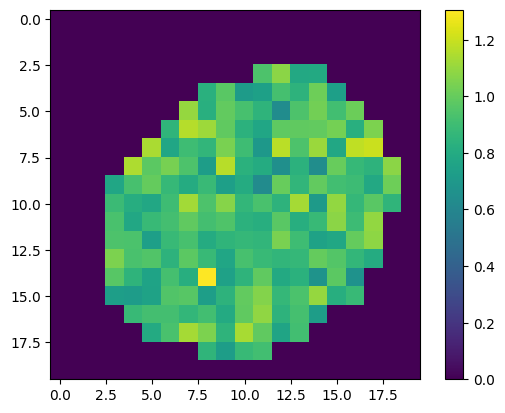

In [6]:
plt.imshow(fret_images[0,1001,:,:])
plt.colorbar()

### 2. Normalise images frame-wise

In [7]:
norm_images = normalize_images_per_frame(fret_images)

### 3. Center cells

In [8]:
centered_images = center_cells(norm_images)

In [9]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 900
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {labels_all[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(centered_images)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

### 4. Train-test split

In [10]:
train_indexes, test_indexes = train_test_split(
        np.arange(len(labels)),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )
    
train_images = centered_images[train_indexes]
test_images = centered_images[test_indexes]

train_tracks = tracks[train_indexes]
test_tracks = tracks[test_indexes]

train_labels = labels[train_indexes]
test_labels = labels[test_indexes]

train_labels_all = labels_all[train_indexes]
test_labels_all = labels_all[test_indexes]


In [11]:
np.save("../data/images/train_images.npy", train_images)
np.save("../data/images/test_images.npy", test_images)
np.save("../data/labels/train_labels.npy", train_labels)
np.save("../data/labels/test_labels.npy", test_labels)
np.save("../data/tracks/train_tracks.npy", train_tracks)
np.save("../data/tracks/test_tracks.npy", test_tracks)

### 5. Data Augmentation

In [70]:
train_images = np.load("../data/images/train_images.npy")
test_images = np.load("../data/images/test_images.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_labels = np.load("../data/labels/test_labels.npy")
train_tracks = np.load("../data/tracks/train_tracks.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

In [71]:
train_images.shape

(1108, 1080, 20, 20)

In [72]:
train_labels

array([0, 1, 0, ..., 0, 0, 0])

In [73]:
#### get a smaller (20%) subset of the training data

np.random.seed(42)
less_indexes = np.random.choice(np.arange(len(train_labels)), int(0.1 * len(train_labels)), replace=False)

smaller_x_train_images = train_images[less_indexes]
smaller_y_train = train_labels[less_indexes]
smaller_x_train_tracks = train_tracks[less_indexes]


In [75]:
int(0.1 * len(train_labels))

110

In [76]:
import numpy as np

def augment_dataset(cell_images, labels, augmentations, augment_times=5, fate_0_label=0, fate_1_label=1, seed=42):
    """
    Augments a dataset of cell movies (cells, time, height, width), balances fate 0 and fate 1,
    and ensures reproducibility by setting a seed.

    Args:
        cell_images (numpy.ndarray): Array of shape (cells, time, height, width).
        labels (numpy.ndarray): 1D array of labels corresponding to cell fates.
        augmentations (function): Function that applies augmentations to a movie sequence.
        augment_times (int): Number of unique augmented copies per movie.
        fate_0_label (int): Label for fate 0 cells.
        fate_1_label (int): Label for fate 1 cells.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: Augmented and balanced (final_images, final_labels).
    """
    np.random.seed(seed)  # Ensure reproducibility

    # Separate fate 0 and fate 1 in the dataset
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]

    # Generate multiple unique augmentations per movie
    augmented_fate_0 = np.concatenate([augmentations(movie, augment_times) for movie in fate_0_images], axis=0)
    augmented_fate_1 = np.concatenate([augmentations(movie, augment_times) for movie in fate_1_images], axis=0)

    # Combine original and augmented data
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)

    # Balance fate 0 to match fate 1 count
    target_count = len(fate_1_combined)
    if len(fate_0_combined) < target_count:
        print("did this happen")
        extra_fate_0 = np.random.choice(len(fate_0_combined), size=target_count - len(fate_0_combined), replace=True)
        balanced_fate_0 = np.concatenate([fate_0_combined, fate_0_combined[extra_fate_0]], axis=0)
    else:
        balanced_fate_0 = fate_0_combined[np.random.choice(len(fate_0_combined), size=target_count, replace=False)]

    # Merge datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) + [fate_1_label] * len(fate_1_combined))

    # Shuffle data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images, final_labels = final_images[shuffle_indexes], final_labels[shuffle_indexes]

    return final_images, final_labels


def augmentations(movie, augment_times=4, seed=42):
    """
    Applies multiple **unique** augmentations to the whole movie (time-series of images).

    Args:
        movie (numpy.ndarray): Array of shape (time, height, width).
        augment_times (int): Number of unique augmented copies to generate.

    Returns:
        numpy.ndarray: Augmented movies (augment_times, time, height, width).
    """
    all_augmentations = [
        lambda x: np.flip(x, axis=-1),  # Flip horizontally
        lambda x: np.flip(x, axis=-2),  # Flip vertically
        lambda x: np.rot90(x, k=1, axes=(-2, -1)),  # Rotate 90 degrees
        lambda x: np.rot90(x, k=2, axes=(-2, -1)),  # Rotate 180 degrees
        lambda x: np.rot90(x, k=3, axes=(-2, -1))  # Rotate 270 degrees
    ]
    
    np.random.seed(seed)

    # Select random augmentations
    np.random.shuffle(all_augmentations)

    selected_augmentations = all_augmentations[:augment_times]

    # Apply selected augmentations
    augmented_movies = [augment(movie) for augment in selected_augmentations]

    return np.array(augmented_movies)  # Shape: (augment_times, time, height, width)

In [77]:
train_images_augmented, train_labels_augmented = augment_dataset(train_images, train_labels, augmentations)

KeyboardInterrupt: 

In [78]:
smaller_train_images_augmented, smaller_train_labels_augmented = augment_dataset(smaller_x_train_images, smaller_y_train, augmentations)

In [79]:
smaller_train_images_augmented.shape, smaller_train_labels_augmented.shape

((156, 1080, 20, 20), (156,))

In [5]:
train_images_augmented.shape, train_labels_augmented.shape

((2184, 1080, 20, 20), (2184,))

In [6]:
from ipywidgets import interact, IntSlider

def display_movie(images, channel=0):
    cell = 1092+182
    def plot_frame(frame):
        plt.imshow(images[cell, frame, :, :], cmap='gray')
        plt.title(f"Cell {cell}, Classification: {train_labels_augmented[cell]}")
        plt.axis('off')
        plt.show()

    # Create a slider for frame selection
    interact(plot_frame, frame=IntSlider(min=0, max=1079, step=1, value=0)) # max=images.shape[0] - 1

display_movie(train_images_augmented)

interactive(children=(IntSlider(value=0, description='frame', max=1079), Output()), _dom_classes=('widget-inte…

In [7]:
np.save("../data/images/train_images_augmented4.npy", train_images_augmented)
np.save("../data/labels/train_labels_augmented4.npy", train_labels_augmented)

In [ ]:
## FOR VISUALISATION PURPOSES ONLY ## - augment test set
# test_images_augmented, test_labels_augmented = augment_dataset(test_images, test_labels, augmentations)

### 6. Stretch image intensities in a frame-wise way
This is done to do a scaling of the intensities in each cell, so that the minimum value is 0 (but keeping the same "relationship" between pixel values)

In [5]:
stretched_x_train, stretched_x_test = stretch_intensities_global(train_images_augmented, test_images)

In [80]:
stretched_x_train_smaller, stretched_x_test = stretch_intensities_global(smaller_train_images_augmented, test_images)

In [81]:
np.save("../data/images/stretched_x_test_from_smaller10.npy", stretched_x_test)

In [62]:
stretched_x_test.shape

(277, 1080, 20, 20)

In [59]:
np.nonzero(stretched_x_test!=x_test)

(array([  0,   0,   0, ..., 276, 276, 276]),
 array([   0,    0,    0, ..., 1076, 1076, 1076]),
 array([ 3,  3,  3, ..., 17, 17, 17]),
 array([12, 13, 14, ..., 12, 13, 14]))

In [ ]:
# np.save("../data/images/stretched_x_test_augmented.npy", stretched_x_test_augmented)

In [53]:
x_train = np.load('../data/images/train_images_augmented4_stretched.npy')
y_train = np.load('../data/labels/train_labels_augmented.npy')
x_test = np.load('../data/images/test_images_augmented4_stretched.npy')
y_test = np.load('../data/labels/test_labels.npy')

In [9]:
np.save("../data/images/train_images_augmented4_stretched.npy", stretched_x_train)
np.save("../data/images/test_images_augmented4_stretched.npy", stretched_x_test)

print("Augmented images shape: ", stretched_x_train.shape, "Augmented labels shape: ", train_labels_augmented.shape, "Test images shape: ", stretched_x_test.shape, "Test labels shape: ", test_labels.shape, "Train tracks shape: ", train_tracks.shape, "Test tracks shape: ", test_tracks.shape)

Augmented images shape:  (2184, 1080, 20, 20) Augmented labels shape:  (2184,) Test images shape:  (277, 1080, 20, 20) Test labels shape:  (277,) Train tracks shape:  (1108, 1080, 19) Test tracks shape:  (277, 1080, 19)


### 7. Cell clock normalisation

In [3]:
image_x_train = np.load("../data/images/train_images_augmented4_stretched.npy")
image_x_test = np.load('../data/images/test_images_augmented4_stretched.npy')
track_x_train = np.load("../data/tracks/train_tracks.npy")
track_x_test = np.load("../data/tracks/test_tracks.npy")
y_train = np.load("../data/labels/train_labels.npy")
y_train_augmented = np.load('../data/labels/train_labels_augmented4.npy')
y_test = np.load('../data/labels/test_labels.npy')

In [82]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data


def normalize_cell_time_images(images):
    """
    Normalize cell time by extracting images at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - images: numpy array of shape (cells, time, height, width)
      (assumes a cell's lifetime is determined by nonzero pixel values)
    
    Returns:
    - normalized_images: numpy array of shape (cells, 11, height, width)
    """
    num_cells, num_timepoints, height, width = images.shape
    normalized_images = np.zeros((num_cells, 11, height, width))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero frames)
        lifetime = np.count_nonzero(np.sum(images[i], axis=(1, 2)))  # Sum over spatial dims to check for zeros
        #print(lifetime)
        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract images at these indices
        normalized_images[i] = images[i, indices, :, :]

    return normalized_images



In [ ]:
time_norm_train_track = normalize_cell_time(track_x_train)
time_norm_test_track = normalize_cell_time(track_x_test)

time_norm_train_images = normalize_cell_time_images(image_x_train)
time_norm_test_images = normalize_cell_time_images(image_x_test)

In [83]:
time_norm_smaller_train_track = normalize_cell_time(smaller_x_train_tracks)
time_norm_smaller_train_images = normalize_cell_time_images(stretched_x_train_smaller)

In [89]:
np.save("../data/tracks/time_norm_smaller_train_track10.npy", time_norm_smaller_train_track)
np.save("../data/images/time_norm_smaller_train_images10.npy", time_norm_smaller_train_images)
np.save("../data/labels/smaller_train_labels_augmented10.npy", smaller_train_labels_augmented)
np.save("../data/labels/smaller_y_train10.npy", smaller_y_train)

In [41]:
time_norm_smaller_train_images.shape, smaller_train_labels_augmented.shape

((360, 11, 20, 20), (360,))

In [12]:
np.save("../data/images/time_norm_train_images.npy", time_norm_train_images)
np.save("../data/images/time_norm_test_images.npy", time_norm_test_images)

In [11]:
np.nonzero(time_norm_train_images[:,0] != image_x_train[:,0])

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

# Model Workflow - Training and Evaluation

In [2]:
train_images_augmented = np.load('../data/images/time_norm_train_images.npy')
train_labels_augmented = np.load('../data/labels/train_labels_augmented4.npy')
test_images = np.load('../data/images/time_norm_test_images.npy')
test_labels = np.load('../data/labels/test_labels.npy')
train_tracks = np.load("../data/tracks/train_tracks.npy")
train_labels = np.load("../data/labels/train_labels.npy")
test_tracks = np.load("../data/tracks/test_tracks.npy")

## Tabular Data

In [42]:
from tensorflow.keras import layers, Sequential
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
}

In [90]:
### removing features that would bias the model decision (i.e., the fate of the cell, mitosis time, etc.)

train_tracks_features = train_tracks[:, :, 4:17 ] #[4,14,15,16] all features : 4:17
test_tracks_features = test_tracks[:, :, 4:17]

train_tracks_features = time_norm_smaller_train_track[:, :, 4:17 ]
train_labels = smaller_y_train

print(train_tracks_features.shape)

(110, 11, 13)


### Simple MLP (No hidden layers)

In [140]:
def simple_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

Using the first frame

In [126]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = simple_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_10          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │            28 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80 (320.00 B)

 Trainable params: 54 (216.00 B)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6074 - loss: 0.7646 - val_accuracy: 0.1522 - val_loss: 3.1772
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6041 - loss: 0.7584 - val_accuracy: 0.2826 - val_loss: 1.5749
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6055 - loss: 0.7236 - val_accuracy: 0.4420 - val_loss: 1.0261
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6054 - loss: 0.7412 - val_accuracy: 0.5000 - val_loss: 0.8256
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.6194 - loss: 0.6937 - val_accuracy: 0.5435 - val_loss: 0.7357
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6358 - loss: 0.6450 - val_accuracy: 0.5652 - val_loss: 0.7005
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5987 - loss: 0.6822 - val_accuracy: 0.5652 - val_loss: 0.6853
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6060 - loss: 0.6884 - val_accuracy: 0.58

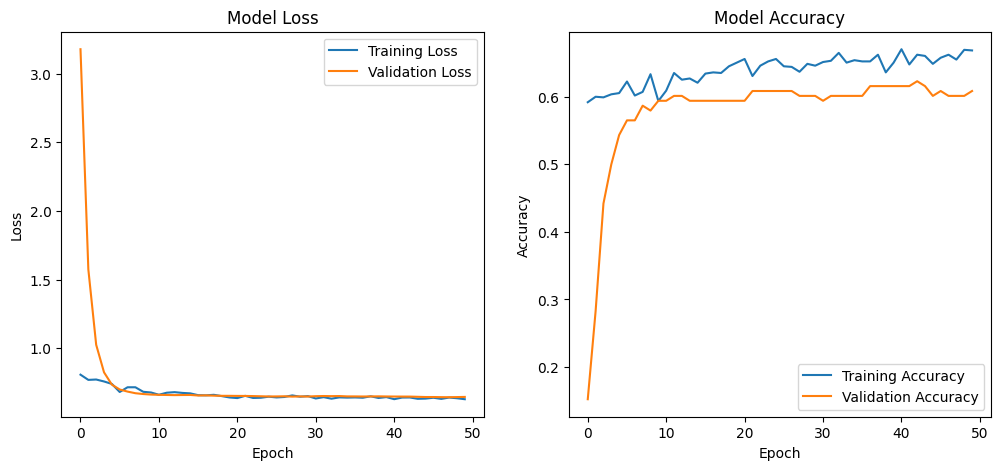

In [127]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[0.65765766 0.34234234]
 [0.5        0.5       ]]


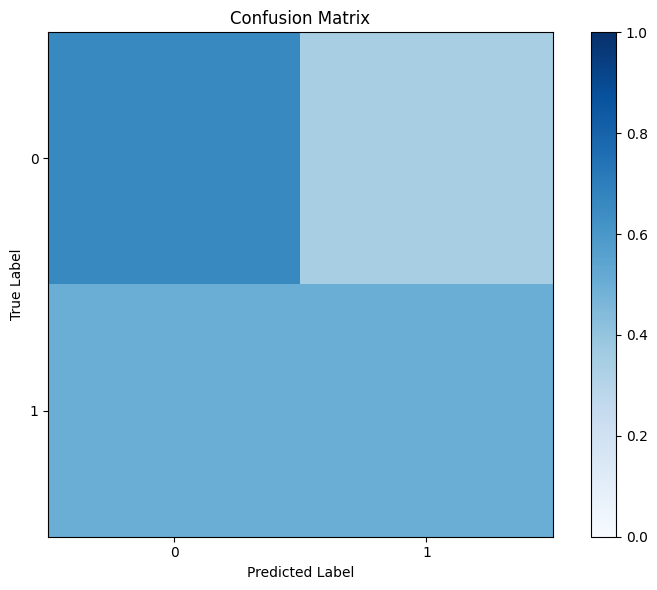

In [128]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### More Complex MLP 

In [91]:
def complex_mlp_classifier(latent_dim):
    return Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    ])

In [92]:
frame = 0

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
class_weights = dict(enumerate(class_weights))

tf.keras.utils.set_random_seed(config['seed'])

classifier = complex_mlp_classifier(latent_dim=train_tracks_features[:,frame,:].shape[1]) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(test_tracks_features[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(train_tracks_features[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) # 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7254 - loss: 0.7812 - val_accuracy: 0.2246 - val_loss: 1.1118
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6583 - loss: 0.8255 - val_accuracy: 0.4203 - val_loss: 0.7809
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6800 - loss: 0.7886 - val_accuracy: 0.6159 - val_loss: 0.6376
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6814 - loss: 0.7598 - val_accuracy: 0.7391 - val_loss: 0.5753
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6312 - loss: 0.7920 - val_accuracy: 0.7536 - val_loss: 0.5652
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6843 - loss: 0.7830 - val_accuracy: 0.7464 - val_loss: 0.5722
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7228 - loss: 0.7680 - val_accuracy: 0.7681 - val_loss: 0.5768
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6933 - loss: 0.7789 - val_accuracy: 0.7681 - val_loss: 0.5787
Epoch 9

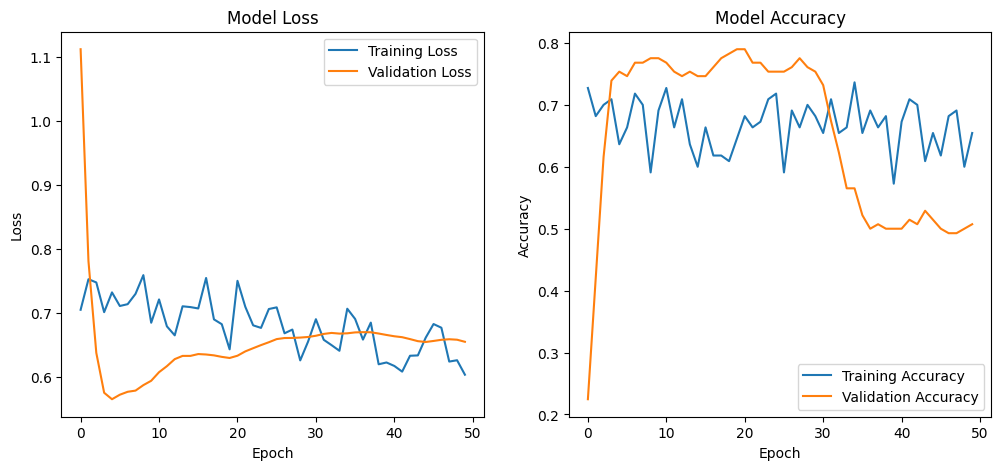

In [93]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[[0.63963964 0.36036036]
 [0.35714286 0.64285714]]
Precision:  0.6417043253712073


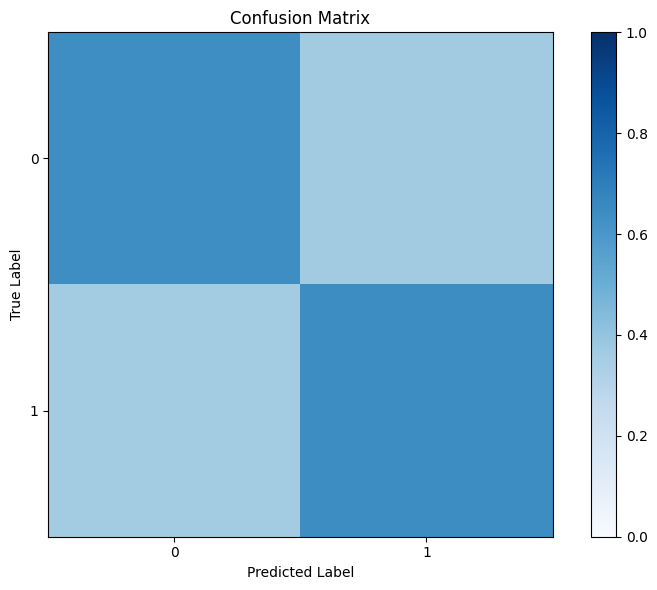

In [94]:
num_classes = len(np.unique(train_labels))
y_pred = classifier.predict(x_test_tracks)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_tracks, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
print("Precision: ", precision)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

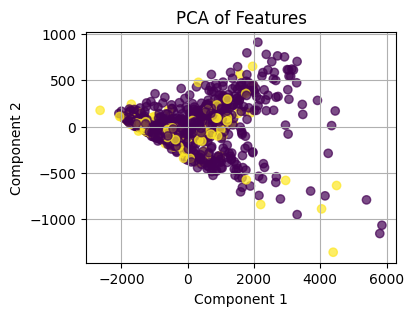

In [96]:
# Plot PCA of features to see if they are separable

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_tracks_features[:,frame,:])
X_pca = pca.transform(train_tracks_features[:,frame,:])

plt.figure(figsize=(4, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_labels.flatten(), cmap='viridis', alpha=0.7)
#sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train_labels.flatten())
plt.title('PCA of Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()

#### Temporal study

In [4]:
train_tracks_features = train_tracks[:, :, 4:17 ]
test_tracks_features = test_tracks[:, :, 4:17 ]

In [5]:
train_tracks_features.shape

(1108, 1080, 13)

In [6]:
def normalize_cell_time(data):
    """
    Normalize cell time by extracting feature values at 0%, 10%, ..., 100% 
    of each cell's lifetime.
    
    Parameters:
    - data: numpy array of shape (cells, time points, features)
      (assumes the first feature is used to determine lifetime)
    
    Returns:
    - normalized_data: numpy array of shape (cells, 11, features)
    """
    num_cells, num_timepoints, num_features = data.shape
    normalized_data = np.zeros((num_cells, 11, num_features))

    for i in range(num_cells):
        # Determine lifetime (number of nonzero values in the first feature)
        lifetime = np.count_nonzero(data[i, :, 0])

        if lifetime == 0:
            continue  # Skip cells that are all zero

        # Compute the indices corresponding to 0%, 10%, ..., 100% of the lifetime
        indices = np.round(np.linspace(0, lifetime - 1, 11)).astype(int)

        # Extract feature values at these indices
        normalized_data[i] = data[i, indices, :]

    return normalized_data



In [7]:
time_norm_train_track = normalize_cell_time(train_tracks_features)
time_norm_test_track = normalize_cell_time(test_tracks_features)

In [8]:
time_norm_train_track.shape, time_norm_test_track.shape

((1108, 11, 13), (277, 11, 13))

In [32]:
precisions = np.zeros((11, 1))
mean_diagonals = np.zeros((11, 1))
all_confusion_matrices = np.zeros((11, 2, 2))
seed = 42

for i in range(11):
    frame = i
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels.flatten()), y=train_labels.flatten())
    class_weights = dict(enumerate(class_weights))

    tf.keras.utils.set_random_seed(seed)

    classifier = complex_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1]) #[:, [3, 8]] 
    #classifier = simple_mlp_classifier(latent_dim=time_norm_train_track[:,frame,:].shape[1])

    # Train the classifier
    classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
    classifier.summary()

    x_val_tracks, x_test_tracks, y_val_tracks, y_test_tracks = train_test_split(time_norm_test_track[:,frame,:], test_labels, test_size=0.5, random_state=42) # 42 random state

    history = classifier.fit(time_norm_train_track[:,frame,:], train_labels, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val_tracks, y_val_tracks), class_weight=class_weights) 

    y_pred = classifier.predict(x_test_tracks)

    num_classes = len(np.unique(train_labels))
    threshold = 0.5
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_tracks, y_pred_classes)

    class_sums = cm.sum(axis=1, keepdims=True)
    conf_matrix_normalized = cm / class_sums

    print(conf_matrix_normalized)

    all_confusion_matrices[i] = conf_matrix_normalized

    precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
    mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
    print("frame", frame, "Precision: ", precision, "Mean diagonal: ", mean_diagonal)

    precisions[i] = precision
    mean_diagonals[i] = mean_diagonal


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_46          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6777 - loss: 0.7542 - val_accuracy: 0.8043 - val_loss: 0.5931
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6072 - loss: 0.7059 - val_accuracy: 0.8188 - val_loss: 0.6393
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5235 - loss: 0.7127 - val_accuracy: 0.5290 - val_loss: 0.6843
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5351 - loss: 0.6937 - val_accuracy: 0.5072 - val_loss: 0.6876
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.5121 - loss: 0.6792 - val_accuracy: 0.4638 - val_loss: 0.6797
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.5070 - loss: 0.6980 - val_accuracy: 0.4928 - val_loss: 0.6750
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5357 - loss: 0.6572 - val_accuracy: 0.4928 - val_loss: 0.6700
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.5343 - loss: 0.6672 - val_accuracy: 0.5217 -

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_47          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6620 - loss: 0.7621 - val_accuracy: 0.8406 - val_loss: 0.5748
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6045 - loss: 0.7042 - val_accuracy: 0.8478 - val_loss: 0.6164
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.5732 - loss: 0.7201 - val_accuracy: 0.5942 - val_loss: 0.6813
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5113 - loss: 0.7011 - val_accuracy: 0.4493 - val_loss: 0.6988
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.5064 - loss: 0.6778 - val_accuracy: 0.4203 - val_loss: 0.7034
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.5187 - loss: 0.6883 - val_accuracy: 0.4710 - val_loss: 0.6892
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.5451 - loss: 0.6602 - val_accuracy: 0.5072 - val_loss: 0.6858
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.5391 - loss: 0.6772 - val_accuracy: 0.5290

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_48          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_144 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_145 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_146 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6857 - loss: 0.7701 - val_accuracy: 0.8623 - val_loss: 0.5417
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 0.7036 - val_accuracy: 0.8623 - val_loss: 0.5888
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5570 - loss: 0.7205 - val_accuracy: 0.6594 - val_loss: 0.6566
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.5512 - loss: 0.6911 - val_accuracy: 0.5652 - val_loss: 0.6685
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.5497 - loss: 0.6725 - val_accuracy: 0.5725 - val_loss: 0.6570
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5489 - loss: 0.6831 - val_accuracy: 0.5942 - val_loss: 0.6433
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.5871 - loss: 0.6348 - val_accuracy: 0.5580 - val_loss: 0.6461
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.5346 - loss: 0.6659 - val_accuracy: 0.5797

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_49          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_147 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_148 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_149 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6767 - loss: 0.7681 - val_accuracy: 0.8623 - val_loss: 0.5357
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6508 - loss: 0.7035 - val_accuracy: 0.8551 - val_loss: 0.5954
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5889 - loss: 0.7111 - val_accuracy: 0.6087 - val_loss: 0.6610
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5563 - loss: 0.6876 - val_accuracy: 0.5362 - val_loss: 0.6706
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5147 - loss: 0.6733 - val_accuracy: 0.5290 - val_loss: 0.6687
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5649 - loss: 0.6762 - val_accuracy: 0.5652 - val_loss: 0.6510
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5921 - loss: 0.6500 - val_accuracy: 0.5290 - val_loss: 0.6613
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5741 - loss: 0.6515 - val_accuracy: 0.52

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_50          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_150 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_151 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_152 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6924 - loss: 0.7617 - val_accuracy: 0.8623 - val_loss: 0.5276
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6368 - loss: 0.7056 - val_accuracy: 0.8188 - val_loss: 0.6017
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.5874 - loss: 0.7145 - val_accuracy: 0.6304 - val_loss: 0.6562
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5489 - loss: 0.6916 - val_accuracy: 0.5652 - val_loss: 0.6619
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5669 - loss: 0.6675 - val_accuracy: 0.5797 - val_loss: 0.6657
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.5641 - loss: 0.6707 - val_accuracy: 0.5580 - val_loss: 0.6633
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5762 - loss: 0.6275 - val_accuracy: 0.5797 - val_loss: 0.6544
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.5694 - loss: 0.6484 - val_accuracy: 0.6087

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_51          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_153 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_154 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_155 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6981 - loss: 0.7527 - val_accuracy: 0.8623 - val_loss: 0.5340
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6213 - loss: 0.7045 - val_accuracy: 0.8478 - val_loss: 0.5831
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5710 - loss: 0.7140 - val_accuracy: 0.6884 - val_loss: 0.6302
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.5523 - loss: 0.6935 - val_accuracy: 0.6884 - val_loss: 0.6402
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5520 - loss: 0.6726 - val_accuracy: 0.6232 - val_loss: 0.6487
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5667 - loss: 0.6733 - val_accuracy: 0.6159 - val_loss: 0.6360
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5883 - loss: 0.6349 - val_accuracy: 0.6087 - val_loss: 0.6432
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5560 - loss: 0.6585 - val_accuracy: 0.6087

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_52          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_156 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_157 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_158 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6959 - loss: 0.7580 - val_accuracy: 0.8696 - val_loss: 0.5371
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.7025 - val_accuracy: 0.8696 - val_loss: 0.5694
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5986 - loss: 0.7078 - val_accuracy: 0.7101 - val_loss: 0.6166
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5911 - loss: 0.6804 - val_accuracy: 0.6377 - val_loss: 0.6265
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - accuracy: 0.5726 - loss: 0.6709 - val_accuracy: 0.5870 - val_loss: 0.6228
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5905 - loss: 0.6584 - val_accuracy: 0.5870 - val_loss: 0.6076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.5821 - loss: 0.6286 - val_accuracy: 0.6014 - val_loss: 0.6062
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6028 - loss: 0.6360 - val_accuracy: 0.6159

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_53          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_159 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_160 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_161 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6845 - loss: 0.7527 - val_accuracy: 0.8696 - val_loss: 0.5113
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 0.7010 - val_accuracy: 0.8623 - val_loss: 0.5679
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.6050 - loss: 0.7119 - val_accuracy: 0.6812 - val_loss: 0.6292
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.5356 - loss: 0.6870 - val_accuracy: 0.6014 - val_loss: 0.6468
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5347 - loss: 0.6829 - val_accuracy: 0.5797 - val_loss: 0.6521
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5486 - loss: 0.6831 - val_accuracy: 0.5725 - val_loss: 0.6422
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5760 - loss: 0.6458 - val_accuracy: 0.5725 - val_loss: 0.6426
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5811 - loss: 0.6452 - val_accuracy: 0.6014

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_54          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_162 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_163 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_164 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6925 - loss: 0.7463 - val_accuracy: 0.8623 - val_loss: 0.5436
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6524 - loss: 0.6977 - val_accuracy: 0.8478 - val_loss: 0.6089
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6101 - loss: 0.7048 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5578 - loss: 0.6951 - val_accuracy: 0.5072 - val_loss: 0.6523
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.5378 - loss: 0.6784 - val_accuracy: 0.5000 - val_loss: 0.6517
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.5586 - loss: 0.6874 - val_accuracy: 0.5507 - val_loss: 0.6355
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - accuracy: 0.5570 - loss: 0.6478 - val_accuracy: 0.5942 - val_loss: 0.6371
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.5591 - loss: 0.6556 - val_accuracy: 0.59

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_55          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_165 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_166 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_167 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7012 - loss: 0.7499 - val_accuracy: 0.8623 - val_loss: 0.5660
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 0.7068 - val_accuracy: 0.7826 - val_loss: 0.6303
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 0.7148 - val_accuracy: 0.5072 - val_loss: 0.6892
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.5295 - loss: 0.7008 - val_accuracy: 0.4565 - val_loss: 0.6946
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5438 - loss: 0.6869 - val_accuracy: 0.4638 - val_loss: 0.6931
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5523 - loss: 0.6843 - val_accuracy: 0.5290 - val_loss: 0.6692
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.5654 - loss: 0.6543 - val_accuracy: 0.5435 - val_loss: 0.6621
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.5706 - loss: 0.6570 - val_accuracy: 0.5652 -

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_56          │ (None, 13)             │            52 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 32)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_168 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_169 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_170 (Dropout)           │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,182 (4.62 KB)

 Trainable params: 1,156 (4.52 KB)

 Non-trainable params: 26 (104.00 B)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7119 - loss: 0.7453 - val_accuracy: 0.8696 - val_loss: 0.4989
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7011 - val_accuracy: 0.8696 - val_loss: 0.5986
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.5983 - loss: 0.7137 - val_accuracy: 0.6304 - val_loss: 0.6604
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5342 - loss: 0.6981 - val_accuracy: 0.5580 - val_loss: 0.6744
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5542 - loss: 0.6956 - val_accuracy: 0.5145 - val_loss: 0.6774
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.5679 - loss: 0.6848 - val_accuracy: 0.5725 - val_loss: 0.6637
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.6013 - loss: 0.6571 - val_accuracy: 0.5870 - val_loss: 0.6502
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5656 - loss: 0.6621 - val_accuracy: 0.5797

In [33]:
precisions

array([[0.61615844],
       [0.6711554 ],
       [0.72456576],
       [0.74715262],
       [0.74004684],
       [0.74715262],
       [0.80340064],
       [0.83457526],
       [0.85298013],
       [0.77932406],
       [0.8195122 ]])

In [35]:
np.save("all_confusion_matrices_tabular.npy", all_confusion_matrices)

In [23]:
mean_diagonals

array([[0.66296654],
       [0.72168597],
       [0.71702059],
       [0.76206564],
       [0.77992278],
       [0.75788288],
       [0.7752574 ],
       [0.74855212],
       [0.74823037],
       [0.73021236],
       [0.77509653]])

In [25]:
precisions_tabular_seed44 = precisions
mean_diagonals_tabular_seed44 = mean_diagonals

np.save("precisions_tabular_seed44.npy", precisions_tabular_seed44)
np.save("mean_diagonals_tabular_seed44.npy", mean_diagonals_tabular_seed44)

In [17]:
precisions_tabular_seed43 = precisions
mean_diagonals_tabular_seed43 = mean_diagonals

In [ ]:
precisions_tabular_seed42 = precisions
mean_diagonals_tabular_seed42 = mean_diagonals

In [20]:
np.save("precisions_tabular_seed42.npy", precisions_tabular_seed42)
np.save("mean_diagonals_tabular_seed42.npy", mean_diagonals_tabular_seed42)

np.save("precisions_tabular_seed43.npy", precisions_tabular_seed43)
np.save("mean_diagonals_tabular_seed43.npy", mean_diagonals_tabular_seed43)

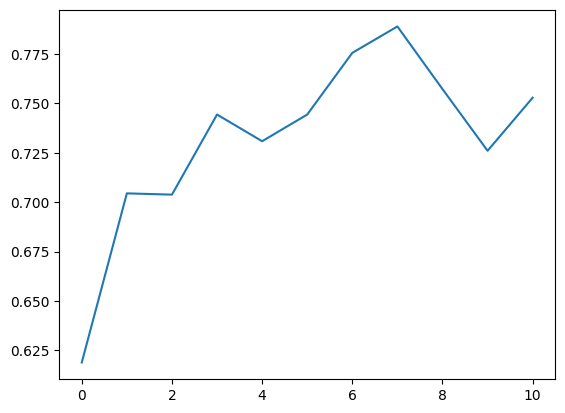

In [156]:
plt.plot(mean_diagonals)

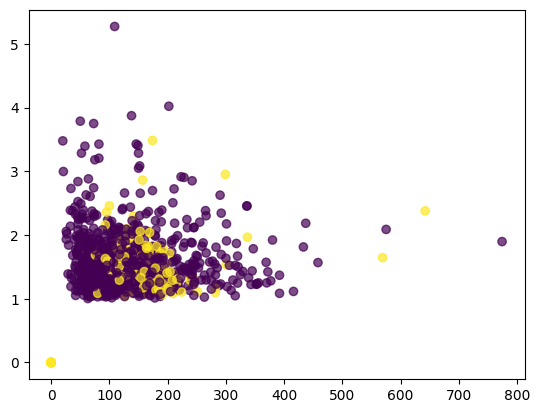

In [63]:
plt.scatter(time_norm_train_track[:,10,2], time_norm_train_track[:,10,3], c=train_labels.flatten(), cmap='viridis', alpha=0.7)

## Image Data

### Full CellFate Workflow 

#### 1. Train Adversarial Autoencoder (AAE)

In [3]:
config = {
        'batch_size': 30,
        'epochs': 15,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 5,
        'lambda_adv': 1,
    }

In [4]:
autoencoder_results = train_autoencoder(config, train_images_augmented[:,0,:,:])

encoder = autoencoder_results['encoder']
decoder = autoencoder_results['decoder']
discriminator = autoencoder_results['discriminator']
reconstruction_losses = autoencoder_results['recon_loss']
adversarial_losses = autoencoder_results['adv_loss']


Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 42, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.2867, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.7749, Adversarial loss: 0.7269, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.7638, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7467, Adversarial loss: 0.7116, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7450, Adversarial loss: 0.7094, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7531, Adversarial loss: 0.6986, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7237, Adversarial loss: 0.7067, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7281, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7274, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

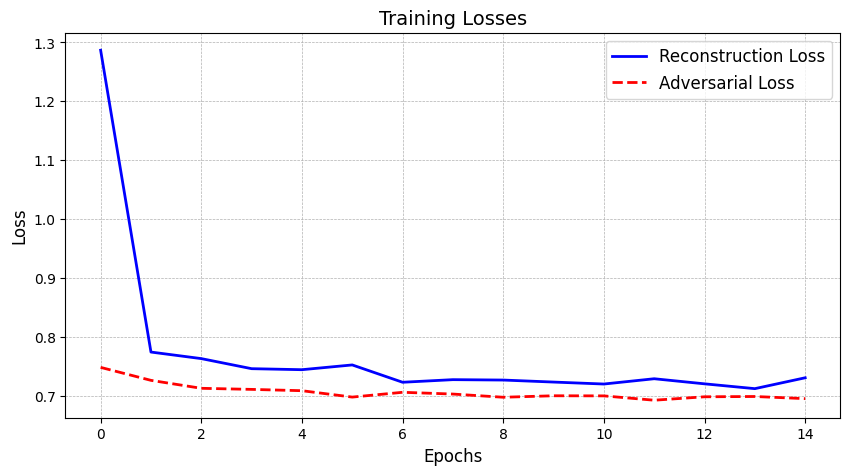

In [5]:
plt.figure(figsize=(10, 5))

plt.plot(reconstruction_losses, label='Reconstruction Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(adversarial_losses, label='Adversarial Loss', color='red', linestyle='--', linewidth=2)

# Title and labels
plt.title(f"Training Losses", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add a grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


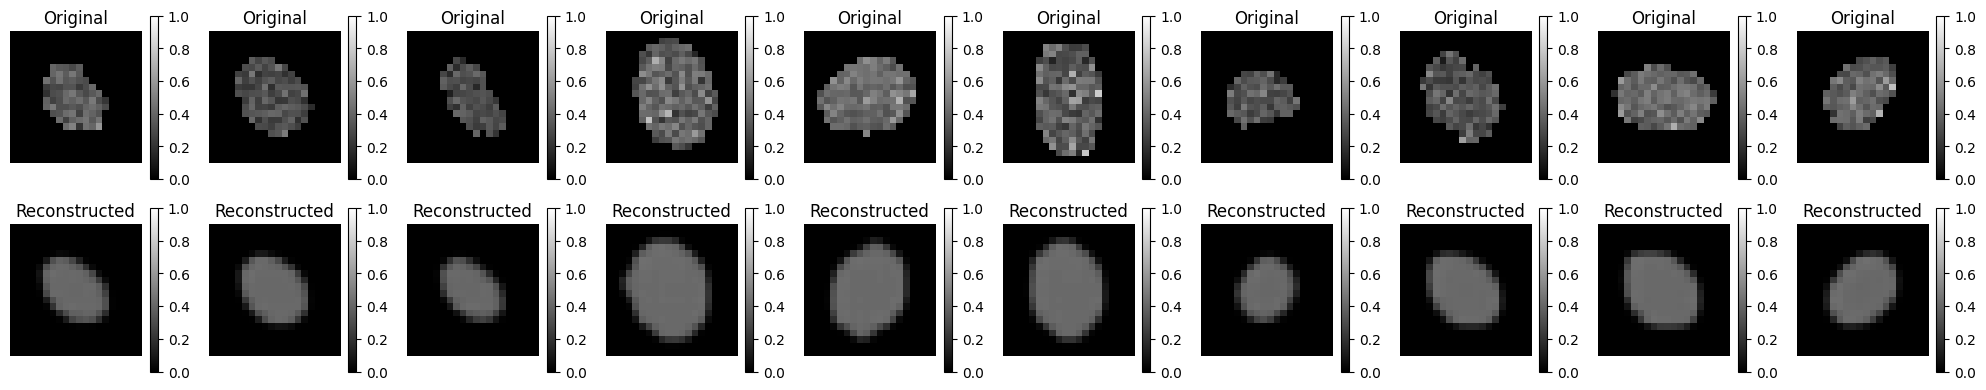

In [6]:
z_imgs = encoder.predict(train_images_augmented[:,0,:,:])
recon_imgs = decoder.predict(z_imgs)

reconstruction_images(train_images_augmented[:,0,:,:], recon_imgs)

Top correlated features: 1, 0


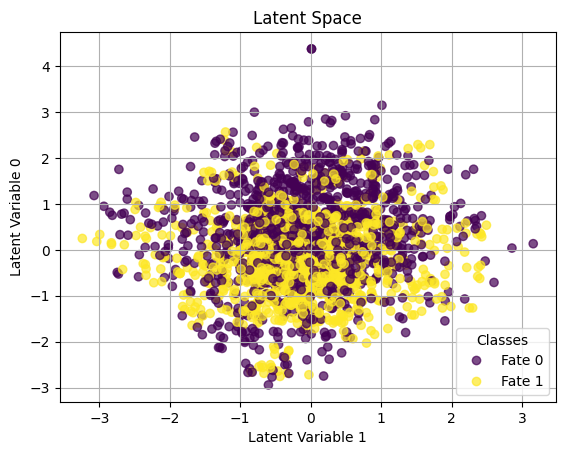

In [8]:
visualize_latent_space(z_imgs, train_labels_augmented)

#### 2. Train AAE with Contrastive loss and Covariance loss

In [9]:
config = {
        'batch_size': 30,
        'epochs': 100,
        'learning_rate': 0.001,
        'seed': 42,
        'latent_dim': 2,
        'GaussianNoise_std': 0.003,
        'lambda_recon': 6,
        'lambda_adv': 4,
        'lambda_cov': 0.0001,
        'lambda_contra': 8,
    }

In [10]:
cellfate_results = train_cellfate(config, encoder, decoder, discriminator, train_images_augmented[:,0,:,:], train_labels_augmented, test_images[:,0,:,:], test_labels) #lambda_recon=scaled_autoencoder_results['lambda_recon'], lambda_adv=scaled_autoencoder_results['lambda_adv']
encoder = cellfate_results['encoder']
decoder = cellfate_results['decoder']
discriminator = cellfate_results['discriminator']
reconstruction_losses = cellfate_results['recon_loss']
adversarial_losses = cellfate_results['adv_loss']
cov_losses = cellfate_results['cov_loss']
contra_losses = cellfate_results['contra_loss']

Training with batch size: 30, epochs: 100, learning rate: 0.001, seed: 42, latent dim: 2
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 1/100: Reconstruction loss: 0.8974, Adversarial loss: 2.8218, Contrastive loss: 5.4767, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 2/100: Reconstruction loss: 0.9062, Adversarial loss: 2.8233, Contrastive loss: 5.3505, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 3/100: Reconstruction loss: 0.9729, Adversarial loss: 2.8074, Contrastive loss: 5.3459, Covariance loss: 0.0000, lamdba recon: 6.0000, lambda adv: 4.0000, lambda cov: 0.0001, lambda contra: 8.0000
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5844 - loss: 0.6921 - val_accuracy: 0.5942 - val_loss: 0.6591
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.6283 - loss: 0.6695 - val_accuracy: 0.6014 - val_loss: 0.6453
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6356 - loss: 0.6498 - val_accuracy: 0.5942 - val_loss: 0.6362
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6315 - loss: 0.6606 - val_accuracy: 0.5797 - val_loss: 0.6289
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - accuracy: 0.6556 - loss: 0.6268 - val_accuracy: 0.5797 - val_loss: 0.6252
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - accuracy: 0.6162 - loss: 0.6416 - val_accuracy: 0.5797 - val_loss: 0.6233
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.6611 - loss: 0.6181 - val_accuracy: 0.5725 - val_loss: 0.6270
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6284 - loss: 0.6307 - val_accuracy: 0.57

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6505 - loss: 0.6165 - val_accuracy: 0.7609 - val_loss: 0.6067
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.5956 - val_accuracy: 0.7464 - val_loss: 0.6025
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.6408 - loss: 0.6220 - val_accuracy: 0.7319 - val_loss: 0.5995
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6581 - loss: 0.6135 - val_accuracy: 0.7319 - val_loss: 0.5988
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6554 - loss: 0.6126 - val_accuracy: 0.7319 - val_loss: 0.6001
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6642 - loss: 0.6041 - val_accuracy: 0.7319 - val_loss: 0.6005
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.6488 - loss: 0.6110 - val_accuracy: 0.7319 - val_loss: 0.5995
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.6543 - loss: 0.6117 - val_accuracy: 0.7319

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 0.6751 - val_accuracy: 0.7101 - val_loss: 0.6452
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - accuracy: 0.6535 - loss: 0.6835 - val_accuracy: 0.7174 - val_loss: 0.6205
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.6645 - loss: 0.6483 - val_accuracy: 0.7246 - val_loss: 0.6025
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6712 - loss: 0.6452 - val_accuracy: 0.7246 - val_loss: 0.5870
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - accuracy: 0.6659 - loss: 0.6170 - val_accuracy: 0.7246 - val_loss: 0.5779
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.6866 - loss: 0.6101 - val_accuracy: 0.7391 - val_loss: 0.5712
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.6738 - loss: 0.6070 - val_accuracy: 0.7464 - val_loss: 0.5655
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6818 - loss: 0.5960 - val_accuracy: 0.75

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4964 - loss: 0.7057 - val_accuracy: 0.6377 - val_loss: 0.6697
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6060 - loss: 0.6685 - val_accuracy: 0.6232 - val_loss: 0.6615
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - accuracy: 0.6404 - loss: 0.6499 - val_accuracy: 0.6522 - val_loss: 0.6523
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.6582 - loss: 0.6338 - val_accuracy: 0.6739 - val_loss: 0.6419
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.6747 - loss: 0.6285 - val_accuracy: 0.6812 - val_loss: 0.6339
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6614 - loss: 0.6206 - val_accuracy: 0.6884 - val_loss: 0.6263
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.6633 - loss: 0.6169 - val_accuracy: 0.6884 - val_loss: 0.6195
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - accuracy: 0.6654 - loss: 0.6189 - val_accuracy: 0.70

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3573 - loss: 1.1115 - val_accuracy: 0.2899 - val_loss: 1.0772
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - accuracy: 0.4064 - loss: 1.0129 - val_accuracy: 0.3043 - val_loss: 0.9782
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.4219 - loss: 0.9291 - val_accuracy: 0.3116 - val_loss: 0.8917
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.4188 - loss: 0.8661 - val_accuracy: 0.3406 - val_loss: 0.8162
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.4045 - loss: 0.8123 - val_accuracy: 0.4203 - val_loss: 0.7562
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.4388 - loss: 0.7610 - val_accuracy: 0.4493 - val_loss: 0.7132
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - accuracy: 0.4915 - loss: 0.7180 - val_accuracy: 0.5217 - val_loss: 0.6770
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.5211 - loss: 0.6941 - val_accuracy: 0.63

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5134 - loss: 0.9232 - val_accuracy: 0.4058 - val_loss: 0.9529
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5297 - loss: 0.8562 - val_accuracy: 0.4565 - val_loss: 0.8799
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.5568 - loss: 0.8064 - val_accuracy: 0.4855 - val_loss: 0.8159
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5598 - loss: 0.7678 - val_accuracy: 0.5072 - val_loss: 0.7681
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 0.5706 - loss: 0.7380 - val_accuracy: 0.5362 - val_loss: 0.7258
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.5926 - loss: 0.7016 - val_accuracy: 0.5580 - val_loss: 0.6934
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - accuracy: 0.5905 - loss: 0.6948 - val_accuracy: 0.5797 - val_loss: 0.6691
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.6295 - loss: 0.6500 - val_accuracy: 0.6014

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5822 - loss: 0.8852 - val_accuracy: 0.5217 - val_loss: 0.8075
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5979 - loss: 0.8311 - val_accuracy: 0.5290 - val_loss: 0.7731
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6020 - loss: 0.7898 - val_accuracy: 0.5435 - val_loss: 0.7447
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.6106 - loss: 0.7571 - val_accuracy: 0.5580 - val_loss: 0.7191
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.6234 - loss: 0.7236 - val_accuracy: 0.5725 - val_loss: 0.6913
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.6157 - loss: 0.7025 - val_accuracy: 0.6087 - val_loss: 0.6721
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - accuracy: 0.6227 - loss: 0.6749 - val_accuracy: 0.6232 - val_loss: 0.6543
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.6334 - loss: 0.6582 - val_accuracy: 0.62

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4541 - loss: 0.7435 - val_accuracy: 0.5507 - val_loss: 0.6984
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.5511 - loss: 0.7054 - val_accuracy: 0.5290 - val_loss: 0.6951
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.6199 - loss: 0.6743 - val_accuracy: 0.5652 - val_loss: 0.6878
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.6244 - loss: 0.6588 - val_accuracy: 0.5797 - val_loss: 0.6791
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6595 - loss: 0.6415 - val_accuracy: 0.6159 - val_loss: 0.6691
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6338 - loss: 0.6381 - val_accuracy: 0.6449 - val_loss: 0.6596
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.6474 - loss: 0.6323 - val_accuracy: 0.6522 - val_loss: 0.6498
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.6608 - loss: 0.6206 - val_accuracy: 0.65

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.6660 - val_accuracy: 0.5725 - val_loss: 0.7714
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6484 - loss: 0.6746 - val_accuracy: 0.6014 - val_loss: 0.7311
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.6599 - loss: 0.6447 - val_accuracy: 0.6014 - val_loss: 0.7010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - accuracy: 0.6652 - loss: 0.6185 - val_accuracy: 0.6159 - val_loss: 0.6760
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.6642 - loss: 0.6249 - val_accuracy: 0.6594 - val_loss: 0.6548
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.6607 - loss: 0.6134 - val_accuracy: 0.6667 - val_loss: 0.6401
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.6540 - loss: 0.6190 - val_accuracy: 0.6739 - val_loss: 0.6314
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.6645 - loss: 0.6077 - val_accuracy: 0.6667

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6034 - loss: 0.7713 - val_accuracy: 0.5725 - val_loss: 0.8005
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6190 - loss: 0.7168 - val_accuracy: 0.5942 - val_loss: 0.7434
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6381 - loss: 0.6898 - val_accuracy: 0.6377 - val_loss: 0.6934
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.6324 - loss: 0.6647 - val_accuracy: 0.6522 - val_loss: 0.6531
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.6437 - loss: 0.6563 - val_accuracy: 0.6522 - val_loss: 0.6237
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6444 - loss: 0.6475 - val_accuracy: 0.6739 - val_loss: 0.6011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.6392 - loss: 0.6226 - val_accuracy: 0.6957 - val_loss: 0.5845
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.6275 - loss: 0.6353 - val_accuracy: 0.70

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 0.6639 - val_accuracy: 0.6159 - val_loss: 0.7421
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.6571 - loss: 0.6230 - val_accuracy: 0.6304 - val_loss: 0.6916
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.6781 - loss: 0.5991 - val_accuracy: 0.6377 - val_loss: 0.6552
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.6797 - loss: 0.5944 - val_accuracy: 0.6377 - val_loss: 0.6287
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6621 - loss: 0.6046 - val_accuracy: 0.6667 - val_loss: 0.6079
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6579 - loss: 0.5919 - val_accuracy: 0.6739 - val_loss: 0.5991
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.6586 - loss: 0.5965 - val_accuracy: 0.6739 - val_loss: 0.5921
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6591 - loss: 0.5828 - val_accuracy: 0.66

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4408 - loss: 0.8981 - val_accuracy: 0.3116 - val_loss: 0.8866
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.4473 - loss: 0.8212 - val_accuracy: 0.3913 - val_loss: 0.8102
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - accuracy: 0.4406 - loss: 0.7928 - val_accuracy: 0.4565 - val_loss: 0.7522
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.4899 - loss: 0.7473 - val_accuracy: 0.5362 - val_loss: 0.7111
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.5465 - loss: 0.7141 - val_accuracy: 0.5507 - val_loss: 0.6807
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5666 - loss: 0.6910 - val_accuracy: 0.5870 - val_loss: 0.6581
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5886 - loss: 0.6780 - val_accuracy: 0.6377 - val_loss: 0.6408
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6251 - loss: 0.6548 - val_accuracy: 0.68

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4327 - loss: 0.7920 - val_accuracy: 0.3986 - val_loss: 0.7766
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4568 - loss: 0.7498 - val_accuracy: 0.4638 - val_loss: 0.7337
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.4912 - loss: 0.7151 - val_accuracy: 0.5290 - val_loss: 0.7010
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5572 - loss: 0.6921 - val_accuracy: 0.6159 - val_loss: 0.6751
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5811 - loss: 0.6737 - val_accuracy: 0.6014 - val_loss: 0.6547
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6394 - loss: 0.6472 - val_accuracy: 0.6522 - val_loss: 0.6415
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6628 - loss: 0.6377 - val_accuracy: 0.6739 - val_loss: 0.6296
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6824 - loss: 0.6205 - val_accuracy: 0.69

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 1.1165 - val_accuracy: 0.6449 - val_loss: 0.7091
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.5787 - loss: 1.0387 - val_accuracy: 0.6232 - val_loss: 0.7191
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.5924 - loss: 0.9059 - val_accuracy: 0.6087 - val_loss: 0.7274
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5764 - loss: 0.9053 - val_accuracy: 0.5942 - val_loss: 0.7343
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5880 - loss: 0.8550 - val_accuracy: 0.5797 - val_loss: 0.7391
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6023 - loss: 0.8086 - val_accuracy: 0.5580 - val_loss: 0.7408
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6122 - loss: 0.7731 - val_accuracy: 0.5435 - val_loss: 0.7430
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6073 - loss: 0.7646 - val_accuracy: 0.53

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3071 - loss: 1.2656 - val_accuracy: 0.3841 - val_loss: 0.9539
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.3325 - loss: 1.1589 - val_accuracy: 0.3986 - val_loss: 0.9224
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - accuracy: 0.3981 - loss: 1.0711 - val_accuracy: 0.4130 - val_loss: 0.8897
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4022 - loss: 0.9970 - val_accuracy: 0.4203 - val_loss: 0.8592
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.4360 - loss: 0.9309 - val_accuracy: 0.4493 - val_loss: 0.8298
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4563 - loss: 0.8702 - val_accuracy: 0.4855 - val_loss: 0.8017
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4831 - loss: 0.8192 - val_accuracy: 0.5000 - val_loss: 0.7766
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - accuracy: 0.5043 - loss: 0.7768 - val_accuracy: 0.51

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4470 - loss: 1.5671 - val_accuracy: 0.5000 - val_loss: 1.1073
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4504 - loss: 1.4339 - val_accuracy: 0.5000 - val_loss: 1.0689
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.4495 - loss: 1.4063 - val_accuracy: 0.4783 - val_loss: 1.0252
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.4660 - loss: 1.3355 - val_accuracy: 0.4783 - val_loss: 0.9830
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.4700 - loss: 1.2152 - val_accuracy: 0.4783 - val_loss: 0.9440
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.4756 - loss: 1.1367 - val_accuracy: 0.4783 - val_loss: 0.9095
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.4536 - loss: 1.1038 - val_accuracy: 0.4710 - val_loss: 0.8746
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.4721 - loss: 1.0098 - val_accuracy: 0.47

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4328 - loss: 0.9330 - val_accuracy: 0.3913 - val_loss: 0.8905
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.4568 - loss: 0.8666 - val_accuracy: 0.4130 - val_loss: 0.8428
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.4327 - loss: 0.8597 - val_accuracy: 0.4638 - val_loss: 0.8006
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4458 - loss: 0.8224 - val_accuracy: 0.4783 - val_loss: 0.7668
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4859 - loss: 0.7756 - val_accuracy: 0.5000 - val_loss: 0.7401
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.4928 - loss: 0.7422 - val_accuracy: 0.5217 - val_loss: 0.7164
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4988 - loss: 0.7202 - val_accuracy: 0.5652 - val_loss: 0.6937
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5271 - loss: 0.7077 - val_accuracy: 0.60

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3524 - loss: 1.2036 - val_accuracy: 0.5580 - val_loss: 0.7854
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.4021 - loss: 1.1010 - val_accuracy: 0.5435 - val_loss: 0.8008
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4201 - loss: 1.0168 - val_accuracy: 0.5217 - val_loss: 0.8145
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4413 - loss: 0.9596 - val_accuracy: 0.4710 - val_loss: 0.8258
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4530 - loss: 0.9254 - val_accuracy: 0.4638 - val_loss: 0.8286
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.4620 - loss: 0.8836 - val_accuracy: 0.4638 - val_loss: 0.8269
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4867 - loss: 0.8228 - val_accuracy: 0.4710 - val_loss: 0.8178
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.4970 - loss: 0.7935 - val_accuracy: 0.44

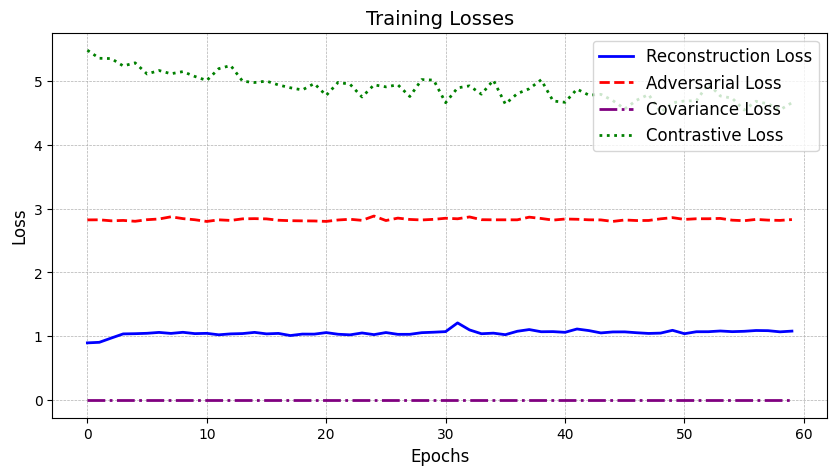

In [11]:
plt.figure(figsize=(10, 5))

# Plot both reconstruction and adversarial losses with different colors
plt.plot(reconstruction_losses, label='Reconstruction Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(adversarial_losses, label='Adversarial Loss', color='red', linestyle='--', linewidth=2)
plt.plot(cov_losses, label='Covariance Loss', color='purple', linestyle='-.', linewidth=2)
plt.plot(contra_losses, label='Contrastive Loss', color='green', linestyle=':', linewidth=2)

# Title and labels
plt.title(f"Training Losses", fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

# Add a grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


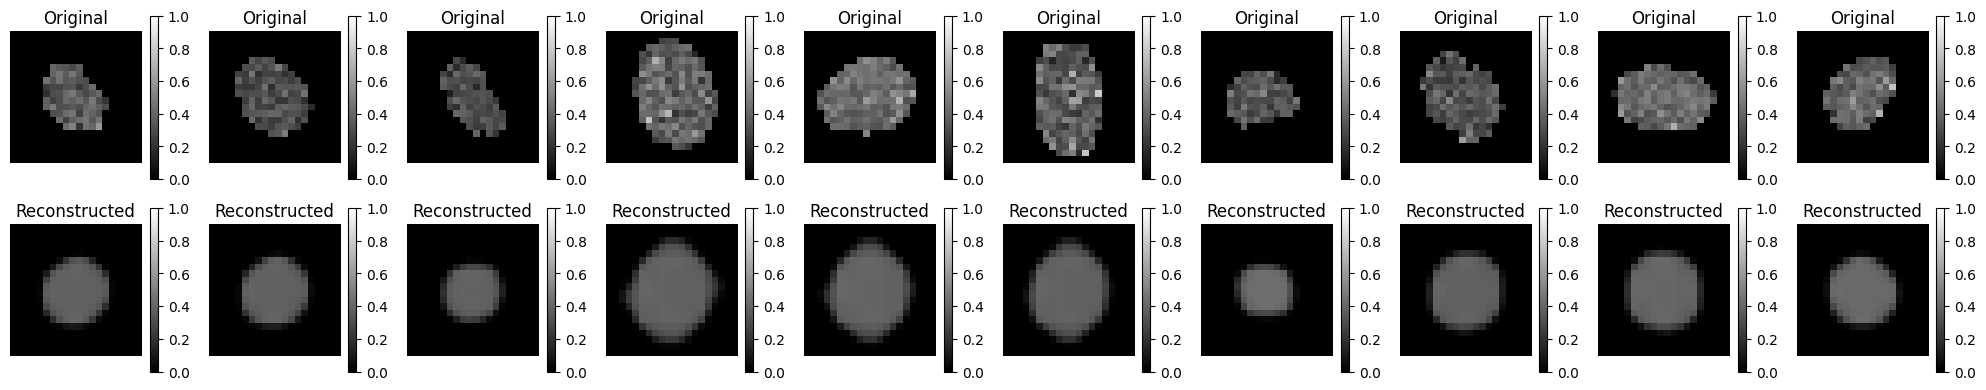

In [12]:
z_imgs = encoder.predict(train_images_augmented[:,0,:,:])
recon_imgs = decoder.predict(z_imgs)

reconstruction_images(train_images_augmented[:,0,:,:], recon_imgs)

Top correlated features: 0, 1


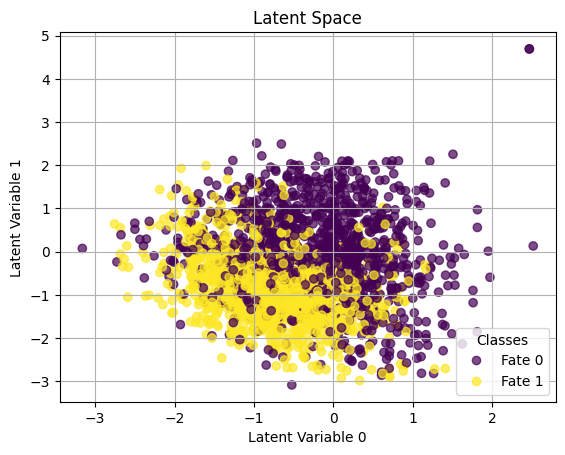

In [14]:
visualize_latent_space(z_imgs, train_labels_augmented)

#### 3. Classify with MLP 

In [15]:
config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
}

In [16]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

In [17]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim']) #[:, [3, 8]] 

x_test = test_images[:,0,:,:]
y_test = test_labels
x_train = train_images_augmented[:,0,:,:]
y_train = train_labels_augmented
# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6313 - loss: 0.6932 - val_accuracy: 0.4493 - val_loss: 0.8018
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6565 - loss: 0.6527 - val_accuracy: 0.4928 - val_loss: 0.7505
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6697 - loss: 0.6269 - val_accuracy: 0.5145 - val_loss: 0.7113
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6913 - loss: 0.6024 - val_accuracy: 0.5580 - val_loss: 0.6818
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6909 - loss: 0.5925 - val_accuracy: 0.5942 - val_loss: 0.6628
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7064 - loss: 0.5846 - val_accuracy: 0.6159 - val_loss: 0.6452
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6865 - loss: 0.5959 - val_accuracy: 0.6232 - val_loss: 0.6339
Epoch 8/50
73/73 ━━━━━━━━━━━━━

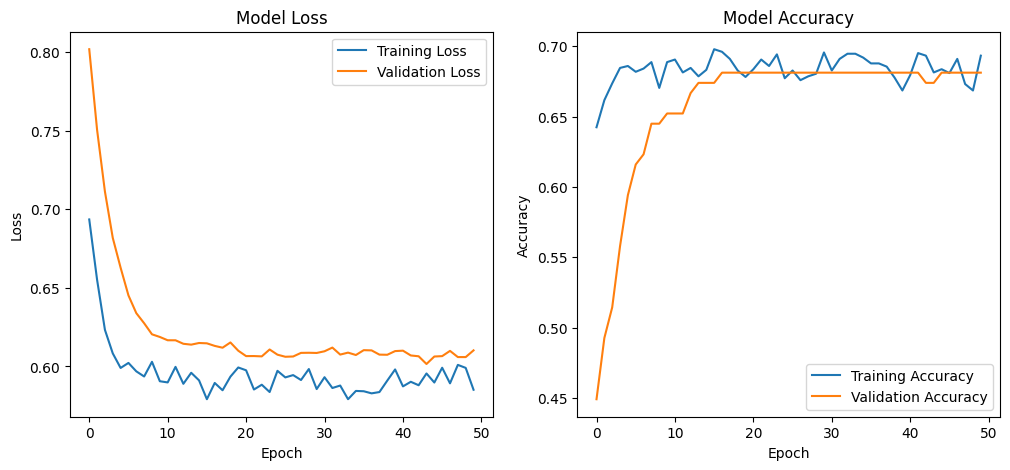

In [18]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.65765766 0.34234234]
 [0.21428571 0.78571429]]


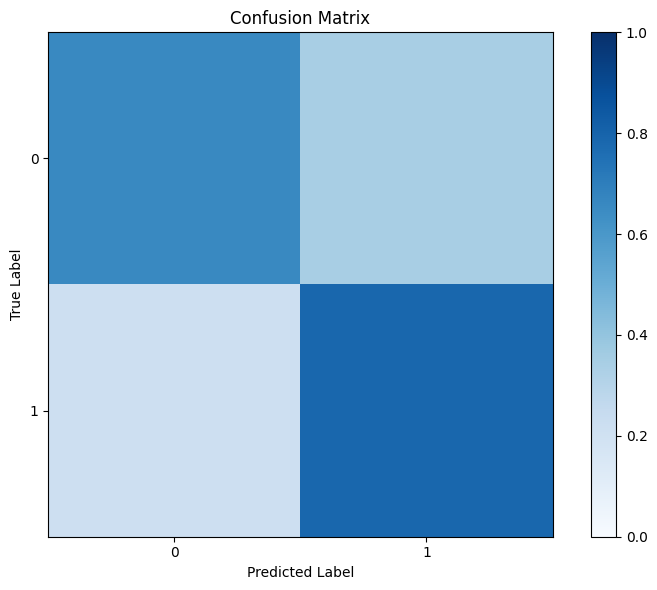

In [19]:
#### LAMBDA CONTRASTIVE LOSS = 4

num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### 5. Temporal study

In [3]:
### we need to go in range for all time points of the input data, and for each we do 3 different seeds ###
seeds = [42, 43, 44]
all_confusion_matrices_cellfate = np.zeros((11, 2, 2))
def temporal_study(train_images_augmented=train_images_augmented, train_labels_augmented=train_labels_augmented, test_images=test_images, test_labels=test_labels, seed = 44):
    mean_diagonals = np.zeros((train_images_augmented.shape[1]))
    precisions = np.zeros((train_images_augmented.shape[1]))

    for i in range(5,train_images_augmented.shape[1]):
        x_train = train_images_augmented[:,i,:,:]
        y_train = train_labels_augmented
        x_test = test_images[:,i,:,:]
        y_test = test_labels

        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }
        # do I need to restart the encoder and decoder??
        results_ae = train_autoencoder(config_ae, x_train)
        encoder = results_ae['encoder']
        decoder = results_ae['decoder']
        discriminator = results_ae['discriminator']

        ## TO CHECK if the break works
        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        num_classes = len(np.unique(y_train))
        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

        mean_diagonals[i] = mean_diagonal
        precisions[i] = precision
        all_confusion_matrices_cellfate[i] = conf_matrix_normalized

        #np.save(f"mean_diagonals_{i}.npy", mean_diagonals)
        #np.save(f"precisions_{i}.npy", precisions)
        np.save(f"all_confusion_matrices_cellfate_seed44_{i}.npy", all_confusion_matrices_cellfate)

        print("time point:", i, "conf matrix:", conf_matrix_normalized, "precision:", precision, "mean diagonal:", mean_diagonal)
    
    return mean_diagonals, precisions, all_confusion_matrices_cellfate

In [4]:
diagonals, precisions, conf_matrices = temporal_study()

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 44, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4547, Adversarial loss: 0.7646, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8634, Adversarial loss: 0.7247, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8096, Adversarial loss: 0.7177, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8044, Adversarial loss: 0.7109, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7864, Adversarial loss: 0.6998, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7931, Adversarial loss: 0.7008, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7691, Adversarial loss: 0.7040, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7843, Adversarial loss: 0.6997, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7846, Adversarial loss: 0.6997, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5832 - loss: 0.7069 - val_accuracy: 0.3986 - val_loss: 0.7846
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5738 - loss: 0.6877 - val_accuracy: 0.4783 - val_loss: 0.7428
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.5731 - loss: 0.6826 - val_accuracy: 0.5000 - val_loss: 0.7198
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5807 - loss: 0.6798 - val_accuracy: 0.5000 - val_loss: 0.7040
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.5873 - loss: 0.6722 - val_accuracy: 0.5507 - val_loss: 0.6932
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.5818 - loss: 0.6770 - val_accuracy: 0.5942 - val_loss: 0.6840
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6162 - loss: 0.6640 - val_accuracy: 0.5942 - val_loss: 0.6824
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.6155 - loss: 0.6649 - val_accuracy: 0.60

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3956 - loss: 1.1101 - val_accuracy: 0.3551 - val_loss: 1.1336
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.4051 - loss: 1.0347 - val_accuracy: 0.3406 - val_loss: 1.0485
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4248 - loss: 0.9418 - val_accuracy: 0.3478 - val_loss: 0.9688
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4356 - loss: 0.8682 - val_accuracy: 0.3696 - val_loss: 0.9006
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.4577 - loss: 0.8166 - val_accuracy: 0.3913 - val_loss: 0.8414
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4421 - loss: 0.7753 - val_accuracy: 0.4348 - val_loss: 0.7926
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - accuracy: 0.4578 - loss: 0.7412 - val_accuracy: 0.4493 - val_loss: 0.7499
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4938 - loss: 0.7066 - val_accuracy: 0.44

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4937 - loss: 1.3866 - val_accuracy: 0.4348 - val_loss: 1.3396
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5479 - loss: 1.2175 - val_accuracy: 0.4493 - val_loss: 1.2355
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5674 - loss: 1.0910 - val_accuracy: 0.4710 - val_loss: 1.1386
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.5654 - loss: 1.1025 - val_accuracy: 0.4928 - val_loss: 1.0484
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5608 - loss: 1.0154 - val_accuracy: 0.5145 - val_loss: 0.9713
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.5523 - loss: 0.9876 - val_accuracy: 0.5290 - val_loss: 0.8982
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5491 - loss: 0.9314 - val_accuracy: 0.5580 - val_loss: 0.8309
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5774 - loss: 0.8853 - val_accuracy: 0.57

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6932 - loss: 0.5941 - val_accuracy: 0.6884 - val_loss: 0.6417
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step - accuracy: 0.7128 - loss: 0.5649 - val_accuracy: 0.6884 - val_loss: 0.6240
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7306 - loss: 0.5439 - val_accuracy: 0.7029 - val_loss: 0.6114
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7040 - loss: 0.5641 - val_accuracy: 0.7101 - val_loss: 0.6004
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7066 - loss: 0.5729 - val_accuracy: 0.7101 - val_loss: 0.5923
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6875 - loss: 0.5797 - val_accuracy: 0.7101 - val_loss: 0.5850
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.7226 - loss: 0.5504 - val_accuracy: 0.7101 - val_loss: 0.5820
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.7243 - loss: 0.5455 - val_accuracy: 0.71

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7198 - loss: 0.5867 - val_accuracy: 0.6884 - val_loss: 0.6325
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.7272 - loss: 0.5920 - val_accuracy: 0.6812 - val_loss: 0.6144
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.7069 - loss: 0.5821 - val_accuracy: 0.6812 - val_loss: 0.6017
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.7190 - loss: 0.5815 - val_accuracy: 0.6812 - val_loss: 0.5914
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7034 - loss: 0.5672 - val_accuracy: 0.6884 - val_loss: 0.5831
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7296 - loss: 0.5562 - val_accuracy: 0.6884 - val_loss: 0.5724
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7237 - loss: 0.5553 - val_accuracy: 0.6957 - val_loss: 0.5682
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.7090 - loss: 0.5576 - val_accuracy: 0.69

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4153 - loss: 0.7140 - val_accuracy: 0.6377 - val_loss: 0.6681
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.5451 - loss: 0.6766 - val_accuracy: 0.7319 - val_loss: 0.6438
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6513 - loss: 0.6461 - val_accuracy: 0.7464 - val_loss: 0.6268
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7088 - loss: 0.6205 - val_accuracy: 0.7609 - val_loss: 0.6120
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6878 - loss: 0.6063 - val_accuracy: 0.7754 - val_loss: 0.6011
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7012 - loss: 0.5974 - val_accuracy: 0.7681 - val_loss: 0.5948
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.7238 - loss: 0.5779 - val_accuracy: 0.7536 - val_loss: 0.5860
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7194 - loss: 0.5699 - val_accuracy: 0.75

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2755 - loss: 1.5993 - val_accuracy: 0.3913 - val_loss: 1.0834
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.2834 - loss: 1.4142 - val_accuracy: 0.3913 - val_loss: 1.0521
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.2685 - loss: 1.3404 - val_accuracy: 0.3986 - val_loss: 1.0218
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2879 - loss: 1.2291 - val_accuracy: 0.3913 - val_loss: 0.9934
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3120 - loss: 1.1445 - val_accuracy: 0.3768 - val_loss: 0.9619
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3148 - loss: 1.0576 - val_accuracy: 0.3478 - val_loss: 0.9325
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3354 - loss: 0.9834 - val_accuracy: 0.3478 - val_loss: 0.9022
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.3626 - loss: 0.9156 - val_accuracy: 0.34

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7679 - loss: 0.5257 - val_accuracy: 0.6522 - val_loss: 0.6192
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 0.7701 - loss: 0.5141 - val_accuracy: 0.6594 - val_loss: 0.6141
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7596 - loss: 0.5110 - val_accuracy: 0.6739 - val_loss: 0.6101
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.7604 - loss: 0.5070 - val_accuracy: 0.6739 - val_loss: 0.6064
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.7634 - loss: 0.5050 - val_accuracy: 0.6739 - val_loss: 0.6051
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.7621 - loss: 0.5086 - val_accuracy: 0.7029 - val_loss: 0.6029
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7676 - loss: 0.5096 - val_accuracy: 0.7029 - val_loss: 0.6024
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7778 - loss: 0.4973 - val_accuracy: 0.70

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4044 - loss: 1.3583 - val_accuracy: 0.3913 - val_loss: 1.0416
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4360 - loss: 1.2611 - val_accuracy: 0.4058 - val_loss: 0.9951
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.4307 - loss: 1.1909 - val_accuracy: 0.4203 - val_loss: 0.9514
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4407 - loss: 1.1409 - val_accuracy: 0.4420 - val_loss: 0.9077
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.4737 - loss: 1.0299 - val_accuracy: 0.4638 - val_loss: 0.8688
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4687 - loss: 0.9886 - val_accuracy: 0.4710 - val_loss: 0.8309
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.4737 - loss: 0.9368 - val_accuracy: 0.5145 - val_loss: 0.7958
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5015 - loss: 0.8575 - val_accuracy: 0.53

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4099 - loss: 1.3606 - val_accuracy: 0.4275 - val_loss: 1.0310
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.3941 - loss: 1.2841 - val_accuracy: 0.4638 - val_loss: 0.9664
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.4192 - loss: 1.2014 - val_accuracy: 0.4783 - val_loss: 0.9169
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4188 - loss: 1.1516 - val_accuracy: 0.4928 - val_loss: 0.8700
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4305 - loss: 1.0840 - val_accuracy: 0.5000 - val_loss: 0.8284
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4433 - loss: 1.0362 - val_accuracy: 0.5290 - val_loss: 0.7923
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4440 - loss: 0.9821 - val_accuracy: 0.5435 - val_loss: 0.7595
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4556 - loss: 0.9161 - val_accuracy: 0.56

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6981 - loss: 0.5596 - val_accuracy: 0.6449 - val_loss: 0.6415
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - accuracy: 0.7470 - loss: 0.5514 - val_accuracy: 0.6449 - val_loss: 0.6440
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7675 - loss: 0.5242 - val_accuracy: 0.6377 - val_loss: 0.6470
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7369 - loss: 0.5291 - val_accuracy: 0.6232 - val_loss: 0.6453
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7570 - loss: 0.5146 - val_accuracy: 0.6232 - val_loss: 0.6420
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7678 - loss: 0.5196 - val_accuracy: 0.6087 - val_loss: 0.6417
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.7565 - loss: 0.5149 - val_accuracy: 0.6087 - val_loss: 0.6407
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7658 - loss: 0.4928 - val_accuracy: 0.60

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3807 - loss: 1.1144 - val_accuracy: 0.3043 - val_loss: 1.0225
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.4302 - loss: 1.0199 - val_accuracy: 0.3768 - val_loss: 0.9315
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.4270 - loss: 0.9555 - val_accuracy: 0.4275 - val_loss: 0.8519
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4704 - loss: 0.8614 - val_accuracy: 0.4638 - val_loss: 0.7915
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4818 - loss: 0.8034 - val_accuracy: 0.5217 - val_loss: 0.7417
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5135 - loss: 0.7729 - val_accuracy: 0.6014 - val_loss: 0.6969
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5588 - loss: 0.7094 - val_accuracy: 0.6594 - val_loss: 0.6636
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.5972 - loss: 0.6748 - val_accuracy: 0.69

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5191 - loss: 1.1061 - val_accuracy: 0.4928 - val_loss: 1.0451
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5205 - loss: 1.0674 - val_accuracy: 0.5435 - val_loss: 0.9602
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.5226 - loss: 0.9587 - val_accuracy: 0.5797 - val_loss: 0.8917
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.5356 - loss: 0.9589 - val_accuracy: 0.6232 - val_loss: 0.8299
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5285 - loss: 0.9039 - val_accuracy: 0.6449 - val_loss: 0.7793
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5472 - loss: 0.8503 - val_accuracy: 0.6594 - val_loss: 0.7347
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5502 - loss: 0.8044 - val_accuracy: 0.6667 - val_loss: 0.6985
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5705 - loss: 0.7696 - val_accuracy: 0.68

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2591 - loss: 1.3847 - val_accuracy: 0.4275 - val_loss: 1.0028
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.2440 - loss: 1.3053 - val_accuracy: 0.3986 - val_loss: 0.9624
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.2590 - loss: 1.1716 - val_accuracy: 0.3841 - val_loss: 0.9242
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.2370 - loss: 1.0858 - val_accuracy: 0.3768 - val_loss: 0.8845
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.2484 - loss: 0.9862 - val_accuracy: 0.3768 - val_loss: 0.8476
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.2633 - loss: 0.8998 - val_accuracy: 0.3406 - val_loss: 0.8121
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.2476 - loss: 0.8363 - val_accuracy: 0.2971 - val_loss: 0.7797
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.2766 - loss: 0.7792 - val_accuracy: 0.22

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4676 - loss: 1.0422 - val_accuracy: 0.3986 - val_loss: 0.9950
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4911 - loss: 0.9561 - val_accuracy: 0.4130 - val_loss: 0.9383
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5079 - loss: 0.9048 - val_accuracy: 0.4275 - val_loss: 0.8886
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.5225 - loss: 0.8336 - val_accuracy: 0.4420 - val_loss: 0.8425
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5323 - loss: 0.7632 - val_accuracy: 0.4783 - val_loss: 0.8037
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5616 - loss: 0.7155 - val_accuracy: 0.5362 - val_loss: 0.7709
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5780 - loss: 0.6805 - val_accuracy: 0.5652 - val_loss: 0.7413
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - accuracy: 0.5868 - loss: 0.6479 - val_accuracy: 0.59

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2249 - loss: 1.1401 - val_accuracy: 0.3913 - val_loss: 0.8109
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.2122 - loss: 1.0231 - val_accuracy: 0.3696 - val_loss: 0.7851
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.2332 - loss: 0.9052 - val_accuracy: 0.3188 - val_loss: 0.7615
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.2058 - loss: 0.8220 - val_accuracy: 0.2971 - val_loss: 0.7389
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.2817 - loss: 0.7428 - val_accuracy: 0.2899 - val_loss: 0.7164
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.5568 - loss: 0.6856 - val_accuracy: 0.5580 - val_loss: 0.6971
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7246 - loss: 0.6355 - val_accuracy: 0.5797 - val_loss: 0.6812
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.7675 - loss: 0.6025 - val_accuracy: 0.58

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7456 - loss: 0.5233 - val_accuracy: 0.5652 - val_loss: 0.7948
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7081 - loss: 0.5306 - val_accuracy: 0.5942 - val_loss: 0.7598
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.7532 - loss: 0.4878 - val_accuracy: 0.6159 - val_loss: 0.7304
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.7499 - loss: 0.4987 - val_accuracy: 0.6304 - val_loss: 0.7103
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7423 - loss: 0.4877 - val_accuracy: 0.6377 - val_loss: 0.6930
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7641 - loss: 0.4873 - val_accuracy: 0.6449 - val_loss: 0.6793
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.7589 - loss: 0.4828 - val_accuracy: 0.6449 - val_loss: 0.6696
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.7803 - loss: 0.4668 - val_accuracy: 0.64

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4802, Adversarial loss: 0.7479, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8927, Adversarial loss: 0.7287, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8382, Adversarial loss: 0.7106, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8243, Adversarial loss: 0.7133, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8028, Adversarial loss: 0.6980, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8036, Adversarial loss: 0.7014, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8032, Adversarial loss: 0.7072, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7866, Adversarial loss: 0.7040, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8148, Adversarial loss: 0.7012, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_28 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7220 - loss: 0.5715 - val_accuracy: 0.7174 - val_loss: 0.5492
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.7475 - loss: 0.5391 - val_accuracy: 0.7101 - val_loss: 0.5386
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.7504 - loss: 0.5333 - val_accuracy: 0.7029 - val_loss: 0.5353
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7260 - loss: 0.5344 - val_accuracy: 0.7029 - val_loss: 0.5307
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7510 - loss: 0.5198 - val_accuracy: 0.7029 - val_loss: 0.5290
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7227 - loss: 0.5456 - val_accuracy: 0.7029 - val_loss: 0.5273
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7249 - loss: 0.5207 - val_accuracy: 0.7029 - val_loss: 0.5264
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.7216 - loss: 0.5234 - val_accuracy: 0.70

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_29 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6114 - loss: 0.7130 - val_accuracy: 0.4275 - val_loss: 0.8750
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - accuracy: 0.6461 - loss: 0.6725 - val_accuracy: 0.4855 - val_loss: 0.8005
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6561 - loss: 0.6498 - val_accuracy: 0.5580 - val_loss: 0.7384
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6556 - loss: 0.6396 - val_accuracy: 0.6232 - val_loss: 0.6901
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6721 - loss: 0.6072 - val_accuracy: 0.6667 - val_loss: 0.6560
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6627 - loss: 0.6050 - val_accuracy: 0.6739 - val_loss: 0.6295
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6617 - loss: 0.5989 - val_accuracy: 0.6957 - val_loss: 0.6075
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6690 - loss: 0.5839 - val_accuracy: 0.70

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_30 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2836 - loss: 1.7303 - val_accuracy: 0.2826 - val_loss: 1.5805
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.3021 - loss: 1.5754 - val_accuracy: 0.2899 - val_loss: 1.4586
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.2892 - loss: 1.5174 - val_accuracy: 0.3043 - val_loss: 1.3450
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3018 - loss: 1.4037 - val_accuracy: 0.3333 - val_loss: 1.2456
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3200 - loss: 1.2860 - val_accuracy: 0.3333 - val_loss: 1.1674
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3187 - loss: 1.2532 - val_accuracy: 0.3623 - val_loss: 1.0919
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3033 - loss: 1.1890 - val_accuracy: 0.3696 - val_loss: 1.0260
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3280 - loss: 1.1307 - val_accuracy: 0.36

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_31 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6975 - loss: 0.6460 - val_accuracy: 0.6449 - val_loss: 0.6667
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7223 - loss: 0.5919 - val_accuracy: 0.6667 - val_loss: 0.6404
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7334 - loss: 0.5740 - val_accuracy: 0.6739 - val_loss: 0.6215
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7325 - loss: 0.5643 - val_accuracy: 0.6884 - val_loss: 0.6047
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7349 - loss: 0.5420 - val_accuracy: 0.6957 - val_loss: 0.5926
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7420 - loss: 0.5254 - val_accuracy: 0.6884 - val_loss: 0.5836
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.7624 - loss: 0.5119 - val_accuracy: 0.6812 - val_loss: 0.5742
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.7684 - loss: 0.4910 - val_accuracy: 0.68

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7208 - loss: 0.6098 - val_accuracy: 0.5870 - val_loss: 0.7880
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.7205 - loss: 0.5937 - val_accuracy: 0.6087 - val_loss: 0.7337
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.7234 - loss: 0.5941 - val_accuracy: 0.6087 - val_loss: 0.6862
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7343 - loss: 0.5730 - val_accuracy: 0.6232 - val_loss: 0.6495
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.7311 - loss: 0.5441 - val_accuracy: 0.6377 - val_loss: 0.6215
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.7456 - loss: 0.5371 - val_accuracy: 0.6594 - val_loss: 0.5907
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.7277 - loss: 0.5392 - val_accuracy: 0.6667 - val_loss: 0.5748
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.7464 - loss: 0.5138 - val_accuracy: 0.68

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 0.6728 - val_accuracy: 0.6014 - val_loss: 0.6723
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6945 - loss: 0.6303 - val_accuracy: 0.6449 - val_loss: 0.6479
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.7467 - loss: 0.5930 - val_accuracy: 0.6594 - val_loss: 0.6294
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.7692 - loss: 0.5739 - val_accuracy: 0.6667 - val_loss: 0.6133
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7520 - loss: 0.5586 - val_accuracy: 0.6667 - val_loss: 0.6022
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7507 - loss: 0.5423 - val_accuracy: 0.6739 - val_loss: 0.5919
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7359 - loss: 0.5412 - val_accuracy: 0.6812 - val_loss: 0.5852
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.7527 - loss: 0.5255 - val_accuracy: 0.68

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3107 - loss: 1.3995 - val_accuracy: 0.3043 - val_loss: 1.2494
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3168 - loss: 1.2305 - val_accuracy: 0.3333 - val_loss: 1.1605
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3268 - loss: 1.1450 - val_accuracy: 0.3261 - val_loss: 1.0793
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3197 - loss: 1.0670 - val_accuracy: 0.3551 - val_loss: 1.0001
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.3271 - loss: 0.9662 - val_accuracy: 0.3913 - val_loss: 0.9259
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.4938 - loss: 0.8882 - val_accuracy: 0.4130 - val_loss: 0.8619
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5461 - loss: 0.8185 - val_accuracy: 0.4565 - val_loss: 0.8054
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5609 - loss: 0.7593 - val_accuracy: 0.50

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_35 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7480 - loss: 0.5607 - val_accuracy: 0.6957 - val_loss: 0.5888
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.7341 - loss: 0.5458 - val_accuracy: 0.7101 - val_loss: 0.5725
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.7399 - loss: 0.5366 - val_accuracy: 0.7319 - val_loss: 0.5589
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.7291 - loss: 0.5393 - val_accuracy: 0.7464 - val_loss: 0.5503
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.7257 - loss: 0.5402 - val_accuracy: 0.7464 - val_loss: 0.5503
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.7250 - loss: 0.5447 - val_accuracy: 0.7464 - val_loss: 0.5483
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.7313 - loss: 0.5364 - val_accuracy: 0.7536 - val_loss: 0.5472
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.7439 - loss: 0.5246 - val_accuracy: 0.74

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_36 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3401 - loss: 1.1251 - val_accuracy: 0.3986 - val_loss: 0.9078
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3297 - loss: 1.0538 - val_accuracy: 0.3768 - val_loss: 0.8873
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3557 - loss: 0.9994 - val_accuracy: 0.3986 - val_loss: 0.8639
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3688 - loss: 0.9444 - val_accuracy: 0.3841 - val_loss: 0.8371
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.4112 - loss: 0.8726 - val_accuracy: 0.3768 - val_loss: 0.8111
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4125 - loss: 0.8414 - val_accuracy: 0.3986 - val_loss: 0.7848
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.4384 - loss: 0.8070 - val_accuracy: 0.4783 - val_loss: 0.7610
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.4864 - loss: 0.7487 - val_accuracy: 0.50

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_37 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3599 - loss: 1.3103 - val_accuracy: 0.3116 - val_loss: 1.0075
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3818 - loss: 1.2199 - val_accuracy: 0.3478 - val_loss: 0.9493
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3787 - loss: 1.1179 - val_accuracy: 0.3768 - val_loss: 0.8982
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4046 - loss: 1.0700 - val_accuracy: 0.4275 - val_loss: 0.8537
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4514 - loss: 0.9698 - val_accuracy: 0.4275 - val_loss: 0.8150
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.4631 - loss: 0.9376 - val_accuracy: 0.4638 - val_loss: 0.7804
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.4611 - loss: 0.8948 - val_accuracy: 0.4855 - val_loss: 0.7486
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.4849 - loss: 0.8373 - val_accuracy: 0.54

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_38 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7199 - loss: 0.5267 - val_accuracy: 0.5652 - val_loss: 0.8047
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.7340 - loss: 0.5171 - val_accuracy: 0.5870 - val_loss: 0.7497
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.7425 - loss: 0.4961 - val_accuracy: 0.6304 - val_loss: 0.7081
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7447 - loss: 0.4966 - val_accuracy: 0.6377 - val_loss: 0.6784
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7431 - loss: 0.4974 - val_accuracy: 0.6667 - val_loss: 0.6570
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.7262 - loss: 0.5078 - val_accuracy: 0.6812 - val_loss: 0.6393
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7462 - loss: 0.4963 - val_accuracy: 0.6957 - val_loss: 0.6283
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.7491 - loss: 0.4972 - val_accuracy: 0.69

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_39 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3122 - loss: 1.1448 - val_accuracy: 0.3478 - val_loss: 0.9529
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.3527 - loss: 1.0417 - val_accuracy: 0.3478 - val_loss: 0.9058
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3328 - loss: 0.9978 - val_accuracy: 0.3623 - val_loss: 0.8601
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3815 - loss: 0.9116 - val_accuracy: 0.3841 - val_loss: 0.8206
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3873 - loss: 0.8673 - val_accuracy: 0.4203 - val_loss: 0.7833
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4059 - loss: 0.8201 - val_accuracy: 0.5000 - val_loss: 0.7480
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4391 - loss: 0.7602 - val_accuracy: 0.5435 - val_loss: 0.7174
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4757 - loss: 0.7218 - val_accuracy: 0.60

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_40 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2764 - loss: 1.7854 - val_accuracy: 0.3696 - val_loss: 1.0960
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.2508 - loss: 1.6967 - val_accuracy: 0.3623 - val_loss: 1.0593
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.2690 - loss: 1.5443 - val_accuracy: 0.3551 - val_loss: 1.0256
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.2584 - loss: 1.4666 - val_accuracy: 0.3188 - val_loss: 0.9901
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.2851 - loss: 1.3204 - val_accuracy: 0.3043 - val_loss: 0.9563
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.2651 - loss: 1.2630 - val_accuracy: 0.2971 - val_loss: 0.9211
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.2769 - loss: 1.1225 - val_accuracy: 0.2826 - val_loss: 0.8898
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.2580 - loss: 1.0578 - val_accuracy: 0.28

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_41 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2837 - loss: 1.3891 - val_accuracy: 0.3188 - val_loss: 1.0933
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.2663 - loss: 1.3091 - val_accuracy: 0.3043 - val_loss: 1.0281
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.2720 - loss: 1.1733 - val_accuracy: 0.2971 - val_loss: 0.9682
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.2668 - loss: 1.0881 - val_accuracy: 0.2826 - val_loss: 0.9085
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.2927 - loss: 0.9877 - val_accuracy: 0.3043 - val_loss: 0.8594
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.2871 - loss: 0.9118 - val_accuracy: 0.2826 - val_loss: 0.8122
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.2941 - loss: 0.8413 - val_accuracy: 0.2899 - val_loss: 0.7740
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3419 - loss: 0.7804 - val_accuracy: 0.34

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_42 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5117 - loss: 0.7809 - val_accuracy: 0.6594 - val_loss: 0.6156
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5521 - loss: 0.7274 - val_accuracy: 0.6884 - val_loss: 0.5958
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5873 - loss: 0.6902 - val_accuracy: 0.7174 - val_loss: 0.5816
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5988 - loss: 0.6649 - val_accuracy: 0.7319 - val_loss: 0.5718
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6461 - loss: 0.6220 - val_accuracy: 0.7246 - val_loss: 0.5641
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6666 - loss: 0.5958 - val_accuracy: 0.7464 - val_loss: 0.5538
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6489 - loss: 0.6052 - val_accuracy: 0.7609 - val_loss: 0.5475
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6703 - loss: 0.5898 - val_accuracy: 0.75

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_43 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2385 - loss: 1.1413 - val_accuracy: 0.2826 - val_loss: 0.8994
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.2605 - loss: 0.9993 - val_accuracy: 0.2826 - val_loss: 0.8450
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2618 - loss: 0.8907 - val_accuracy: 0.2754 - val_loss: 0.7976
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.2572 - loss: 0.8144 - val_accuracy: 0.2971 - val_loss: 0.7542
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3515 - loss: 0.7343 - val_accuracy: 0.3116 - val_loss: 0.7187
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6043 - loss: 0.6760 - val_accuracy: 0.5797 - val_loss: 0.6895
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7354 - loss: 0.6296 - val_accuracy: 0.6449 - val_loss: 0.6646
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.7785 - loss: 0.6018 - val_accuracy: 0.68

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_44 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7703 - loss: 0.4547 - val_accuracy: 0.6667 - val_loss: 0.7081
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.7557 - loss: 0.4595 - val_accuracy: 0.6594 - val_loss: 0.6967
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.7728 - loss: 0.4550 - val_accuracy: 0.6594 - val_loss: 0.6831
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.7402 - loss: 0.4760 - val_accuracy: 0.6594 - val_loss: 0.6762
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7592 - loss: 0.4482 - val_accuracy: 0.6594 - val_loss: 0.6699
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.7589 - loss: 0.4590 - val_accuracy: 0.6594 - val_loss: 0.6688
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7536 - loss: 0.4636 - val_accuracy: 0.6594 - val_loss: 0.6676
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.7733 - loss: 0.4457 - val_accuracy: 0.65

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4535, Adversarial loss: 0.7535, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8606, Adversarial loss: 0.7299, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8138, Adversarial loss: 0.7118, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.7870, Adversarial loss: 0.7219, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.7869, Adversarial loss: 0.7018, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.7907, Adversarial loss: 0.7037, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.7758, Adversarial loss: 0.7018, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.7729, Adversarial loss: 0.7020, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.7842, Adversarial loss: 0.6929, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_51 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3829 - loss: 0.8844 - val_accuracy: 0.3623 - val_loss: 0.8687
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3935 - loss: 0.8178 - val_accuracy: 0.3696 - val_loss: 0.7877
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3824 - loss: 0.7574 - val_accuracy: 0.3768 - val_loss: 0.7328
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4267 - loss: 0.7187 - val_accuracy: 0.4638 - val_loss: 0.6947
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5057 - loss: 0.6939 - val_accuracy: 0.6449 - val_loss: 0.6664
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5856 - loss: 0.6753 - val_accuracy: 0.6812 - val_loss: 0.6495
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6121 - loss: 0.6620 - val_accuracy: 0.6594 - val_loss: 0.6387
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6166 - loss: 0.6519 - val_accuracy: 0.63

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_52 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5963 - loss: 0.8547 - val_accuracy: 0.4348 - val_loss: 1.0271
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.5902 - loss: 0.7773 - val_accuracy: 0.4565 - val_loss: 0.9096
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5977 - loss: 0.7341 - val_accuracy: 0.4928 - val_loss: 0.8165
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6025 - loss: 0.7153 - val_accuracy: 0.5362 - val_loss: 0.7440
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.5941 - loss: 0.6906 - val_accuracy: 0.5652 - val_loss: 0.6963
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6004 - loss: 0.6750 - val_accuracy: 0.5942 - val_loss: 0.6605
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5877 - loss: 0.6663 - val_accuracy: 0.6014 - val_loss: 0.6386
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6108 - loss: 0.6523 - val_accuracy: 0.63

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_53 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5719 - loss: 1.1186 - val_accuracy: 0.5652 - val_loss: 1.0275
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.5630 - loss: 1.0420 - val_accuracy: 0.5870 - val_loss: 0.9401
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.5796 - loss: 0.9454 - val_accuracy: 0.6087 - val_loss: 0.8690
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5820 - loss: 0.9106 - val_accuracy: 0.6159 - val_loss: 0.8114
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5940 - loss: 0.8409 - val_accuracy: 0.6232 - val_loss: 0.7650
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.5894 - loss: 0.8381 - val_accuracy: 0.6232 - val_loss: 0.7258
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5805 - loss: 0.8058 - val_accuracy: 0.6594 - val_loss: 0.6906
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6136 - loss: 0.7462 - val_accuracy: 0.65

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_54 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3730 - loss: 1.4442 - val_accuracy: 0.4493 - val_loss: 1.1555
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.3641 - loss: 1.3809 - val_accuracy: 0.4420 - val_loss: 1.1176
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3359 - loss: 1.3127 - val_accuracy: 0.4275 - val_loss: 1.0741
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3835 - loss: 1.1996 - val_accuracy: 0.4058 - val_loss: 1.0384
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3769 - loss: 1.1346 - val_accuracy: 0.3841 - val_loss: 1.0049
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3820 - loss: 1.0501 - val_accuracy: 0.3696 - val_loss: 0.9736
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3716 - loss: 1.0212 - val_accuracy: 0.3623 - val_loss: 0.9449
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3719 - loss: 0.9715 - val_accuracy: 0.35

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_55 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3882 - loss: 1.3648 - val_accuracy: 0.5072 - val_loss: 0.9529
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.4011 - loss: 1.2433 - val_accuracy: 0.4928 - val_loss: 0.9482
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.3785 - loss: 1.1625 - val_accuracy: 0.4928 - val_loss: 0.9422
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3683 - loss: 1.1252 - val_accuracy: 0.4638 - val_loss: 0.9339
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4017 - loss: 1.0272 - val_accuracy: 0.4493 - val_loss: 0.9275
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3377 - loss: 1.0062 - val_accuracy: 0.4348 - val_loss: 0.9195
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3656 - loss: 0.9397 - val_accuracy: 0.4058 - val_loss: 0.9051
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3683 - loss: 0.8898 - val_accuracy: 0.32

Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_56 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6106 - loss: 0.6555 - val_accuracy: 0.5580 - val_loss: 0.6657
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6407 - loss: 0.6393 - val_accuracy: 0.5870 - val_loss: 0.6531
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6490 - loss: 0.6349 - val_accuracy: 0.6232 - val_loss: 0.6443
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6499 - loss: 0.6325 - val_accuracy: 0.6304 - val_loss: 0.6370
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6246 - loss: 0.6402 - val_accuracy: 0.6304 - val_loss: 0.6306
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6366 - loss: 0.6355 - val_accuracy: 0.6304 - val_loss: 0.6264
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6495 - loss: 0.6303 - val_accuracy: 0.6377 - val_loss: 0.6237
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6432 - loss: 0.6328 - val_accuracy: 0.65

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_57 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6341 - loss: 0.6997 - val_accuracy: 0.6014 - val_loss: 0.6913
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6400 - loss: 0.6970 - val_accuracy: 0.6159 - val_loss: 0.6681
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6463 - loss: 0.6770 - val_accuracy: 0.6232 - val_loss: 0.6477
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6416 - loss: 0.6427 - val_accuracy: 0.6159 - val_loss: 0.6326
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6414 - loss: 0.6463 - val_accuracy: 0.6159 - val_loss: 0.6223
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6444 - loss: 0.6295 - val_accuracy: 0.6304 - val_loss: 0.6153
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6242 - loss: 0.6404 - val_accuracy: 0.6304 - val_loss: 0.6109
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6331 - loss: 0.6360 - val_accuracy: 0.63

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_58 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3721 - loss: 0.9517 - val_accuracy: 0.4130 - val_loss: 0.8851
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.3656 - loss: 0.8927 - val_accuracy: 0.4130 - val_loss: 0.8289
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.3843 - loss: 0.8225 - val_accuracy: 0.4203 - val_loss: 0.7867
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3706 - loss: 0.7804 - val_accuracy: 0.3986 - val_loss: 0.7506
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3820 - loss: 0.7405 - val_accuracy: 0.3406 - val_loss: 0.7236
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.4017 - loss: 0.7106 - val_accuracy: 0.3406 - val_loss: 0.7036
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5613 - loss: 0.6905 - val_accuracy: 0.5290 - val_loss: 0.6877
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6226 - loss: 0.6717 - val_accuracy: 0.57

Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_59 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4945 - loss: 0.9884 - val_accuracy: 0.5797 - val_loss: 0.8223
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5135 - loss: 0.8880 - val_accuracy: 0.5942 - val_loss: 0.7872
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.5649 - loss: 0.8493 - val_accuracy: 0.6014 - val_loss: 0.7534
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5843 - loss: 0.8143 - val_accuracy: 0.6159 - val_loss: 0.7283
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6072 - loss: 0.7699 - val_accuracy: 0.6377 - val_loss: 0.7075
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6033 - loss: 0.7535 - val_accuracy: 0.6377 - val_loss: 0.6892
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6180 - loss: 0.7194 - val_accuracy: 0.6304 - val_loss: 0.6720
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6122 - loss: 0.6908 - val_accuracy: 0.62

Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_60 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5203 - loss: 0.9346 - val_accuracy: 0.5000 - val_loss: 0.9149
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.5232 - loss: 0.8885 - val_accuracy: 0.5290 - val_loss: 0.8620
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5158 - loss: 0.8485 - val_accuracy: 0.5652 - val_loss: 0.8199
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5421 - loss: 0.8022 - val_accuracy: 0.5652 - val_loss: 0.7827
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.5115 - loss: 0.7991 - val_accuracy: 0.5507 - val_loss: 0.7515
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5638 - loss: 0.7401 - val_accuracy: 0.5652 - val_loss: 0.7245
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5674 - loss: 0.7319 - val_accuracy: 0.5797 - val_loss: 0.6998
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6170 - loss: 0.6783 - val_accuracy: 0.61

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_61 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4752 - loss: 1.2032 - val_accuracy: 0.2536 - val_loss: 1.4262
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4816 - loss: 1.0984 - val_accuracy: 0.2609 - val_loss: 1.2890
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.4820 - loss: 1.0625 - val_accuracy: 0.2754 - val_loss: 1.1606
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4903 - loss: 0.9740 - val_accuracy: 0.3261 - val_loss: 1.0536
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4950 - loss: 0.9095 - val_accuracy: 0.3623 - val_loss: 0.9644
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.4692 - loss: 0.8999 - val_accuracy: 0.3986 - val_loss: 0.8849
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5076 - loss: 0.8588 - val_accuracy: 0.4348 - val_loss: 0.8197
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5112 - loss: 0.8332 - val_accuracy: 0.49

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_62 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4448 - loss: 0.9864 - val_accuracy: 0.4855 - val_loss: 0.8446
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.4252 - loss: 0.9172 - val_accuracy: 0.5072 - val_loss: 0.7927
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4641 - loss: 0.8228 - val_accuracy: 0.5145 - val_loss: 0.7512
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.5265 - loss: 0.7743 - val_accuracy: 0.5580 - val_loss: 0.7162
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5486 - loss: 0.7271 - val_accuracy: 0.5870 - val_loss: 0.6892
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5731 - loss: 0.6887 - val_accuracy: 0.5797 - val_loss: 0.6702
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5991 - loss: 0.6614 - val_accuracy: 0.5797 - val_loss: 0.6572
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6349 - loss: 0.6437 - val_accuracy: 0.57

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_63 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4172 - loss: 1.4962 - val_accuracy: 0.4565 - val_loss: 1.0856
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4256 - loss: 1.4203 - val_accuracy: 0.4420 - val_loss: 1.0467
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4209 - loss: 1.3268 - val_accuracy: 0.4348 - val_loss: 1.0110
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4211 - loss: 1.2267 - val_accuracy: 0.4348 - val_loss: 0.9763
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4305 - loss: 1.1618 - val_accuracy: 0.4348 - val_loss: 0.9419
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4239 - loss: 1.0612 - val_accuracy: 0.4203 - val_loss: 0.9068
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4421 - loss: 0.9670 - val_accuracy: 0.4130 - val_loss: 0.8736
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.4277 - loss: 0.9268 - val_accuracy: 0.40

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_64 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6590 - loss: 0.7190 - val_accuracy: 0.5870 - val_loss: 0.7597
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6493 - loss: 0.7118 - val_accuracy: 0.5942 - val_loss: 0.7157
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6499 - loss: 0.6872 - val_accuracy: 0.6014 - val_loss: 0.6803
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6483 - loss: 0.6722 - val_accuracy: 0.5942 - val_loss: 0.6512
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6485 - loss: 0.6341 - val_accuracy: 0.6159 - val_loss: 0.6317
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6534 - loss: 0.6402 - val_accuracy: 0.6087 - val_loss: 0.6207
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6625 - loss: 0.6210 - val_accuracy: 0.6232 - val_loss: 0.6135
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6686 - loss: 0.6186 - val_accuracy: 0.62

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_65 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5774 - loss: 0.7233 - val_accuracy: 0.5362 - val_loss: 0.7691
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.5926 - loss: 0.6963 - val_accuracy: 0.5435 - val_loss: 0.7233
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6049 - loss: 0.6810 - val_accuracy: 0.5797 - val_loss: 0.6861
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6014 - loss: 0.6562 - val_accuracy: 0.5870 - val_loss: 0.6602
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5925 - loss: 0.6635 - val_accuracy: 0.6014 - val_loss: 0.6409
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6086 - loss: 0.6484 - val_accuracy: 0.6304 - val_loss: 0.6283
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6260 - loss: 0.6401 - val_accuracy: 0.6304 - val_loss: 0.6191
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6283 - loss: 0.6286 - val_accuracy: 0.63

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_66 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.6414 - val_accuracy: 0.6522 - val_loss: 0.6008
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6378 - loss: 0.6378 - val_accuracy: 0.6522 - val_loss: 0.5976
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6354 - loss: 0.6325 - val_accuracy: 0.6667 - val_loss: 0.5970
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6415 - loss: 0.6185 - val_accuracy: 0.6594 - val_loss: 0.5980
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6357 - loss: 0.6256 - val_accuracy: 0.6522 - val_loss: 0.5998
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6411 - loss: 0.6221 - val_accuracy: 0.6449 - val_loss: 0.6030
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6076 - loss: 0.6301 - val_accuracy: 0.6377 - val_loss: 0.6044
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6186 - loss: 0.6310 - val_accuracy: 0.62

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_67 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4888 - loss: 0.8906 - val_accuracy: 0.3768 - val_loss: 0.9163
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.4983 - loss: 0.8337 - val_accuracy: 0.3841 - val_loss: 0.8619
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5216 - loss: 0.8004 - val_accuracy: 0.4275 - val_loss: 0.8130
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5313 - loss: 0.7724 - val_accuracy: 0.4710 - val_loss: 0.7698
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5364 - loss: 0.7414 - val_accuracy: 0.4928 - val_loss: 0.7370
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5593 - loss: 0.7306 - val_accuracy: 0.5507 - val_loss: 0.7067
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5620 - loss: 0.7119 - val_accuracy: 0.5507 - val_loss: 0.6840
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6207 - loss: 0.6739 - val_accuracy: 0.60

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_68 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5191 - loss: 0.8037 - val_accuracy: 0.6087 - val_loss: 0.6557
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.5185 - loss: 0.7653 - val_accuracy: 0.6159 - val_loss: 0.6543
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.5469 - loss: 0.7467 - val_accuracy: 0.6159 - val_loss: 0.6540
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.5371 - loss: 0.7327 - val_accuracy: 0.6014 - val_loss: 0.6526
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5644 - loss: 0.6986 - val_accuracy: 0.6014 - val_loss: 0.6499
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5644 - loss: 0.6874 - val_accuracy: 0.6232 - val_loss: 0.6454
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5813 - loss: 0.6735 - val_accuracy: 0.6087 - val_loss: 0.6437
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.5972 - loss: 0.6679 - val_accuracy: 0.62

Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_69 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5266 - loss: 0.7414 - val_accuracy: 0.4275 - val_loss: 0.7601
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.5546 - loss: 0.7063 - val_accuracy: 0.5217 - val_loss: 0.7220
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5734 - loss: 0.6976 - val_accuracy: 0.5580 - val_loss: 0.6924
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5864 - loss: 0.6706 - val_accuracy: 0.6014 - val_loss: 0.6709
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6267 - loss: 0.6497 - val_accuracy: 0.6087 - val_loss: 0.6567
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6077 - loss: 0.6527 - val_accuracy: 0.6449 - val_loss: 0.6441
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6394 - loss: 0.6401 - val_accuracy: 0.6594 - val_loss: 0.6338
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6354 - loss: 0.6333 - val_accuracy: 0.65

Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_70 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3804 - loss: 0.9698 - val_accuracy: 0.3841 - val_loss: 0.8426
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.3844 - loss: 0.8917 - val_accuracy: 0.3841 - val_loss: 0.8184
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3801 - loss: 0.8374 - val_accuracy: 0.4058 - val_loss: 0.7960
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3883 - loss: 0.8112 - val_accuracy: 0.3696 - val_loss: 0.7718
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3913 - loss: 0.7673 - val_accuracy: 0.3768 - val_loss: 0.7499
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4356 - loss: 0.7338 - val_accuracy: 0.3986 - val_loss: 0.7283
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4624 - loss: 0.7103 - val_accuracy: 0.4638 - val_loss: 0.7095
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.5405 - loss: 0.6925 - val_accuracy: 0.55

Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_71 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4786 - loss: 1.0650 - val_accuracy: 0.3406 - val_loss: 1.0244
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.4694 - loss: 0.9946 - val_accuracy: 0.3478 - val_loss: 0.9627
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4670 - loss: 0.9333 - val_accuracy: 0.3551 - val_loss: 0.9091
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4797 - loss: 0.9214 - val_accuracy: 0.4275 - val_loss: 0.8588
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.4887 - loss: 0.8544 - val_accuracy: 0.4565 - val_loss: 0.8143
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5150 - loss: 0.8122 - val_accuracy: 0.4855 - val_loss: 0.7787
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5343 - loss: 0.7772 - val_accuracy: 0.5145 - val_loss: 0.7498
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5373 - loss: 0.7642 - val_accuracy: 0.55

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_72 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4442 - loss: 1.6779 - val_accuracy: 0.3478 - val_loss: 1.7159
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.4458 - loss: 1.5862 - val_accuracy: 0.3551 - val_loss: 1.5339
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4556 - loss: 1.4235 - val_accuracy: 0.3623 - val_loss: 1.3701
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.4370 - loss: 1.4185 - val_accuracy: 0.3696 - val_loss: 1.2251
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4706 - loss: 1.2352 - val_accuracy: 0.3913 - val_loss: 1.1080
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.4837 - loss: 1.1510 - val_accuracy: 0.4783 - val_loss: 1.0088
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.4819 - loss: 1.1139 - val_accuracy: 0.5145 - val_loss: 0.9226
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4766 - loss: 1.0657 - val_accuracy: 0.52

Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_73 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5054 - loss: 0.7410 - val_accuracy: 0.5362 - val_loss: 0.7090
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5121 - loss: 0.7160 - val_accuracy: 0.5797 - val_loss: 0.6991
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5392 - loss: 0.6874 - val_accuracy: 0.6014 - val_loss: 0.6915
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5940 - loss: 0.6559 - val_accuracy: 0.5942 - val_loss: 0.6838
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6506 - loss: 0.6455 - val_accuracy: 0.5725 - val_loss: 0.6757
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6700 - loss: 0.6352 - val_accuracy: 0.5797 - val_loss: 0.6678
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6764 - loss: 0.6217 - val_accuracy: 0.5797 - val_loss: 0.6622
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6781 - loss: 0.6194 - val_accuracy: 0.59

Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_74 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3497 - loss: 0.8012 - val_accuracy: 0.3768 - val_loss: 0.7709
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.3887 - loss: 0.7505 - val_accuracy: 0.3913 - val_loss: 0.7252
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5135 - loss: 0.7025 - val_accuracy: 0.4855 - val_loss: 0.6935
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5929 - loss: 0.6773 - val_accuracy: 0.6304 - val_loss: 0.6697
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6332 - loss: 0.6561 - val_accuracy: 0.6594 - val_loss: 0.6529
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6650 - loss: 0.6416 - val_accuracy: 0.6739 - val_loss: 0.6428
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6686 - loss: 0.6322 - val_accuracy: 0.6522 - val_loss: 0.6346
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6854 - loss: 0.6174 - val_accuracy: 0.65

Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_75 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5742 - loss: 0.6609 - val_accuracy: 0.6594 - val_loss: 0.6413
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6315 - loss: 0.6478 - val_accuracy: 0.6594 - val_loss: 0.6363
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6622 - loss: 0.6338 - val_accuracy: 0.6522 - val_loss: 0.6336
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6815 - loss: 0.6296 - val_accuracy: 0.6812 - val_loss: 0.6317
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7056 - loss: 0.6175 - val_accuracy: 0.6812 - val_loss: 0.6297
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6841 - loss: 0.6164 - val_accuracy: 0.6739 - val_loss: 0.6281
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6723 - loss: 0.6113 - val_accuracy: 0.6667 - val_loss: 0.6258
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6580 - loss: 0.6235 - val_accuracy: 0.64

Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_76 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4857 - loss: 0.7345 - val_accuracy: 0.5072 - val_loss: 0.7272
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.5056 - loss: 0.7090 - val_accuracy: 0.5870 - val_loss: 0.7039
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.4947 - loss: 0.6974 - val_accuracy: 0.6014 - val_loss: 0.6854
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.5988 - loss: 0.6729 - val_accuracy: 0.6449 - val_loss: 0.6727
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6228 - loss: 0.6603 - val_accuracy: 0.6522 - val_loss: 0.6619
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6680 - loss: 0.6428 - val_accuracy: 0.6667 - val_loss: 0.6559
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6782 - loss: 0.6291 - val_accuracy: 0.6739 - val_loss: 0.6501
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6855 - loss: 0.6268 - val_accuracy: 0.66

Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_77 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3371 - loss: 1.2581 - val_accuracy: 0.4420 - val_loss: 1.0749
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.4022 - loss: 1.1763 - val_accuracy: 0.4130 - val_loss: 1.0193
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.4309 - loss: 1.0758 - val_accuracy: 0.3986 - val_loss: 0.9673
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4425 - loss: 1.0188 - val_accuracy: 0.3986 - val_loss: 0.9163
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.4249 - loss: 0.9904 - val_accuracy: 0.3913 - val_loss: 0.8729
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.4385 - loss: 0.9279 - val_accuracy: 0.3841 - val_loss: 0.8357
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.4701 - loss: 0.8473 - val_accuracy: 0.4058 - val_loss: 0.8048
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5008 - loss: 0.8133 - val_accuracy: 0.45

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_78 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3598 - loss: 0.7284 - val_accuracy: 0.3768 - val_loss: 0.7147
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5313 - loss: 0.6959 - val_accuracy: 0.5797 - val_loss: 0.6937
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6197 - loss: 0.6745 - val_accuracy: 0.6232 - val_loss: 0.6743
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6447 - loss: 0.6592 - val_accuracy: 0.6377 - val_loss: 0.6630
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6393 - loss: 0.6463 - val_accuracy: 0.6377 - val_loss: 0.6514
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6592 - loss: 0.6364 - val_accuracy: 0.6377 - val_loss: 0.6433
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6664 - loss: 0.6261 - val_accuracy: 0.6377 - val_loss: 0.6378
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6623 - loss: 0.6218 - val_accuracy: 0.63

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_79 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 0.6695 - val_accuracy: 0.6667 - val_loss: 0.6663
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6353 - loss: 0.6877 - val_accuracy: 0.6667 - val_loss: 0.6585
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6554 - loss: 0.6492 - val_accuracy: 0.6667 - val_loss: 0.6516
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6538 - loss: 0.6289 - val_accuracy: 0.6667 - val_loss: 0.6476
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6594 - loss: 0.6283 - val_accuracy: 0.6667 - val_loss: 0.6439
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6492 - loss: 0.6261 - val_accuracy: 0.6812 - val_loss: 0.6387
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6621 - loss: 0.6124 - val_accuracy: 0.6739 - val_loss: 0.6359
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6866 - loss: 0.6008 - val_accuracy: 0.66

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_80 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5008 - loss: 0.7899 - val_accuracy: 0.5652 - val_loss: 0.6964
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5661 - loss: 0.7637 - val_accuracy: 0.6594 - val_loss: 0.6842
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5965 - loss: 0.7141 - val_accuracy: 0.6377 - val_loss: 0.6742
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.5835 - loss: 0.7066 - val_accuracy: 0.6377 - val_loss: 0.6660
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5971 - loss: 0.6729 - val_accuracy: 0.6522 - val_loss: 0.6586
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6182 - loss: 0.6557 - val_accuracy: 0.6522 - val_loss: 0.6516
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6109 - loss: 0.6399 - val_accuracy: 0.6594 - val_loss: 0.6470
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6351 - loss: 0.6342 - val_accuracy: 0.68

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_81 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4446 - loss: 0.9571 - val_accuracy: 0.4493 - val_loss: 0.8252
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.4632 - loss: 0.9079 - val_accuracy: 0.4565 - val_loss: 0.7969
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.4368 - loss: 0.8631 - val_accuracy: 0.4928 - val_loss: 0.7695
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4832 - loss: 0.7957 - val_accuracy: 0.5290 - val_loss: 0.7438
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4978 - loss: 0.7667 - val_accuracy: 0.5652 - val_loss: 0.7198
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5019 - loss: 0.7220 - val_accuracy: 0.5725 - val_loss: 0.7014
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5714 - loss: 0.7041 - val_accuracy: 0.6014 - val_loss: 0.6837
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6194 - loss: 0.6795 - val_accuracy: 0.63

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_82 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 0.7787 - val_accuracy: 0.6377 - val_loss: 0.6370
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5897 - loss: 0.7567 - val_accuracy: 0.6232 - val_loss: 0.6456
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6011 - loss: 0.7070 - val_accuracy: 0.6159 - val_loss: 0.6494
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6273 - loss: 0.6617 - val_accuracy: 0.6232 - val_loss: 0.6524
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6349 - loss: 0.6516 - val_accuracy: 0.6232 - val_loss: 0.6531
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6205 - loss: 0.6347 - val_accuracy: 0.6377 - val_loss: 0.6522
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6287 - loss: 0.6265 - val_accuracy: 0.6522 - val_loss: 0.6488
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6480 - loss: 0.6109 - val_accuracy: 0.65

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_83 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6536 - loss: 0.7871 - val_accuracy: 0.5870 - val_loss: 0.8466
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.6661 - loss: 0.7650 - val_accuracy: 0.6159 - val_loss: 0.7870
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6594 - loss: 0.7367 - val_accuracy: 0.6087 - val_loss: 0.7403
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6585 - loss: 0.6973 - val_accuracy: 0.6449 - val_loss: 0.7045
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6662 - loss: 0.6547 - val_accuracy: 0.6594 - val_loss: 0.6765
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6788 - loss: 0.6278 - val_accuracy: 0.6594 - val_loss: 0.6514
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6892 - loss: 0.6216 - val_accuracy: 0.6667 - val_loss: 0.6315
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6751 - loss: 0.6224 - val_accuracy: 0.66

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_84 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6255 - loss: 0.7367 - val_accuracy: 0.5942 - val_loss: 0.9378
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.6078 - loss: 0.7318 - val_accuracy: 0.5870 - val_loss: 0.8755
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6278 - loss: 0.6785 - val_accuracy: 0.6087 - val_loss: 0.8251
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6489 - loss: 0.6397 - val_accuracy: 0.6014 - val_loss: 0.7823
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6290 - loss: 0.6576 - val_accuracy: 0.6087 - val_loss: 0.7428
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6535 - loss: 0.6236 - val_accuracy: 0.6159 - val_loss: 0.7111
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6702 - loss: 0.6028 - val_accuracy: 0.6087 - val_loss: 0.6907
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6517 - loss: 0.6089 - val_accuracy: 0.60

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_85 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3411 - loss: 0.8056 - val_accuracy: 0.3768 - val_loss: 0.7434
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3394 - loss: 0.7705 - val_accuracy: 0.3406 - val_loss: 0.7271
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3592 - loss: 0.7334 - val_accuracy: 0.3551 - val_loss: 0.7123
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4095 - loss: 0.7079 - val_accuracy: 0.4928 - val_loss: 0.6943
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5831 - loss: 0.6851 - val_accuracy: 0.6159 - val_loss: 0.6787
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6840 - loss: 0.6661 - val_accuracy: 0.6377 - val_loss: 0.6644
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6614 - loss: 0.6546 - val_accuracy: 0.6377 - val_loss: 0.6546
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6803 - loss: 0.6391 - val_accuracy: 0.63

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_86 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3040 - loss: 0.9095 - val_accuracy: 0.3188 - val_loss: 0.8389
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.3131 - loss: 0.8334 - val_accuracy: 0.3333 - val_loss: 0.7777
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.2998 - loss: 0.7864 - val_accuracy: 0.3551 - val_loss: 0.7276
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3084 - loss: 0.7347 - val_accuracy: 0.4710 - val_loss: 0.6930
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3952 - loss: 0.6995 - val_accuracy: 0.7101 - val_loss: 0.6671
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6286 - loss: 0.6729 - val_accuracy: 0.6884 - val_loss: 0.6477
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6494 - loss: 0.6535 - val_accuracy: 0.6884 - val_loss: 0.6341
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6595 - loss: 0.6401 - val_accuracy: 0.68

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4501, Adversarial loss: 0.7586, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8815, Adversarial loss: 0.7349, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8427, Adversarial loss: 0.7135, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8174, Adversarial loss: 0.7118, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8183, Adversarial loss: 0.7004, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8117, Adversarial loss: 0.7030, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8009, Adversarial loss: 0.7035, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8134, Adversarial loss: 0.7036, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8019, Adversarial loss: 0.6980, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_93 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 0.6416 - val_accuracy: 0.6159 - val_loss: 0.6275
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.6383 - loss: 0.6299 - val_accuracy: 0.6304 - val_loss: 0.6224
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6108 - loss: 0.6271 - val_accuracy: 0.6522 - val_loss: 0.6208
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6507 - loss: 0.6284 - val_accuracy: 0.6667 - val_loss: 0.6189
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6429 - loss: 0.6176 - val_accuracy: 0.6739 - val_loss: 0.6171
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6113 - loss: 0.6338 - val_accuracy: 0.6377 - val_loss: 0.6171
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6424 - loss: 0.6222 - val_accuracy: 0.6377 - val_loss: 0.6160
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6334 - loss: 0.6245 - val_accuracy: 0.63

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_94 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4721 - loss: 0.9834 - val_accuracy: 0.4420 - val_loss: 0.9229
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.4727 - loss: 0.9340 - val_accuracy: 0.4493 - val_loss: 0.8804
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4624 - loss: 0.8956 - val_accuracy: 0.4493 - val_loss: 0.8399
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4783 - loss: 0.8305 - val_accuracy: 0.4493 - val_loss: 0.8012
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4805 - loss: 0.7906 - val_accuracy: 0.4855 - val_loss: 0.7655
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5105 - loss: 0.7473 - val_accuracy: 0.5145 - val_loss: 0.7360
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5189 - loss: 0.7214 - val_accuracy: 0.6014 - val_loss: 0.7082
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.5502 - loss: 0.6887 - val_accuracy: 0.62

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_95 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4027 - loss: 1.8122 - val_accuracy: 0.4928 - val_loss: 1.0895
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.4455 - loss: 1.6767 - val_accuracy: 0.5072 - val_loss: 1.0626
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4440 - loss: 1.5530 - val_accuracy: 0.5000 - val_loss: 1.0369
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.4380 - loss: 1.4626 - val_accuracy: 0.4855 - val_loss: 1.0084
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.4649 - loss: 1.3272 - val_accuracy: 0.4855 - val_loss: 0.9824
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4656 - loss: 1.2607 - val_accuracy: 0.4928 - val_loss: 0.9570
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4820 - loss: 1.1508 - val_accuracy: 0.5000 - val_loss: 0.9296
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4816 - loss: 1.1176 - val_accuracy: 0.50

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_96 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6504 - loss: 0.6690 - val_accuracy: 0.7899 - val_loss: 0.5232
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6599 - loss: 0.6410 - val_accuracy: 0.7536 - val_loss: 0.5296
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6691 - loss: 0.6186 - val_accuracy: 0.7464 - val_loss: 0.5376
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6606 - loss: 0.6194 - val_accuracy: 0.7391 - val_loss: 0.5452
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6658 - loss: 0.6191 - val_accuracy: 0.7246 - val_loss: 0.5497
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.6344 - loss: 0.6238 - val_accuracy: 0.7246 - val_loss: 0.5545
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6521 - loss: 0.6000 - val_accuracy: 0.7174 - val_loss: 0.5595
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6572 - loss: 0.5867 - val_accuracy: 0.71

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_97 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7462 - loss: 0.6012 - val_accuracy: 0.7464 - val_loss: 0.6448
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.7312 - loss: 0.5936 - val_accuracy: 0.7609 - val_loss: 0.6256
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7203 - loss: 0.6041 - val_accuracy: 0.7609 - val_loss: 0.6085
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7282 - loss: 0.5996 - val_accuracy: 0.7536 - val_loss: 0.5953
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7329 - loss: 0.5679 - val_accuracy: 0.7536 - val_loss: 0.5868
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.7359 - loss: 0.5795 - val_accuracy: 0.7536 - val_loss: 0.5761
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7316 - loss: 0.5635 - val_accuracy: 0.7536 - val_loss: 0.5727
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.7401 - loss: 0.5524 - val_accuracy: 0.75

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_98 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4182 - loss: 0.7217 - val_accuracy: 0.6594 - val_loss: 0.6705
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6080 - loss: 0.6664 - val_accuracy: 0.7464 - val_loss: 0.6400
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.7110 - loss: 0.6246 - val_accuracy: 0.7464 - val_loss: 0.6170
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.7148 - loss: 0.6016 - val_accuracy: 0.7391 - val_loss: 0.6015
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7094 - loss: 0.5887 - val_accuracy: 0.7319 - val_loss: 0.5910
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.7220 - loss: 0.5829 - val_accuracy: 0.7319 - val_loss: 0.5836
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.7316 - loss: 0.5707 - val_accuracy: 0.7391 - val_loss: 0.5762
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.7317 - loss: 0.5627 - val_accuracy: 0.73

Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_99 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3046 - loss: 1.3857 - val_accuracy: 0.4638 - val_loss: 0.8272
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3273 - loss: 1.2340 - val_accuracy: 0.4275 - val_loss: 0.8222
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3047 - loss: 1.1855 - val_accuracy: 0.4058 - val_loss: 0.8196
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3147 - loss: 1.0919 - val_accuracy: 0.4130 - val_loss: 0.8166
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3692 - loss: 1.0120 - val_accuracy: 0.4058 - val_loss: 0.8144
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.3639 - loss: 0.9450 - val_accuracy: 0.3913 - val_loss: 0.8121
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.3886 - loss: 0.8805 - val_accuracy: 0.3551 - val_loss: 0.8064
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4125 - loss: 0.8348 - val_accuracy: 0.37

Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_100 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6895 - loss: 0.6074 - val_accuracy: 0.6884 - val_loss: 0.6199
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.7028 - loss: 0.5844 - val_accuracy: 0.7029 - val_loss: 0.5933
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.7050 - loss: 0.5745 - val_accuracy: 0.7029 - val_loss: 0.5785
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.7131 - loss: 0.5716 - val_accuracy: 0.7174 - val_loss: 0.5690
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.7038 - loss: 0.5781 - val_accuracy: 0.7174 - val_loss: 0.5652
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.7043 - loss: 0.5869 - val_accuracy: 0.7174 - val_loss: 0.5633
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.7144 - loss: 0.5811 - val_accuracy: 0.7174 - val_loss: 0.5628
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.7320 - loss: 0.5656 - val_accuracy: 0.71

Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_101 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3823 - loss: 1.6696 - val_accuracy: 0.4710 - val_loss: 1.1056
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3656 - loss: 1.5383 - val_accuracy: 0.4493 - val_loss: 1.0780
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3627 - loss: 1.4874 - val_accuracy: 0.4348 - val_loss: 1.0454
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3778 - loss: 1.3879 - val_accuracy: 0.4275 - val_loss: 1.0074
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.3936 - loss: 1.2204 - val_accuracy: 0.4203 - val_loss: 0.9707
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3745 - loss: 1.1663 - val_accuracy: 0.4058 - val_loss: 0.9313
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.3721 - loss: 1.1045 - val_accuracy: 0.3986 - val_loss: 0.8952
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4006 - loss: 1.0023 - val_accuracy: 0.39

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4677, Adversarial loss: 0.7608, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8896, Adversarial loss: 0.7265, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8629, Adversarial loss: 0.7179, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8375, Adversarial loss: 0.7157, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8375, Adversarial loss: 0.6988, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8302, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8048, Adversarial loss: 0.7041, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8134, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8121, Adversarial loss: 0.6964, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_108 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4214 - loss: 0.8437 - val_accuracy: 0.4638 - val_loss: 0.7514
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4338 - loss: 0.7765 - val_accuracy: 0.4493 - val_loss: 0.7293
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.4546 - loss: 0.7342 - val_accuracy: 0.4203 - val_loss: 0.7078
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4846 - loss: 0.7051 - val_accuracy: 0.5652 - val_loss: 0.6908
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6111 - loss: 0.6781 - val_accuracy: 0.5580 - val_loss: 0.6781
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6203 - loss: 0.6661 - val_accuracy: 0.5580 - val_loss: 0.6668
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6266 - loss: 0.6554 - val_accuracy: 0.6159 - val_loss: 0.6602
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6298 - loss: 0.6493 - val_accuracy: 0.62

Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_109 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4247 - loss: 1.0317 - val_accuracy: 0.2971 - val_loss: 1.0766
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.4069 - loss: 0.9597 - val_accuracy: 0.3188 - val_loss: 0.9686
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4319 - loss: 0.8932 - val_accuracy: 0.3551 - val_loss: 0.8808
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.4180 - loss: 0.8477 - val_accuracy: 0.3841 - val_loss: 0.8121
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.4209 - loss: 0.8070 - val_accuracy: 0.3986 - val_loss: 0.7580
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4242 - loss: 0.7638 - val_accuracy: 0.4710 - val_loss: 0.7186
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.4353 - loss: 0.7446 - val_accuracy: 0.5435 - val_loss: 0.6892
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.4778 - loss: 0.7175 - val_accuracy: 0.65

Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_110 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 0.8754 - val_accuracy: 0.5797 - val_loss: 0.9625
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6133 - loss: 0.8383 - val_accuracy: 0.6014 - val_loss: 0.8946
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6327 - loss: 0.7345 - val_accuracy: 0.6014 - val_loss: 0.8357
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6097 - loss: 0.7990 - val_accuracy: 0.6087 - val_loss: 0.7846
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6313 - loss: 0.7376 - val_accuracy: 0.6159 - val_loss: 0.7439
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6043 - loss: 0.7504 - val_accuracy: 0.6304 - val_loss: 0.7042
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5939 - loss: 0.7382 - val_accuracy: 0.6304 - val_loss: 0.6767
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6136 - loss: 0.7105 - val_accuracy: 0.62

Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_111 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4540 - loss: 1.3664 - val_accuracy: 0.3116 - val_loss: 1.4621
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.4787 - loss: 1.1909 - val_accuracy: 0.3551 - val_loss: 1.2709
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.4708 - loss: 1.0695 - val_accuracy: 0.3913 - val_loss: 1.1086
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4499 - loss: 1.0257 - val_accuracy: 0.4493 - val_loss: 0.9690
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5099 - loss: 0.9181 - val_accuracy: 0.5000 - val_loss: 0.8604
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.5179 - loss: 0.8779 - val_accuracy: 0.5580 - val_loss: 0.7774
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5501 - loss: 0.8140 - val_accuracy: 0.5942 - val_loss: 0.7113
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.5700 - loss: 0.7525 - val_accuracy: 0.64

Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_112 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3940 - loss: 1.3880 - val_accuracy: 0.3261 - val_loss: 1.3615
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.4291 - loss: 1.2546 - val_accuracy: 0.3333 - val_loss: 1.2463
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4014 - loss: 1.1915 - val_accuracy: 0.3551 - val_loss: 1.1405
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.4218 - loss: 1.1224 - val_accuracy: 0.3696 - val_loss: 1.0437
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3835 - loss: 1.0600 - val_accuracy: 0.3841 - val_loss: 0.9596
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4262 - loss: 0.9602 - val_accuracy: 0.4058 - val_loss: 0.8890
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.4232 - loss: 0.9061 - val_accuracy: 0.4058 - val_loss: 0.8299
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.4238 - loss: 0.8522 - val_accuracy: 0.42

Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_113 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4180 - loss: 0.7111 - val_accuracy: 0.5362 - val_loss: 0.6933
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6087 - loss: 0.6821 - val_accuracy: 0.5942 - val_loss: 0.6796
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6411 - loss: 0.6664 - val_accuracy: 0.6087 - val_loss: 0.6692
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6247 - loss: 0.6579 - val_accuracy: 0.6159 - val_loss: 0.6598
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6458 - loss: 0.6495 - val_accuracy: 0.6159 - val_loss: 0.6549
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6444 - loss: 0.6396 - val_accuracy: 0.6232 - val_loss: 0.6504
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6463 - loss: 0.6370 - val_accuracy: 0.6449 - val_loss: 0.6466
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6583 - loss: 0.6311 - val_accuracy: 0.64

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_114 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 1.0816 - val_accuracy: 0.6232 - val_loss: 0.9003
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5703 - loss: 1.0162 - val_accuracy: 0.6087 - val_loss: 0.8876
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5571 - loss: 1.0071 - val_accuracy: 0.5942 - val_loss: 0.8680
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.5754 - loss: 0.9441 - val_accuracy: 0.5797 - val_loss: 0.8522
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.5602 - loss: 0.8992 - val_accuracy: 0.5652 - val_loss: 0.8306
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5585 - loss: 0.8483 - val_accuracy: 0.5725 - val_loss: 0.8093
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5839 - loss: 0.7995 - val_accuracy: 0.5797 - val_loss: 0.7872
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5670 - loss: 0.7777 - val_accuracy: 0.57

Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_115 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4239 - loss: 0.8417 - val_accuracy: 0.3913 - val_loss: 0.7959
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.4334 - loss: 0.7827 - val_accuracy: 0.4130 - val_loss: 0.7479
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.4199 - loss: 0.7476 - val_accuracy: 0.4348 - val_loss: 0.7117
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4759 - loss: 0.7088 - val_accuracy: 0.5290 - val_loss: 0.6884
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5571 - loss: 0.6824 - val_accuracy: 0.6159 - val_loss: 0.6712
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6432 - loss: 0.6597 - val_accuracy: 0.6232 - val_loss: 0.6614
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6434 - loss: 0.6511 - val_accuracy: 0.6232 - val_loss: 0.6544
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6663 - loss: 0.6383 - val_accuracy: 0.61

Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_116 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 0.6938 - val_accuracy: 0.6377 - val_loss: 0.7924
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6341 - loss: 0.6847 - val_accuracy: 0.6377 - val_loss: 0.7699
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6453 - loss: 0.6706 - val_accuracy: 0.6304 - val_loss: 0.7487
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6207 - loss: 0.6780 - val_accuracy: 0.6304 - val_loss: 0.7304
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6267 - loss: 0.6607 - val_accuracy: 0.6304 - val_loss: 0.7162
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6212 - loss: 0.6595 - val_accuracy: 0.6377 - val_loss: 0.7046
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6318 - loss: 0.6479 - val_accuracy: 0.6377 - val_loss: 0.6959
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6337 - loss: 0.6484 - val_accuracy: 0.63

Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_117 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.9004 - val_accuracy: 0.7319 - val_loss: 0.7132
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.6030 - loss: 0.8330 - val_accuracy: 0.7246 - val_loss: 0.7078
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6060 - loss: 0.7772 - val_accuracy: 0.7246 - val_loss: 0.7033
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5863 - loss: 0.7768 - val_accuracy: 0.7246 - val_loss: 0.6976
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6050 - loss: 0.7348 - val_accuracy: 0.7246 - val_loss: 0.6966
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6031 - loss: 0.7166 - val_accuracy: 0.7174 - val_loss: 0.6953
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.6213 - loss: 0.6866 - val_accuracy: 0.7101 - val_loss: 0.6940
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6158 - loss: 0.6641 - val_accuracy: 0.71

Model: "sequential_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_118 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3587 - loss: 1.5229 - val_accuracy: 0.3696 - val_loss: 1.3034
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.3852 - loss: 1.3683 - val_accuracy: 0.3623 - val_loss: 1.2555
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3835 - loss: 1.3270 - val_accuracy: 0.3623 - val_loss: 1.1983
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3584 - loss: 1.2781 - val_accuracy: 0.3551 - val_loss: 1.1460
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3856 - loss: 1.1588 - val_accuracy: 0.3623 - val_loss: 1.0962
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.3816 - loss: 1.1507 - val_accuracy: 0.3551 - val_loss: 1.0408
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.3782 - loss: 1.0714 - val_accuracy: 0.3406 - val_loss: 0.9903
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3711 - loss: 1.0146 - val_accuracy: 0.32

Model: "sequential_99"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_119 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.6487 - val_accuracy: 0.6232 - val_loss: 0.6567
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6314 - loss: 0.6316 - val_accuracy: 0.6232 - val_loss: 0.6422
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6431 - loss: 0.6295 - val_accuracy: 0.6667 - val_loss: 0.6296
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6399 - loss: 0.6259 - val_accuracy: 0.6594 - val_loss: 0.6227
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6442 - loss: 0.6219 - val_accuracy: 0.6594 - val_loss: 0.6214
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6318 - loss: 0.6361 - val_accuracy: 0.6522 - val_loss: 0.6183
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6064 - loss: 0.6341 - val_accuracy: 0.6522 - val_loss: 0.6146
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6187 - loss: 0.6375 - val_accuracy: 0.65

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_120 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5988 - loss: 0.8711 - val_accuracy: 0.5797 - val_loss: 0.9017
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.5958 - loss: 0.8272 - val_accuracy: 0.5797 - val_loss: 0.8461
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.5760 - loss: 0.8225 - val_accuracy: 0.6014 - val_loss: 0.8005
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6126 - loss: 0.7736 - val_accuracy: 0.5942 - val_loss: 0.7609
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6016 - loss: 0.7406 - val_accuracy: 0.6014 - val_loss: 0.7280
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6225 - loss: 0.7060 - val_accuracy: 0.6232 - val_loss: 0.7010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6185 - loss: 0.7051 - val_accuracy: 0.6449 - val_loss: 0.6787
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6397 - loss: 0.6654 - val_accuracy: 0.65

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_121 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5815 - loss: 0.7452 - val_accuracy: 0.6739 - val_loss: 0.6473
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.5959 - loss: 0.7093 - val_accuracy: 0.6594 - val_loss: 0.6477
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5952 - loss: 0.6960 - val_accuracy: 0.6522 - val_loss: 0.6473
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6086 - loss: 0.6785 - val_accuracy: 0.6377 - val_loss: 0.6461
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - accuracy: 0.6366 - loss: 0.6457 - val_accuracy: 0.6232 - val_loss: 0.6470
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.6167 - loss: 0.6476 - val_accuracy: 0.6087 - val_loss: 0.6481
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - accuracy: 0.6182 - loss: 0.6386 - val_accuracy: 0.6014 - val_loss: 0.6462
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6443 - loss: 0.6193 - val_accuracy: 0.60

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_122 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3444 - loss: 1.4544 - val_accuracy: 0.3551 - val_loss: 1.3749
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.3590 - loss: 1.3202 - val_accuracy: 0.3478 - val_loss: 1.2307
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.3552 - loss: 1.1940 - val_accuracy: 0.3406 - val_loss: 1.1006
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.3653 - loss: 1.0569 - val_accuracy: 0.3406 - val_loss: 0.9882
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.3590 - loss: 0.9466 - val_accuracy: 0.3333 - val_loss: 0.8931
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3695 - loss: 0.8514 - val_accuracy: 0.3406 - val_loss: 0.8168
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.4134 - loss: 0.7870 - val_accuracy: 0.3478 - val_loss: 0.7567
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4742 - loss: 0.7328 - val_accuracy: 0.47

Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_123 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 0.6921 - val_accuracy: 0.5652 - val_loss: 0.7131
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.6152 - loss: 0.6851 - val_accuracy: 0.5580 - val_loss: 0.7014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - accuracy: 0.6241 - loss: 0.6717 - val_accuracy: 0.5725 - val_loss: 0.6856
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - accuracy: 0.6499 - loss: 0.6352 - val_accuracy: 0.5652 - val_loss: 0.6772
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6405 - loss: 0.6414 - val_accuracy: 0.6014 - val_loss: 0.6708
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6588 - loss: 0.6271 - val_accuracy: 0.6304 - val_loss: 0.6635
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6514 - loss: 0.6250 - val_accuracy: 0.6377 - val_loss: 0.6550
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.6392 - loss: 0.6342 - val_accuracy: 0.63

Model: "sequential_104"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_124 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3422 - loss: 1.3641 - val_accuracy: 0.4130 - val_loss: 1.0451
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.3368 - loss: 1.2691 - val_accuracy: 0.4130 - val_loss: 1.0157
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.3272 - loss: 1.1854 - val_accuracy: 0.3986 - val_loss: 0.9851
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step - accuracy: 0.3522 - loss: 1.0777 - val_accuracy: 0.3841 - val_loss: 0.9558
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.3500 - loss: 1.0315 - val_accuracy: 0.3406 - val_loss: 0.9252
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3460 - loss: 0.9752 - val_accuracy: 0.3188 - val_loss: 0.8953
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.3513 - loss: 0.9063 - val_accuracy: 0.3188 - val_loss: 0.8683
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3422 - loss: 0.8700 - val_accuracy: 0.31

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_125 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4043 - loss: 0.9920 - val_accuracy: 0.2899 - val_loss: 0.9286
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.3836 - loss: 0.9479 - val_accuracy: 0.2971 - val_loss: 0.8776
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3692 - loss: 0.9089 - val_accuracy: 0.3043 - val_loss: 0.8325
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3915 - loss: 0.8497 - val_accuracy: 0.3116 - val_loss: 0.7956
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.3882 - loss: 0.8150 - val_accuracy: 0.3261 - val_loss: 0.7661
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3685 - loss: 0.7906 - val_accuracy: 0.3406 - val_loss: 0.7416
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3903 - loss: 0.7535 - val_accuracy: 0.3623 - val_loss: 0.7236
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3895 - loss: 0.7325 - val_accuracy: 0.37

Model: "sequential_106"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_126 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3172 - loss: 1.0838 - val_accuracy: 0.3841 - val_loss: 0.9186
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3200 - loss: 0.9797 - val_accuracy: 0.3768 - val_loss: 0.8601
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3410 - loss: 0.8745 - val_accuracy: 0.3623 - val_loss: 0.8112
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.3458 - loss: 0.8103 - val_accuracy: 0.3478 - val_loss: 0.7697
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3580 - loss: 0.7548 - val_accuracy: 0.3188 - val_loss: 0.7354
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4351 - loss: 0.7134 - val_accuracy: 0.2971 - val_loss: 0.7098
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5581 - loss: 0.6856 - val_accuracy: 0.5652 - val_loss: 0.6891
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6702 - loss: 0.6654 - val_accuracy: 0.65

Model: "sequential_107"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_127 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.6515 - val_accuracy: 0.5580 - val_loss: 0.7158
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6732 - loss: 0.6401 - val_accuracy: 0.5870 - val_loss: 0.6893
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6983 - loss: 0.6082 - val_accuracy: 0.5942 - val_loss: 0.6728
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.7003 - loss: 0.6026 - val_accuracy: 0.6159 - val_loss: 0.6631
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.6978 - loss: 0.5961 - val_accuracy: 0.6232 - val_loss: 0.6546
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.7073 - loss: 0.5915 - val_accuracy: 0.6159 - val_loss: 0.6518
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6931 - loss: 0.5948 - val_accuracy: 0.6304 - val_loss: 0.6467
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6918 - loss: 0.5924 - val_accuracy: 0.63

Model: "sequential_108"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_128 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3877 - loss: 1.4408 - val_accuracy: 0.2681 - val_loss: 1.6388
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.3822 - loss: 1.3298 - val_accuracy: 0.2826 - val_loss: 1.4585
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.3880 - loss: 1.2386 - val_accuracy: 0.3116 - val_loss: 1.2991
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3403 - loss: 1.2111 - val_accuracy: 0.3043 - val_loss: 1.1569
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3676 - loss: 1.0884 - val_accuracy: 0.3261 - val_loss: 1.0474
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3555 - loss: 1.0321 - val_accuracy: 0.3551 - val_loss: 0.9510
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3606 - loss: 0.9454 - val_accuracy: 0.3768 - val_loss: 0.8778
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.3504 - loss: 0.9181 - val_accuracy: 0.38

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4614, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.9241, Adversarial loss: 0.7250, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8907, Adversarial loss: 0.7138, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8755, Adversarial loss: 0.7207, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8517, Adversarial loss: 0.6976, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8432, Adversarial loss: 0.7031, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8236, Adversarial loss: 0.7075, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8349, Adversarial loss: 0.6990, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8409, Adversarial loss: 0.6961, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_111"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_135 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4566 - loss: 0.8487 - val_accuracy: 0.3913 - val_loss: 0.8457
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.4576 - loss: 0.7760 - val_accuracy: 0.4638 - val_loss: 0.7464
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.4591 - loss: 0.7304 - val_accuracy: 0.5870 - val_loss: 0.6825
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5365 - loss: 0.6930 - val_accuracy: 0.7174 - val_loss: 0.6442
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5842 - loss: 0.6669 - val_accuracy: 0.7681 - val_loss: 0.6229
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6082 - loss: 0.6596 - val_accuracy: 0.7754 - val_loss: 0.6087
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6540 - loss: 0.6437 - val_accuracy: 0.7609 - val_loss: 0.6019
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step - accuracy: 0.6502 - loss: 0.6345 - val_accuracy: 0.73

Model: "sequential_112"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_136 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3702 - loss: 1.2672 - val_accuracy: 0.3043 - val_loss: 1.1794
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.3437 - loss: 1.2055 - val_accuracy: 0.3043 - val_loss: 1.0753
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3638 - loss: 1.0662 - val_accuracy: 0.3188 - val_loss: 0.9790
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.3765 - loss: 0.9630 - val_accuracy: 0.3406 - val_loss: 0.8953
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.3657 - loss: 0.8926 - val_accuracy: 0.3551 - val_loss: 0.8247
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.3596 - loss: 0.8186 - val_accuracy: 0.3768 - val_loss: 0.7688
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.3849 - loss: 0.7651 - val_accuracy: 0.4348 - val_loss: 0.7254
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4244 - loss: 0.7241 - val_accuracy: 0.55

Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_137 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6628 - loss: 0.6636 - val_accuracy: 0.6159 - val_loss: 0.7408
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6517 - loss: 0.6599 - val_accuracy: 0.6304 - val_loss: 0.7101
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6729 - loss: 0.6081 - val_accuracy: 0.6304 - val_loss: 0.6831
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6347 - loss: 0.6481 - val_accuracy: 0.6449 - val_loss: 0.6627
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6449 - loss: 0.6195 - val_accuracy: 0.6377 - val_loss: 0.6454
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.6573 - loss: 0.6253 - val_accuracy: 0.6522 - val_loss: 0.6296
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6461 - loss: 0.6221 - val_accuracy: 0.6522 - val_loss: 0.6184
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.6294 - loss: 0.6163 - val_accuracy: 0.65

Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_138 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4612 - loss: 1.0762 - val_accuracy: 0.5290 - val_loss: 0.8991
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.4694 - loss: 1.0119 - val_accuracy: 0.5145 - val_loss: 0.8643
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.4918 - loss: 0.9199 - val_accuracy: 0.5217 - val_loss: 0.8347
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.4616 - loss: 0.9034 - val_accuracy: 0.5145 - val_loss: 0.8022
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.5046 - loss: 0.8343 - val_accuracy: 0.5145 - val_loss: 0.7729
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5476 - loss: 0.7932 - val_accuracy: 0.5362 - val_loss: 0.7451
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6194 - loss: 0.7418 - val_accuracy: 0.5580 - val_loss: 0.7191
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6223 - loss: 0.7027 - val_accuracy: 0.55

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_139 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3724 - loss: 1.2664 - val_accuracy: 0.4565 - val_loss: 0.8407
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3771 - loss: 1.1739 - val_accuracy: 0.4565 - val_loss: 0.8362
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.3822 - loss: 1.1039 - val_accuracy: 0.4493 - val_loss: 0.8314
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3604 - loss: 1.0411 - val_accuracy: 0.4348 - val_loss: 0.8241
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3676 - loss: 1.0029 - val_accuracy: 0.4275 - val_loss: 0.8134
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3848 - loss: 0.9304 - val_accuracy: 0.4058 - val_loss: 0.7993
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.4018 - loss: 0.8792 - val_accuracy: 0.3913 - val_loss: 0.7866
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.4007 - loss: 0.8398 - val_accuracy: 0.39

Model: "sequential_116"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_140 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4181 - loss: 0.7125 - val_accuracy: 0.4565 - val_loss: 0.7018
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.5832 - loss: 0.6789 - val_accuracy: 0.5797 - val_loss: 0.6745
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6537 - loss: 0.6509 - val_accuracy: 0.6377 - val_loss: 0.6531
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6752 - loss: 0.6347 - val_accuracy: 0.6449 - val_loss: 0.6409
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6700 - loss: 0.6198 - val_accuracy: 0.6522 - val_loss: 0.6319
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6764 - loss: 0.6082 - val_accuracy: 0.6377 - val_loss: 0.6306
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6559 - loss: 0.6063 - val_accuracy: 0.6522 - val_loss: 0.6235
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6656 - loss: 0.5940 - val_accuracy: 0.65

Model: "sequential_117"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_141 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5595 - loss: 1.0841 - val_accuracy: 0.4130 - val_loss: 1.2893
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.5755 - loss: 0.9810 - val_accuracy: 0.4275 - val_loss: 1.1773
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.5787 - loss: 0.9257 - val_accuracy: 0.4783 - val_loss: 1.0789
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.5739 - loss: 0.8708 - val_accuracy: 0.5217 - val_loss: 0.9940
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5739 - loss: 0.8410 - val_accuracy: 0.5435 - val_loss: 0.9178
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5918 - loss: 0.7601 - val_accuracy: 0.5725 - val_loss: 0.8585
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.5913 - loss: 0.7641 - val_accuracy: 0.5725 - val_loss: 0.8017
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.5930 - loss: 0.7366 - val_accuracy: 0.61

Model: "sequential_118"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_142 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4905 - loss: 0.7822 - val_accuracy: 0.4638 - val_loss: 0.7616
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.5156 - loss: 0.7379 - val_accuracy: 0.5362 - val_loss: 0.7103
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.5234 - loss: 0.7047 - val_accuracy: 0.5870 - val_loss: 0.6734
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.5744 - loss: 0.6780 - val_accuracy: 0.6522 - val_loss: 0.6470
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6116 - loss: 0.6592 - val_accuracy: 0.6884 - val_loss: 0.6279
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6512 - loss: 0.6412 - val_accuracy: 0.6884 - val_loss: 0.6152
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6756 - loss: 0.6294 - val_accuracy: 0.7101 - val_loss: 0.6065
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.6886 - loss: 0.6094 - val_accuracy: 0.69

Model: "sequential_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_143 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.6271 - val_accuracy: 0.5507 - val_loss: 0.7928
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6496 - loss: 0.6224 - val_accuracy: 0.5580 - val_loss: 0.7498
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6746 - loss: 0.5905 - val_accuracy: 0.5725 - val_loss: 0.7136
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6578 - loss: 0.5943 - val_accuracy: 0.5725 - val_loss: 0.6871
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6580 - loss: 0.5866 - val_accuracy: 0.5942 - val_loss: 0.6676
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6596 - loss: 0.5914 - val_accuracy: 0.6014 - val_loss: 0.6534
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6778 - loss: 0.5706 - val_accuracy: 0.6014 - val_loss: 0.6394
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.6580 - loss: 0.5917 - val_accuracy: 0.60

Model: "sequential_120"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_144 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6659 - loss: 0.7171 - val_accuracy: 0.6667 - val_loss: 0.7413
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.6828 - loss: 0.6633 - val_accuracy: 0.6667 - val_loss: 0.7274
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6812 - loss: 0.6334 - val_accuracy: 0.6812 - val_loss: 0.7167
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6858 - loss: 0.6137 - val_accuracy: 0.6957 - val_loss: 0.7032
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6801 - loss: 0.6281 - val_accuracy: 0.6957 - val_loss: 0.6939
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6676 - loss: 0.6220 - val_accuracy: 0.6884 - val_loss: 0.6897
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6861 - loss: 0.5857 - val_accuracy: 0.6739 - val_loss: 0.6819
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7240 - loss: 0.5617 - val_accuracy: 0.68

Model: "sequential_121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_145 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3319 - loss: 1.7390 - val_accuracy: 0.3043 - val_loss: 1.4521
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3514 - loss: 1.5743 - val_accuracy: 0.3043 - val_loss: 1.3521
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3431 - loss: 1.5050 - val_accuracy: 0.3116 - val_loss: 1.2543
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3425 - loss: 1.4287 - val_accuracy: 0.3116 - val_loss: 1.1687
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3456 - loss: 1.3119 - val_accuracy: 0.3116 - val_loss: 1.0973
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3196 - loss: 1.2742 - val_accuracy: 0.3188 - val_loss: 1.0273
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3331 - loss: 1.1868 - val_accuracy: 0.3261 - val_loss: 0.9668
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3355 - loss: 1.0973 - val_accuracy: 0.31

Model: "sequential_122"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_146 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6478 - loss: 0.6168 - val_accuracy: 0.5362 - val_loss: 0.7897
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6620 - loss: 0.5885 - val_accuracy: 0.5580 - val_loss: 0.7358
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6572 - loss: 0.5868 - val_accuracy: 0.5725 - val_loss: 0.6969
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6803 - loss: 0.5743 - val_accuracy: 0.6087 - val_loss: 0.6711
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6867 - loss: 0.5752 - val_accuracy: 0.6377 - val_loss: 0.6504
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6840 - loss: 0.5724 - val_accuracy: 0.6304 - val_loss: 0.6404
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.6786 - loss: 0.5715 - val_accuracy: 0.6449 - val_loss: 0.6279
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6844 - loss: 0.5689 - val_accuracy: 0.64

Model: "sequential_123"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_147 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.8835 - val_accuracy: 0.6014 - val_loss: 0.9730
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6134 - loss: 0.8761 - val_accuracy: 0.6014 - val_loss: 0.9258
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6129 - loss: 0.8193 - val_accuracy: 0.6014 - val_loss: 0.8842
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6188 - loss: 0.7976 - val_accuracy: 0.6014 - val_loss: 0.8427
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6128 - loss: 0.7588 - val_accuracy: 0.6014 - val_loss: 0.8065
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6279 - loss: 0.7304 - val_accuracy: 0.6087 - val_loss: 0.7768
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6245 - loss: 0.7081 - val_accuracy: 0.6232 - val_loss: 0.7523
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.6426 - loss: 0.6665 - val_accuracy: 0.62

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_148 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6563 - loss: 0.6358 - val_accuracy: 0.6159 - val_loss: 0.7225
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.6613 - loss: 0.6082 - val_accuracy: 0.6449 - val_loss: 0.6846
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6828 - loss: 0.5935 - val_accuracy: 0.6522 - val_loss: 0.6596
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6920 - loss: 0.5830 - val_accuracy: 0.6594 - val_loss: 0.6406
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6911 - loss: 0.5639 - val_accuracy: 0.6594 - val_loss: 0.6287
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.7066 - loss: 0.5608 - val_accuracy: 0.6739 - val_loss: 0.6198
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6966 - loss: 0.5636 - val_accuracy: 0.6739 - val_loss: 0.6119
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.7121 - loss: 0.5348 - val_accuracy: 0.66

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_149 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_155 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3328 - loss: 1.0727 - val_accuracy: 0.3623 - val_loss: 0.8339
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.3689 - loss: 0.9811 - val_accuracy: 0.3623 - val_loss: 0.8108
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3360 - loss: 0.9219 - val_accuracy: 0.3768 - val_loss: 0.7876
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3408 - loss: 0.8706 - val_accuracy: 0.3841 - val_loss: 0.7641
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.3843 - loss: 0.8033 - val_accuracy: 0.3261 - val_loss: 0.7447
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.3899 - loss: 0.7656 - val_accuracy: 0.3913 - val_loss: 0.7255
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.4594 - loss: 0.7190 - val_accuracy: 0.4275 - val_loss: 0.7080
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.5224 - loss: 0.6937 - val_accuracy: 0.48

Model: "sequential_126"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_150 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 0.6293 - val_accuracy: 0.6522 - val_loss: 0.6867
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6888 - loss: 0.5922 - val_accuracy: 0.6812 - val_loss: 0.6511
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6855 - loss: 0.5795 - val_accuracy: 0.6812 - val_loss: 0.6294
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.7003 - loss: 0.5584 - val_accuracy: 0.6884 - val_loss: 0.6184
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7011 - loss: 0.5590 - val_accuracy: 0.6884 - val_loss: 0.6155
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.7147 - loss: 0.5359 - val_accuracy: 0.6667 - val_loss: 0.6143
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.7138 - loss: 0.5315 - val_accuracy: 0.6594 - val_loss: 0.6139
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6836 - loss: 0.5637 - val_accuracy: 0.65

Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_151 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3098 - loss: 1.4467 - val_accuracy: 0.3043 - val_loss: 1.1916
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3030 - loss: 1.3301 - val_accuracy: 0.3188 - val_loss: 1.1220
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.2930 - loss: 1.2498 - val_accuracy: 0.3261 - val_loss: 1.0568
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3166 - loss: 1.1445 - val_accuracy: 0.3261 - val_loss: 0.9974
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3069 - loss: 1.0831 - val_accuracy: 0.3188 - val_loss: 0.9396
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.2996 - loss: 1.0109 - val_accuracy: 0.3333 - val_loss: 0.8879
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step - accuracy: 0.3286 - loss: 0.9440 - val_accuracy: 0.3333 - val_loss: 0.8423
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.3013 - loss: 0.8855 - val_accuracy: 0.32

Model: "sequential_128"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_152 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3175 - loss: 1.2094 - val_accuracy: 0.4130 - val_loss: 0.8960
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.3188 - loss: 1.1217 - val_accuracy: 0.3986 - val_loss: 0.8728
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3047 - loss: 1.0644 - val_accuracy: 0.3768 - val_loss: 0.8501
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3049 - loss: 0.9741 - val_accuracy: 0.3333 - val_loss: 0.8282
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2907 - loss: 0.9057 - val_accuracy: 0.3116 - val_loss: 0.8079
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3014 - loss: 0.8542 - val_accuracy: 0.2899 - val_loss: 0.7879
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.2718 - loss: 0.8060 - val_accuracy: 0.2536 - val_loss: 0.7678
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3023 - loss: 0.7597 - val_accuracy: 0.17

Model: "sequential_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_153 (Dropout)           │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3453 - loss: 1.0108 - val_accuracy: 0.4275 - val_loss: 0.7829
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3329 - loss: 0.9413 - val_accuracy: 0.4130 - val_loss: 0.7780
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3440 - loss: 0.8497 - val_accuracy: 0.3696 - val_loss: 0.7700
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3192 - loss: 0.8054 - val_accuracy: 0.3333 - val_loss: 0.7574
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3634 - loss: 0.7583 - val_accuracy: 0.3261 - val_loss: 0.7412
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.4388 - loss: 0.7168 - val_accuracy: 0.3333 - val_loss: 0.7240
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.5399 - loss: 0.6853 - val_accuracy: 0.4565 - val_loss: 0.7068
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 0.6537 - loss: 0.6567 - val_accuracy: 0.51

In [3]:
### we need to go in range for all time points of the input data, and for each we do 3 different seeds ###
seeds = [42, 43, 44]
def temporal_study43(train_images_augmented=train_images_augmented, train_labels_augmented=train_labels_augmented, test_images=test_images, test_labels=test_labels, seed = 43):
    mean_diagonals = np.zeros((train_images_augmented.shape[1]))
    precisions = np.zeros((train_images_augmented.shape[1]))

    for i in range(10,train_images_augmented.shape[1]):
        x_train = train_images_augmented[:,i,:,:]
        y_train = train_labels_augmented
        x_test = test_images[:,i,:,:]
        y_test = test_labels

        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }
        # do I need to restart the encoder and decoder??
        results_ae = train_autoencoder(config_ae, x_train)
        encoder = results_ae['encoder']
        decoder = results_ae['decoder']
        discriminator = results_ae['discriminator']

        ## TO CHECK if the break works
        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        num_classes = len(np.unique(y_train))
        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

        mean_diagonals[i] = mean_diagonal
        precisions[i] = precision

        np.save(f"mean_diagonals_seed43_{i}.npy", mean_diagonals)
        np.save(f"precisions_seed43_{i}.npy", precisions)

        print("time point:", i, "conf matrix:", conf_matrix_normalized, "precision:", precision, "mean diagonal:", mean_diagonal)
    
    return mean_diagonals, precisions

In [4]:
diagonals, precisions = temporal_study43()

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 43, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4171, Adversarial loss: 0.7625, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.9055, Adversarial loss: 0.7263, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8619, Adversarial loss: 0.7112, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8586, Adversarial loss: 0.7147, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8305, Adversarial loss: 0.7141, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8399, Adversarial loss: 0.7011, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8418, Adversarial loss: 0.7009, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8271, Adversarial loss: 0.6983, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8386, Adversarial loss: 0.7070, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 0.6364 - val_accuracy: 0.6812 - val_loss: 0.5591
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6455 - loss: 0.6219 - val_accuracy: 0.6739 - val_loss: 0.5751
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6507 - loss: 0.6235 - val_accuracy: 0.6667 - val_loss: 0.5838
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6466 - loss: 0.6194 - val_accuracy: 0.6667 - val_loss: 0.5878
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6434 - loss: 0.6322 - val_accuracy: 0.6594 - val_loss: 0.5915
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6270 - loss: 0.6341 - val_accuracy: 0.6594 - val_loss: 0.5913
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6351 - loss: 0.6173 - val_accuracy: 0.6667 - val_loss: 0.5886
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6379 - loss: 0.6310 - val_accuracy: 0.65

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4213 - loss: 0.9120 - val_accuracy: 0.4130 - val_loss: 0.7765
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.3942 - loss: 0.8462 - val_accuracy: 0.4275 - val_loss: 0.7380
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.4436 - loss: 0.7837 - val_accuracy: 0.4928 - val_loss: 0.7072
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4314 - loss: 0.7478 - val_accuracy: 0.5725 - val_loss: 0.6824
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4801 - loss: 0.7113 - val_accuracy: 0.6739 - val_loss: 0.6616
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.5541 - loss: 0.6929 - val_accuracy: 0.6449 - val_loss: 0.6496
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5923 - loss: 0.6734 - val_accuracy: 0.6449 - val_loss: 0.6372
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6040 - loss: 0.6619 - val_accuracy: 0.64

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6144 - loss: 1.0959 - val_accuracy: 0.6304 - val_loss: 1.0406
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6387 - loss: 0.9926 - val_accuracy: 0.6377 - val_loss: 0.9787
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.6357 - loss: 0.9616 - val_accuracy: 0.6377 - val_loss: 0.9216
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6407 - loss: 0.8914 - val_accuracy: 0.6522 - val_loss: 0.8706
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6387 - loss: 0.8719 - val_accuracy: 0.6594 - val_loss: 0.8221
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6165 - loss: 0.9003 - val_accuracy: 0.6594 - val_loss: 0.7774
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6127 - loss: 0.8440 - val_accuracy: 0.6667 - val_loss: 0.7394
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6469 - loss: 0.7560 - val_accuracy: 0.65

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6161 - loss: 0.6420 - val_accuracy: 0.6812 - val_loss: 0.6086
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6034 - loss: 0.6293 - val_accuracy: 0.6522 - val_loss: 0.6059
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6601 - loss: 0.6102 - val_accuracy: 0.6449 - val_loss: 0.6050
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.6518 - loss: 0.6179 - val_accuracy: 0.6304 - val_loss: 0.6001
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6469 - loss: 0.6122 - val_accuracy: 0.6304 - val_loss: 0.5987
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.6421 - loss: 0.6150 - val_accuracy: 0.6232 - val_loss: 0.5971
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - accuracy: 0.6656 - loss: 0.6124 - val_accuracy: 0.6232 - val_loss: 0.5934
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step - accuracy: 0.6516 - loss: 0.6074 - val_accuracy: 0.62

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5766 - loss: 0.7535 - val_accuracy: 0.7246 - val_loss: 0.5850
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.5781 - loss: 0.7314 - val_accuracy: 0.7246 - val_loss: 0.5719
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.5776 - loss: 0.7209 - val_accuracy: 0.7319 - val_loss: 0.5697
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6027 - loss: 0.6867 - val_accuracy: 0.7246 - val_loss: 0.5663
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.5694 - loss: 0.6952 - val_accuracy: 0.7174 - val_loss: 0.5680
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6296 - loss: 0.6422 - val_accuracy: 0.7174 - val_loss: 0.5702
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6141 - loss: 0.6476 - val_accuracy: 0.7101 - val_loss: 0.5716
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6083 - loss: 0.6463 - val_accuracy: 0.71

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4466 - loss: 1.5168 - val_accuracy: 0.4565 - val_loss: 1.3401
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.4178 - loss: 1.4957 - val_accuracy: 0.4565 - val_loss: 1.2714
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.4168 - loss: 1.4096 - val_accuracy: 0.4565 - val_loss: 1.2036
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4097 - loss: 1.3335 - val_accuracy: 0.4565 - val_loss: 1.1394
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4331 - loss: 1.1907 - val_accuracy: 0.4565 - val_loss: 1.0804
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4145 - loss: 1.1409 - val_accuracy: 0.4710 - val_loss: 1.0235
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4388 - loss: 1.0431 - val_accuracy: 0.4710 - val_loss: 0.9710
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4214 - loss: 1.0216 - val_accuracy: 0.47

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6067 - loss: 0.6996 - val_accuracy: 0.6522 - val_loss: 0.6753
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6177 - loss: 0.6665 - val_accuracy: 0.6812 - val_loss: 0.6258
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.6366 - loss: 0.6516 - val_accuracy: 0.7246 - val_loss: 0.5977
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6708 - loss: 0.6315 - val_accuracy: 0.7391 - val_loss: 0.5868
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6464 - loss: 0.6278 - val_accuracy: 0.7319 - val_loss: 0.5803
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6363 - loss: 0.6381 - val_accuracy: 0.7319 - val_loss: 0.5787
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6300 - loss: 0.6320 - val_accuracy: 0.7391 - val_loss: 0.5766
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6400 - loss: 0.6319 - val_accuracy: 0.72

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3718 - loss: 1.6667 - val_accuracy: 0.3768 - val_loss: 1.5095
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.3782 - loss: 1.5530 - val_accuracy: 0.3768 - val_loss: 1.4331
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3905 - loss: 1.3919 - val_accuracy: 0.3768 - val_loss: 1.3554
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.3911 - loss: 1.3590 - val_accuracy: 0.3768 - val_loss: 1.2790
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3649 - loss: 1.2783 - val_accuracy: 0.3623 - val_loss: 1.2039
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.3727 - loss: 1.1879 - val_accuracy: 0.3623 - val_loss: 1.1300
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.3828 - loss: 1.0689 - val_accuracy: 0.3696 - val_loss: 1.0608
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3938 - loss: 0.9839 - val_accuracy: 0.36

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5631 - loss: 1.0208 - val_accuracy: 0.6159 - val_loss: 0.7975
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.5546 - loss: 0.9876 - val_accuracy: 0.6087 - val_loss: 0.7890
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.5485 - loss: 0.9138 - val_accuracy: 0.6014 - val_loss: 0.7802
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.5621 - loss: 0.8931 - val_accuracy: 0.5797 - val_loss: 0.7705
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5493 - loss: 0.8926 - val_accuracy: 0.5942 - val_loss: 0.7588
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5773 - loss: 0.8393 - val_accuracy: 0.5942 - val_loss: 0.7457
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5784 - loss: 0.8175 - val_accuracy: 0.5942 - val_loss: 0.7300
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.5792 - loss: 0.7871 - val_accuracy: 0.59

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6552 - loss: 0.6433 - val_accuracy: 0.6377 - val_loss: 0.6604
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6627 - loss: 0.6234 - val_accuracy: 0.6449 - val_loss: 0.6567
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6559 - loss: 0.6137 - val_accuracy: 0.6449 - val_loss: 0.6491
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6732 - loss: 0.5962 - val_accuracy: 0.6522 - val_loss: 0.6454
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6603 - loss: 0.5989 - val_accuracy: 0.6667 - val_loss: 0.6359
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6623 - loss: 0.5910 - val_accuracy: 0.6594 - val_loss: 0.6296
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6791 - loss: 0.5816 - val_accuracy: 0.6667 - val_loss: 0.6270
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.6848 - loss: 0.5775 - val_accuracy: 0.68

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4589 - loss: 0.9332 - val_accuracy: 0.3986 - val_loss: 0.9467
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.4773 - loss: 0.8360 - val_accuracy: 0.4348 - val_loss: 0.8762
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.4993 - loss: 0.8038 - val_accuracy: 0.4493 - val_loss: 0.8158
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.5547 - loss: 0.7422 - val_accuracy: 0.5145 - val_loss: 0.7655
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.5933 - loss: 0.7190 - val_accuracy: 0.5870 - val_loss: 0.7224
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.6216 - loss: 0.6757 - val_accuracy: 0.6014 - val_loss: 0.6924
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.6500 - loss: 0.6465 - val_accuracy: 0.6304 - val_loss: 0.6681
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6475 - loss: 0.6363 - val_accuracy: 0.66

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3433 - loss: 0.7935 - val_accuracy: 0.4710 - val_loss: 0.7162
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.3825 - loss: 0.7411 - val_accuracy: 0.5290 - val_loss: 0.6927
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.5449 - loss: 0.7007 - val_accuracy: 0.6087 - val_loss: 0.6729
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6178 - loss: 0.6664 - val_accuracy: 0.6377 - val_loss: 0.6575
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6552 - loss: 0.6425 - val_accuracy: 0.6739 - val_loss: 0.6455
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.6844 - loss: 0.6140 - val_accuracy: 0.6739 - val_loss: 0.6347
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6802 - loss: 0.6080 - val_accuracy: 0.6667 - val_loss: 0.6280
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6845 - loss: 0.5968 - val_accuracy: 0.66

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3844 - loss: 1.0747 - val_accuracy: 0.2609 - val_loss: 1.1054
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.3911 - loss: 0.9956 - val_accuracy: 0.2899 - val_loss: 1.0043
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3678 - loss: 0.9458 - val_accuracy: 0.3116 - val_loss: 0.9201
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3834 - loss: 0.8853 - val_accuracy: 0.3333 - val_loss: 0.8545
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3868 - loss: 0.8341 - val_accuracy: 0.3841 - val_loss: 0.8013
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.3784 - loss: 0.8055 - val_accuracy: 0.3913 - val_loss: 0.7559
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3947 - loss: 0.7670 - val_accuracy: 0.4275 - val_loss: 0.7211
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.4076 - loss: 0.7352 - val_accuracy: 0.47

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6292 - loss: 0.6798 - val_accuracy: 0.6087 - val_loss: 0.7069
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6635 - loss: 0.6305 - val_accuracy: 0.6449 - val_loss: 0.6614
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6628 - loss: 0.6124 - val_accuracy: 0.6812 - val_loss: 0.6343
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6658 - loss: 0.5954 - val_accuracy: 0.6884 - val_loss: 0.6148
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6680 - loss: 0.5791 - val_accuracy: 0.6957 - val_loss: 0.6071
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6822 - loss: 0.5801 - val_accuracy: 0.7029 - val_loss: 0.5997
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6822 - loss: 0.5766 - val_accuracy: 0.7101 - val_loss: 0.5968
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6940 - loss: 0.5597 - val_accuracy: 0.69

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3331 - loss: 1.4743 - val_accuracy: 0.3406 - val_loss: 1.2767
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3363 - loss: 1.3113 - val_accuracy: 0.3406 - val_loss: 1.1472
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.3251 - loss: 1.2208 - val_accuracy: 0.3551 - val_loss: 1.0302
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.3201 - loss: 1.0987 - val_accuracy: 0.3551 - val_loss: 0.9342
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3230 - loss: 1.0058 - val_accuracy: 0.3768 - val_loss: 0.8489
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3345 - loss: 0.9237 - val_accuracy: 0.4130 - val_loss: 0.7813
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.4208 - loss: 0.8293 - val_accuracy: 0.4783 - val_loss: 0.7298
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.4371 - loss: 0.7727 - val_accuracy: 0.55

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4787 - loss: 0.9667 - val_accuracy: 0.4783 - val_loss: 0.9354
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4923 - loss: 0.8889 - val_accuracy: 0.5000 - val_loss: 0.8592
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5183 - loss: 0.8124 - val_accuracy: 0.5435 - val_loss: 0.7999
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.5880 - loss: 0.7866 - val_accuracy: 0.5725 - val_loss: 0.7474
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.6055 - loss: 0.7430 - val_accuracy: 0.5942 - val_loss: 0.7074
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6372 - loss: 0.6993 - val_accuracy: 0.5942 - val_loss: 0.6752
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6594 - loss: 0.6536 - val_accuracy: 0.6159 - val_loss: 0.6487
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6542 - loss: 0.6516 - val_accuracy: 0.63

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4178 - loss: 1.2627 - val_accuracy: 0.3696 - val_loss: 1.2218
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.4192 - loss: 1.1873 - val_accuracy: 0.3768 - val_loss: 1.1462
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.4121 - loss: 1.1544 - val_accuracy: 0.3913 - val_loss: 1.0818
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4184 - loss: 1.0862 - val_accuracy: 0.3986 - val_loss: 1.0199
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4199 - loss: 1.0381 - val_accuracy: 0.3913 - val_loss: 0.9673
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4273 - loss: 0.9596 - val_accuracy: 0.4130 - val_loss: 0.9194
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.4360 - loss: 0.9250 - val_accuracy: 0.4348 - val_loss: 0.8717
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.4427 - loss: 0.8643 - val_accuracy: 0.44

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2930 - loss: 1.2598 - val_accuracy: 0.3986 - val_loss: 0.8987
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.2977 - loss: 1.1627 - val_accuracy: 0.3768 - val_loss: 0.8851
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.2834 - loss: 1.0807 - val_accuracy: 0.3406 - val_loss: 0.8689
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.2863 - loss: 1.0201 - val_accuracy: 0.3188 - val_loss: 0.8487
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.2826 - loss: 0.9448 - val_accuracy: 0.3188 - val_loss: 0.8287
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.2949 - loss: 0.8850 - val_accuracy: 0.2971 - val_loss: 0.8063
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3126 - loss: 0.8198 - val_accuracy: 0.2826 - val_loss: 0.7850
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.3387 - loss: 0.7778 - val_accuracy: 0.26

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6294 - loss: 0.7841 - val_accuracy: 0.5797 - val_loss: 0.8492
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.6503 - loss: 0.7084 - val_accuracy: 0.6014 - val_loss: 0.7937
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.6670 - loss: 0.6888 - val_accuracy: 0.6159 - val_loss: 0.7502
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6683 - loss: 0.6583 - val_accuracy: 0.6377 - val_loss: 0.7140
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6783 - loss: 0.6323 - val_accuracy: 0.6449 - val_loss: 0.6821
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.6940 - loss: 0.6031 - val_accuracy: 0.6594 - val_loss: 0.6601
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6863 - loss: 0.5996 - val_accuracy: 0.6594 - val_loss: 0.6405
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6759 - loss: 0.5961 - val_accuracy: 0.68

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3021 - loss: 1.4839 - val_accuracy: 0.3986 - val_loss: 1.1755
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.3219 - loss: 1.3910 - val_accuracy: 0.4130 - val_loss: 1.0922
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3060 - loss: 1.2599 - val_accuracy: 0.3986 - val_loss: 1.0217
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.2910 - loss: 1.1538 - val_accuracy: 0.3913 - val_loss: 0.9607
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.2998 - loss: 1.0649 - val_accuracy: 0.3841 - val_loss: 0.9063
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.2963 - loss: 0.9863 - val_accuracy: 0.3696 - val_loss: 0.8601
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3118 - loss: 0.9194 - val_accuracy: 0.3478 - val_loss: 0.8183
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.3015 - loss: 0.8549 - val_accuracy: 0.31

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7468 - loss: 0.5089 - val_accuracy: 0.6884 - val_loss: 0.6623
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.7101 - loss: 0.5180 - val_accuracy: 0.6884 - val_loss: 0.6368
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.7479 - loss: 0.4895 - val_accuracy: 0.6812 - val_loss: 0.6182
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.7333 - loss: 0.5185 - val_accuracy: 0.6884 - val_loss: 0.6072
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.7290 - loss: 0.5067 - val_accuracy: 0.6957 - val_loss: 0.6008
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.7267 - loss: 0.5209 - val_accuracy: 0.6957 - val_loss: 0.5933
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.7276 - loss: 0.5112 - val_accuracy: 0.6957 - val_loss: 0.5913
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7451 - loss: 0.5090 - val_accuracy: 0.69

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_26 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6904 - loss: 0.5919 - val_accuracy: 0.6449 - val_loss: 0.6299
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - accuracy: 0.7175 - loss: 0.5571 - val_accuracy: 0.6449 - val_loss: 0.6427
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.7171 - loss: 0.5438 - val_accuracy: 0.6449 - val_loss: 0.6522
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.7446 - loss: 0.5340 - val_accuracy: 0.6522 - val_loss: 0.6523
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.7352 - loss: 0.5315 - val_accuracy: 0.6522 - val_loss: 0.6535
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 453us/step - accuracy: 0.7478 - loss: 0.5221 - val_accuracy: 0.6594 - val_loss: 0.6551
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.7505 - loss: 0.4972 - val_accuracy: 0.6739 - val_loss: 0.6554
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.7409 - loss: 0.5030 - val_accuracy: 0.66

In [3]:
### we need to go in range for all time points of the input data, and for each we do 3 different seeds ###
seeds = [42, 43, 44]
def temporal_study44(train_images_augmented=train_images_augmented, train_labels_augmented=train_labels_augmented, test_images=test_images, test_labels=test_labels, seed = 44):
    mean_diagonals = np.zeros((train_images_augmented.shape[1]))
    precisions = np.zeros((train_images_augmented.shape[1]))

    for i in range(9,train_images_augmented.shape[1]):
        x_train = train_images_augmented[:,i,:,:]
        y_train = train_labels_augmented
        x_test = test_images[:,i,:,:]
        y_test = test_labels

        config_ae = {
            'batch_size': 30,
            'epochs': 15,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 5,
            'lambda_adv': 1,
        }

        config_cellfate = {
            'batch_size': 30,
            'epochs': 100,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
            'GaussianNoise_std': 0.003,
            'lambda_recon': 6,
            'lambda_adv': 4,
            'lambda_cov': 0.0001,
            'lambda_contra': 8,
        }

        config_clf = {
            'batch_size': 30,
            'epochs': 50,
            'learning_rate': 0.001,
            'seed': seed,
            'latent_dim': 2,
        }
        # do I need to restart the encoder and decoder??
        results_ae = train_autoencoder(config_ae, x_train)
        encoder = results_ae['encoder']
        decoder = results_ae['decoder']
        discriminator = results_ae['discriminator']

        ## TO CHECK if the break works
        results_cellfate = train_cellfate(config_cellfate, encoder, decoder, discriminator, x_train, y_train, x_test, y_test)
        encoder = results_cellfate['encoder']
        decoder = results_cellfate['decoder']

        tf.keras.utils.set_random_seed(config_clf['seed'])

        classifier = mlp_classifier(latent_dim=config_clf['latent_dim'])
        classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config_clf['learning_rate']), metrics=['accuracy'])

        x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) 
        history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config_clf['batch_size'], epochs=config_clf['epochs'], validation_data=(x_val, y_val)) 

        num_classes = len(np.unique(y_train))
        y_pred = classifier.predict(x_test_)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_, y_pred_classes)

        class_sums = cm.sum(axis=1, keepdims=True)
        conf_matrix_normalized = cm / class_sums

        mean_diagonal = np.mean(np.diag(conf_matrix_normalized))
        precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

        mean_diagonals[i] = mean_diagonal
        precisions[i] = precision

        np.save(f"mean_diagonals_seed44_{i}.npy", mean_diagonals)
        np.save(f"precisions_seed44_{i}.npy", precisions)

        print("time point:", i, "conf matrix:", conf_matrix_normalized, "precision:", precision, "mean diagonal:", mean_diagonal)
    
    return mean_diagonals, precisions

In [4]:
diagonals, precisions = temporal_study44()

Training with batch size: 30, epochs: 15, learning rate: 0.001, seed: 44, latent dim: 2


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4677, Adversarial loss: 0.7608, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.8896, Adversarial loss: 0.7265, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8629, Adversarial loss: 0.7179, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8375, Adversarial loss: 0.7157, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8375, Adversarial loss: 0.6988, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8302, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8048, Adversarial loss: 0.7041, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8134, Adversarial loss: 0.7028, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8121, Adversarial loss: 0.6964, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4214 - loss: 0.8437 - val_accuracy: 0.4638 - val_loss: 0.7514
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.4338 - loss: 0.7765 - val_accuracy: 0.4493 - val_loss: 0.7293
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4546 - loss: 0.7342 - val_accuracy: 0.4203 - val_loss: 0.7078
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - accuracy: 0.4846 - loss: 0.7051 - val_accuracy: 0.5652 - val_loss: 0.6908
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6111 - loss: 0.6781 - val_accuracy: 0.5580 - val_loss: 0.6781
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6203 - loss: 0.6661 - val_accuracy: 0.5580 - val_loss: 0.6668
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6266 - loss: 0.6554 - val_accuracy: 0.6159 - val_loss: 0.6602
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6298 - loss: 0.6493 - val_accuracy: 0.62

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_6 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4247 - loss: 1.0317 - val_accuracy: 0.2971 - val_loss: 1.0766
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.4069 - loss: 0.9597 - val_accuracy: 0.3188 - val_loss: 0.9686
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4319 - loss: 0.8932 - val_accuracy: 0.3551 - val_loss: 0.8808
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4180 - loss: 0.8477 - val_accuracy: 0.3841 - val_loss: 0.8121
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4209 - loss: 0.8070 - val_accuracy: 0.3986 - val_loss: 0.7580
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.4242 - loss: 0.7638 - val_accuracy: 0.4710 - val_loss: 0.7186
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.4353 - loss: 0.7446 - val_accuracy: 0.5435 - val_loss: 0.6892
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.4778 - loss: 0.7175 - val_accuracy: 0.65

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6104 - loss: 0.8754 - val_accuracy: 0.5797 - val_loss: 0.9625
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.6133 - loss: 0.8383 - val_accuracy: 0.6014 - val_loss: 0.8946
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.6327 - loss: 0.7345 - val_accuracy: 0.6014 - val_loss: 0.8357
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6097 - loss: 0.7990 - val_accuracy: 0.6087 - val_loss: 0.7846
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6313 - loss: 0.7376 - val_accuracy: 0.6159 - val_loss: 0.7439
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6043 - loss: 0.7504 - val_accuracy: 0.6304 - val_loss: 0.7042
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5939 - loss: 0.7382 - val_accuracy: 0.6304 - val_loss: 0.6767
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6136 - loss: 0.7105 - val_accuracy: 0.62

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4540 - loss: 1.3664 - val_accuracy: 0.3116 - val_loss: 1.4621
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.4787 - loss: 1.1909 - val_accuracy: 0.3551 - val_loss: 1.2709
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4708 - loss: 1.0695 - val_accuracy: 0.3913 - val_loss: 1.1086
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.4499 - loss: 1.0257 - val_accuracy: 0.4493 - val_loss: 0.9690
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step - accuracy: 0.5099 - loss: 0.9181 - val_accuracy: 0.5000 - val_loss: 0.8604
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.5179 - loss: 0.8779 - val_accuracy: 0.5580 - val_loss: 0.7774
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5501 - loss: 0.8140 - val_accuracy: 0.5942 - val_loss: 0.7113
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.5700 - loss: 0.7525 - val_accuracy: 0.64

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_9 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3940 - loss: 1.3880 - val_accuracy: 0.3261 - val_loss: 1.3615
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.4291 - loss: 1.2546 - val_accuracy: 0.3333 - val_loss: 1.2463
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.4014 - loss: 1.1915 - val_accuracy: 0.3551 - val_loss: 1.1405
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.4218 - loss: 1.1224 - val_accuracy: 0.3696 - val_loss: 1.0437
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.3835 - loss: 1.0600 - val_accuracy: 0.3841 - val_loss: 0.9596
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.4262 - loss: 0.9602 - val_accuracy: 0.4058 - val_loss: 0.8890
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.4232 - loss: 0.9061 - val_accuracy: 0.4058 - val_loss: 0.8299
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.4238 - loss: 0.8522 - val_accuracy: 0.42

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_10 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4180 - loss: 0.7111 - val_accuracy: 0.5362 - val_loss: 0.6933
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.6087 - loss: 0.6821 - val_accuracy: 0.5942 - val_loss: 0.6796
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.6411 - loss: 0.6664 - val_accuracy: 0.6087 - val_loss: 0.6692
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6247 - loss: 0.6579 - val_accuracy: 0.6159 - val_loss: 0.6598
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6458 - loss: 0.6495 - val_accuracy: 0.6159 - val_loss: 0.6549
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6444 - loss: 0.6396 - val_accuracy: 0.6232 - val_loss: 0.6504
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6463 - loss: 0.6370 - val_accuracy: 0.6449 - val_loss: 0.6466
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.6583 - loss: 0.6311 - val_accuracy: 0.64

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_11 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5457 - loss: 1.0816 - val_accuracy: 0.6232 - val_loss: 0.9003
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - accuracy: 0.5703 - loss: 1.0162 - val_accuracy: 0.6087 - val_loss: 0.8876
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.5571 - loss: 1.0071 - val_accuracy: 0.5942 - val_loss: 0.8680
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.5754 - loss: 0.9441 - val_accuracy: 0.5797 - val_loss: 0.8522
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.5602 - loss: 0.8992 - val_accuracy: 0.5652 - val_loss: 0.8306
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.5585 - loss: 0.8483 - val_accuracy: 0.5725 - val_loss: 0.8093
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.5839 - loss: 0.7995 - val_accuracy: 0.5797 - val_loss: 0.7872
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5670 - loss: 0.7777 - val_accuracy: 0.57

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_12 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4239 - loss: 0.8417 - val_accuracy: 0.3913 - val_loss: 0.7959
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 0.4334 - loss: 0.7827 - val_accuracy: 0.4130 - val_loss: 0.7479
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.4199 - loss: 0.7476 - val_accuracy: 0.4348 - val_loss: 0.7117
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.4759 - loss: 0.7088 - val_accuracy: 0.5290 - val_loss: 0.6884
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.5571 - loss: 0.6824 - val_accuracy: 0.6159 - val_loss: 0.6712
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.6432 - loss: 0.6597 - val_accuracy: 0.6232 - val_loss: 0.6614
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.6434 - loss: 0.6511 - val_accuracy: 0.6232 - val_loss: 0.6544
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6663 - loss: 0.6383 - val_accuracy: 0.61

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_13 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 0.6938 - val_accuracy: 0.6377 - val_loss: 0.7924
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.6341 - loss: 0.6847 - val_accuracy: 0.6377 - val_loss: 0.7699
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - accuracy: 0.6453 - loss: 0.6706 - val_accuracy: 0.6304 - val_loss: 0.7487
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6207 - loss: 0.6780 - val_accuracy: 0.6304 - val_loss: 0.7304
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6267 - loss: 0.6607 - val_accuracy: 0.6304 - val_loss: 0.7162
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - accuracy: 0.6212 - loss: 0.6595 - val_accuracy: 0.6377 - val_loss: 0.7046
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6318 - loss: 0.6479 - val_accuracy: 0.6377 - val_loss: 0.6959
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6337 - loss: 0.6484 - val_accuracy: 0.63

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_14 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5966 - loss: 0.9004 - val_accuracy: 0.7319 - val_loss: 0.7132
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.6030 - loss: 0.8330 - val_accuracy: 0.7246 - val_loss: 0.7078
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6060 - loss: 0.7772 - val_accuracy: 0.7246 - val_loss: 0.7033
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5863 - loss: 0.7768 - val_accuracy: 0.7246 - val_loss: 0.6976
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.6050 - loss: 0.7348 - val_accuracy: 0.7246 - val_loss: 0.6966
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6031 - loss: 0.7166 - val_accuracy: 0.7174 - val_loss: 0.6953
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.6213 - loss: 0.6866 - val_accuracy: 0.7101 - val_loss: 0.6940
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.6158 - loss: 0.6641 - val_accuracy: 0.71

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_15 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3587 - loss: 1.5229 - val_accuracy: 0.3696 - val_loss: 1.3034
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3852 - loss: 1.3683 - val_accuracy: 0.3623 - val_loss: 1.2555
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.3835 - loss: 1.3270 - val_accuracy: 0.3623 - val_loss: 1.1983
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - accuracy: 0.3584 - loss: 1.2781 - val_accuracy: 0.3551 - val_loss: 1.1460
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - accuracy: 0.3856 - loss: 1.1588 - val_accuracy: 0.3623 - val_loss: 1.0962
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.3816 - loss: 1.1507 - val_accuracy: 0.3551 - val_loss: 1.0408
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3782 - loss: 1.0714 - val_accuracy: 0.3406 - val_loss: 0.9903
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.3711 - loss: 1.0146 - val_accuracy: 0.32

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_16 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 0.6487 - val_accuracy: 0.6232 - val_loss: 0.6567
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6314 - loss: 0.6316 - val_accuracy: 0.6232 - val_loss: 0.6422
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.6431 - loss: 0.6295 - val_accuracy: 0.6667 - val_loss: 0.6296
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6399 - loss: 0.6259 - val_accuracy: 0.6594 - val_loss: 0.6227
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6442 - loss: 0.6219 - val_accuracy: 0.6594 - val_loss: 0.6214
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6318 - loss: 0.6361 - val_accuracy: 0.6522 - val_loss: 0.6183
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6064 - loss: 0.6341 - val_accuracy: 0.6522 - val_loss: 0.6146
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6187 - loss: 0.6375 - val_accuracy: 0.65

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_17 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5988 - loss: 0.8711 - val_accuracy: 0.5797 - val_loss: 0.9017
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.5958 - loss: 0.8272 - val_accuracy: 0.5797 - val_loss: 0.8461
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.5760 - loss: 0.8225 - val_accuracy: 0.6014 - val_loss: 0.8005
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6126 - loss: 0.7736 - val_accuracy: 0.5942 - val_loss: 0.7609
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.6016 - loss: 0.7406 - val_accuracy: 0.6014 - val_loss: 0.7280
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6225 - loss: 0.7060 - val_accuracy: 0.6232 - val_loss: 0.7010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6185 - loss: 0.7051 - val_accuracy: 0.6449 - val_loss: 0.6787
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6397 - loss: 0.6654 - val_accuracy: 0.65

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_18 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5815 - loss: 0.7452 - val_accuracy: 0.6739 - val_loss: 0.6473
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.5959 - loss: 0.7093 - val_accuracy: 0.6594 - val_loss: 0.6477
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.5952 - loss: 0.6960 - val_accuracy: 0.6522 - val_loss: 0.6473
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6086 - loss: 0.6785 - val_accuracy: 0.6377 - val_loss: 0.6461
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6366 - loss: 0.6457 - val_accuracy: 0.6232 - val_loss: 0.6470
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6167 - loss: 0.6476 - val_accuracy: 0.6087 - val_loss: 0.6481
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6182 - loss: 0.6386 - val_accuracy: 0.6014 - val_loss: 0.6462
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.6443 - loss: 0.6193 - val_accuracy: 0.60

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_19 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3444 - loss: 1.4544 - val_accuracy: 0.3551 - val_loss: 1.3749
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.3590 - loss: 1.3202 - val_accuracy: 0.3478 - val_loss: 1.2307
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.3552 - loss: 1.1940 - val_accuracy: 0.3406 - val_loss: 1.1006
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.3653 - loss: 1.0569 - val_accuracy: 0.3406 - val_loss: 0.9882
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.3590 - loss: 0.9466 - val_accuracy: 0.3333 - val_loss: 0.8931
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.3695 - loss: 0.8514 - val_accuracy: 0.3406 - val_loss: 0.8168
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.4134 - loss: 0.7870 - val_accuracy: 0.3478 - val_loss: 0.7567
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.4742 - loss: 0.7328 - val_accuracy: 0.47

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_20 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 0.6921 - val_accuracy: 0.5652 - val_loss: 0.7131
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.6152 - loss: 0.6851 - val_accuracy: 0.5580 - val_loss: 0.7014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6241 - loss: 0.6717 - val_accuracy: 0.5725 - val_loss: 0.6856
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.6499 - loss: 0.6352 - val_accuracy: 0.5652 - val_loss: 0.6772
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6405 - loss: 0.6414 - val_accuracy: 0.6014 - val_loss: 0.6708
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.6588 - loss: 0.6271 - val_accuracy: 0.6304 - val_loss: 0.6635
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6514 - loss: 0.6250 - val_accuracy: 0.6377 - val_loss: 0.6550
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6392 - loss: 0.6342 - val_accuracy: 0.63

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_21 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3422 - loss: 1.3641 - val_accuracy: 0.4130 - val_loss: 1.0451
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.3368 - loss: 1.2691 - val_accuracy: 0.4130 - val_loss: 1.0157
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3272 - loss: 1.1854 - val_accuracy: 0.3986 - val_loss: 0.9851
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.3522 - loss: 1.0777 - val_accuracy: 0.3841 - val_loss: 0.9558
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3500 - loss: 1.0315 - val_accuracy: 0.3406 - val_loss: 0.9252
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.3460 - loss: 0.9752 - val_accuracy: 0.3188 - val_loss: 0.8953
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.3513 - loss: 0.9063 - val_accuracy: 0.3188 - val_loss: 0.8683
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - accuracy: 0.3422 - loss: 0.8700 - val_accuracy: 0.31

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_22 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4043 - loss: 0.9920 - val_accuracy: 0.2899 - val_loss: 0.9286
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.3836 - loss: 0.9479 - val_accuracy: 0.2971 - val_loss: 0.8776
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.3692 - loss: 0.9089 - val_accuracy: 0.3043 - val_loss: 0.8325
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.3915 - loss: 0.8497 - val_accuracy: 0.3116 - val_loss: 0.7956
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.3882 - loss: 0.8150 - val_accuracy: 0.3261 - val_loss: 0.7661
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.3685 - loss: 0.7906 - val_accuracy: 0.3406 - val_loss: 0.7416
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.3903 - loss: 0.7535 - val_accuracy: 0.3623 - val_loss: 0.7236
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.3895 - loss: 0.7325 - val_accuracy: 0.37

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_23 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3172 - loss: 1.0838 - val_accuracy: 0.3841 - val_loss: 0.9186
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3200 - loss: 0.9797 - val_accuracy: 0.3768 - val_loss: 0.8601
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3410 - loss: 0.8745 - val_accuracy: 0.3623 - val_loss: 0.8112
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.3458 - loss: 0.8103 - val_accuracy: 0.3478 - val_loss: 0.7697
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.3580 - loss: 0.7548 - val_accuracy: 0.3188 - val_loss: 0.7354
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.4351 - loss: 0.7134 - val_accuracy: 0.2971 - val_loss: 0.7098
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.5581 - loss: 0.6856 - val_accuracy: 0.5652 - val_loss: 0.6891
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6702 - loss: 0.6654 - val_accuracy: 0.65

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_24 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.6515 - val_accuracy: 0.5580 - val_loss: 0.7158
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6732 - loss: 0.6401 - val_accuracy: 0.5870 - val_loss: 0.6893
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.6983 - loss: 0.6082 - val_accuracy: 0.5942 - val_loss: 0.6728
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.7003 - loss: 0.6026 - val_accuracy: 0.6159 - val_loss: 0.6631
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - accuracy: 0.6978 - loss: 0.5961 - val_accuracy: 0.6232 - val_loss: 0.6546
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.7073 - loss: 0.5915 - val_accuracy: 0.6159 - val_loss: 0.6518
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.6931 - loss: 0.5948 - val_accuracy: 0.6304 - val_loss: 0.6467
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.6918 - loss: 0.5924 - val_accuracy: 0.63

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_25 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3877 - loss: 1.4408 - val_accuracy: 0.2681 - val_loss: 1.6388
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3822 - loss: 1.3298 - val_accuracy: 0.2826 - val_loss: 1.4585
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.3880 - loss: 1.2386 - val_accuracy: 0.3116 - val_loss: 1.2991
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.3403 - loss: 1.2111 - val_accuracy: 0.3043 - val_loss: 1.1569
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.3676 - loss: 1.0884 - val_accuracy: 0.3261 - val_loss: 1.0474
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.3555 - loss: 1.0321 - val_accuracy: 0.3551 - val_loss: 0.9510
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.3606 - loss: 0.9454 - val_accuracy: 0.3768 - val_loss: 0.8778
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - accuracy: 0.3504 - loss: 0.9181 - val_accuracy: 0.38

/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/15: Reconstruction loss: 1.4614, Adversarial loss: 0.7489, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 2/15: Reconstruction loss: 0.9241, Adversarial loss: 0.7250, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 3/15: Reconstruction loss: 0.8907, Adversarial loss: 0.7138, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 4/15: Reconstruction loss: 0.8755, Adversarial loss: 0.7207, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 5/15: Reconstruction loss: 0.8517, Adversarial loss: 0.6976, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 6/15: Reconstruction loss: 0.8432, Adversarial loss: 0.7031, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 7/15: Reconstruction loss: 0.8236, Adversarial loss: 0.7075, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 8/15: Reconstruction loss: 0.8349, Adversarial loss: 0.6990, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 9/15: Reconstruction loss: 0.8409, Adversarial loss: 0.6961, lambda recon: 5.0000, lambda adv: 1.0000
Epoch 10/15: Reconstruction 

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_32 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4566 - loss: 0.8487 - val_accuracy: 0.3913 - val_loss: 0.8457
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - accuracy: 0.4576 - loss: 0.7760 - val_accuracy: 0.4638 - val_loss: 0.7464
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.4591 - loss: 0.7304 - val_accuracy: 0.5870 - val_loss: 0.6825
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.5365 - loss: 0.6930 - val_accuracy: 0.7174 - val_loss: 0.6442
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5842 - loss: 0.6669 - val_accuracy: 0.7681 - val_loss: 0.6229
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.6082 - loss: 0.6596 - val_accuracy: 0.7754 - val_loss: 0.6087
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.6540 - loss: 0.6437 - val_accuracy: 0.7609 - val_loss: 0.6019
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6502 - loss: 0.6345 - val_accuracy: 0.73

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_33 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3702 - loss: 1.2672 - val_accuracy: 0.3043 - val_loss: 1.1794
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 0.3437 - loss: 1.2055 - val_accuracy: 0.3043 - val_loss: 1.0753
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3638 - loss: 1.0662 - val_accuracy: 0.3188 - val_loss: 0.9790
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.3765 - loss: 0.9630 - val_accuracy: 0.3406 - val_loss: 0.8953
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.3657 - loss: 0.8926 - val_accuracy: 0.3551 - val_loss: 0.8247
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.3596 - loss: 0.8186 - val_accuracy: 0.3768 - val_loss: 0.7688
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3849 - loss: 0.7651 - val_accuracy: 0.4348 - val_loss: 0.7254
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.4244 - loss: 0.7241 - val_accuracy: 0.55

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_34 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6628 - loss: 0.6636 - val_accuracy: 0.6159 - val_loss: 0.7408
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.6517 - loss: 0.6599 - val_accuracy: 0.6304 - val_loss: 0.7101
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6729 - loss: 0.6081 - val_accuracy: 0.6304 - val_loss: 0.6831
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.6347 - loss: 0.6481 - val_accuracy: 0.6449 - val_loss: 0.6627
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.6449 - loss: 0.6195 - val_accuracy: 0.6377 - val_loss: 0.6454
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6573 - loss: 0.6253 - val_accuracy: 0.6522 - val_loss: 0.6296
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6461 - loss: 0.6221 - val_accuracy: 0.6522 - val_loss: 0.6184
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6294 - loss: 0.6163 - val_accuracy: 0.65

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_35 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4612 - loss: 1.0762 - val_accuracy: 0.5290 - val_loss: 0.8991
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.4694 - loss: 1.0119 - val_accuracy: 0.5145 - val_loss: 0.8643
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.4918 - loss: 0.9199 - val_accuracy: 0.5217 - val_loss: 0.8347
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.4616 - loss: 0.9034 - val_accuracy: 0.5145 - val_loss: 0.8022
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.5046 - loss: 0.8343 - val_accuracy: 0.5145 - val_loss: 0.7729
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.5476 - loss: 0.7932 - val_accuracy: 0.5362 - val_loss: 0.7451
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.6194 - loss: 0.7418 - val_accuracy: 0.5580 - val_loss: 0.7191
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6223 - loss: 0.7027 - val_accuracy: 0.55

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_36 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3724 - loss: 1.2664 - val_accuracy: 0.4565 - val_loss: 0.8407
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - accuracy: 0.3771 - loss: 1.1739 - val_accuracy: 0.4565 - val_loss: 0.8362
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.3822 - loss: 1.1039 - val_accuracy: 0.4493 - val_loss: 0.8314
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.3604 - loss: 1.0411 - val_accuracy: 0.4348 - val_loss: 0.8241
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.3676 - loss: 1.0029 - val_accuracy: 0.4275 - val_loss: 0.8134
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.3848 - loss: 0.9304 - val_accuracy: 0.4058 - val_loss: 0.7993
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.4018 - loss: 0.8792 - val_accuracy: 0.3913 - val_loss: 0.7866
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.4007 - loss: 0.8398 - val_accuracy: 0.39

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_37 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4181 - loss: 0.7125 - val_accuracy: 0.4565 - val_loss: 0.7018
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - accuracy: 0.5832 - loss: 0.6789 - val_accuracy: 0.5797 - val_loss: 0.6745
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6537 - loss: 0.6509 - val_accuracy: 0.6377 - val_loss: 0.6531
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.6752 - loss: 0.6347 - val_accuracy: 0.6449 - val_loss: 0.6409
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6700 - loss: 0.6198 - val_accuracy: 0.6522 - val_loss: 0.6319
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6764 - loss: 0.6082 - val_accuracy: 0.6377 - val_loss: 0.6306
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - accuracy: 0.6559 - loss: 0.6063 - val_accuracy: 0.6522 - val_loss: 0.6235
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.6656 - loss: 0.5940 - val_accuracy: 0.65

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_38 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5595 - loss: 1.0841 - val_accuracy: 0.4130 - val_loss: 1.2893
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5755 - loss: 0.9810 - val_accuracy: 0.4275 - val_loss: 1.1773
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.5787 - loss: 0.9257 - val_accuracy: 0.4783 - val_loss: 1.0789
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.5739 - loss: 0.8708 - val_accuracy: 0.5217 - val_loss: 0.9940
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.5739 - loss: 0.8410 - val_accuracy: 0.5435 - val_loss: 0.9178
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.5918 - loss: 0.7601 - val_accuracy: 0.5725 - val_loss: 0.8585
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.5913 - loss: 0.7641 - val_accuracy: 0.5725 - val_loss: 0.8017
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.5930 - loss: 0.7366 - val_accuracy: 0.61

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_39 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4905 - loss: 0.7822 - val_accuracy: 0.4638 - val_loss: 0.7616
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 0.5156 - loss: 0.7379 - val_accuracy: 0.5362 - val_loss: 0.7103
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.5234 - loss: 0.7047 - val_accuracy: 0.5870 - val_loss: 0.6734
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5744 - loss: 0.6780 - val_accuracy: 0.6522 - val_loss: 0.6470
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6116 - loss: 0.6592 - val_accuracy: 0.6884 - val_loss: 0.6279
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6512 - loss: 0.6412 - val_accuracy: 0.6884 - val_loss: 0.6152
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6756 - loss: 0.6294 - val_accuracy: 0.7101 - val_loss: 0.6065
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6886 - loss: 0.6094 - val_accuracy: 0.69

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_40 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 0.6271 - val_accuracy: 0.5507 - val_loss: 0.7928
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.6496 - loss: 0.6224 - val_accuracy: 0.5580 - val_loss: 0.7498
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6746 - loss: 0.5905 - val_accuracy: 0.5725 - val_loss: 0.7136
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.6578 - loss: 0.5943 - val_accuracy: 0.5725 - val_loss: 0.6871
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6580 - loss: 0.5866 - val_accuracy: 0.5942 - val_loss: 0.6676
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6596 - loss: 0.5914 - val_accuracy: 0.6014 - val_loss: 0.6534
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.6778 - loss: 0.5706 - val_accuracy: 0.6014 - val_loss: 0.6394
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.6580 - loss: 0.5917 - val_accuracy: 0.60

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_41 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6659 - loss: 0.7171 - val_accuracy: 0.6667 - val_loss: 0.7413
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.6828 - loss: 0.6633 - val_accuracy: 0.6667 - val_loss: 0.7274
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6812 - loss: 0.6334 - val_accuracy: 0.6812 - val_loss: 0.7167
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6858 - loss: 0.6137 - val_accuracy: 0.6957 - val_loss: 0.7032
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.6801 - loss: 0.6281 - val_accuracy: 0.6957 - val_loss: 0.6939
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6676 - loss: 0.6220 - val_accuracy: 0.6884 - val_loss: 0.6897
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.6861 - loss: 0.5857 - val_accuracy: 0.6739 - val_loss: 0.6819
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.7240 - loss: 0.5617 - val_accuracy: 0.68

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_42 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3319 - loss: 1.7390 - val_accuracy: 0.3043 - val_loss: 1.4521
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.3514 - loss: 1.5743 - val_accuracy: 0.3043 - val_loss: 1.3521
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.3431 - loss: 1.5050 - val_accuracy: 0.3116 - val_loss: 1.2543
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.3425 - loss: 1.4287 - val_accuracy: 0.3116 - val_loss: 1.1687
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - accuracy: 0.3456 - loss: 1.3119 - val_accuracy: 0.3116 - val_loss: 1.0973
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.3196 - loss: 1.2742 - val_accuracy: 0.3188 - val_loss: 1.0273
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.3331 - loss: 1.1868 - val_accuracy: 0.3261 - val_loss: 0.9668
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.3355 - loss: 1.0973 - val_accuracy: 0.31

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_43 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6478 - loss: 0.6168 - val_accuracy: 0.5362 - val_loss: 0.7897
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - accuracy: 0.6620 - loss: 0.5885 - val_accuracy: 0.5580 - val_loss: 0.7358
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.6572 - loss: 0.5868 - val_accuracy: 0.5725 - val_loss: 0.6969
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6803 - loss: 0.5743 - val_accuracy: 0.6087 - val_loss: 0.6711
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.6867 - loss: 0.5752 - val_accuracy: 0.6377 - val_loss: 0.6504
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6840 - loss: 0.5724 - val_accuracy: 0.6304 - val_loss: 0.6404
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6786 - loss: 0.5715 - val_accuracy: 0.6449 - val_loss: 0.6279
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.6844 - loss: 0.5689 - val_accuracy: 0.64

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_44 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6242 - loss: 0.8835 - val_accuracy: 0.6014 - val_loss: 0.9730
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - accuracy: 0.6134 - loss: 0.8761 - val_accuracy: 0.6014 - val_loss: 0.9258
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.6129 - loss: 0.8193 - val_accuracy: 0.6014 - val_loss: 0.8842
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6188 - loss: 0.7976 - val_accuracy: 0.6014 - val_loss: 0.8427
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.6128 - loss: 0.7588 - val_accuracy: 0.6014 - val_loss: 0.8065
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6279 - loss: 0.7304 - val_accuracy: 0.6087 - val_loss: 0.7768
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6245 - loss: 0.7081 - val_accuracy: 0.6232 - val_loss: 0.7523
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6426 - loss: 0.6665 - val_accuracy: 0.62

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_45 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6563 - loss: 0.6358 - val_accuracy: 0.6159 - val_loss: 0.7225
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.6613 - loss: 0.6082 - val_accuracy: 0.6449 - val_loss: 0.6846
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.6828 - loss: 0.5935 - val_accuracy: 0.6522 - val_loss: 0.6596
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6920 - loss: 0.5830 - val_accuracy: 0.6594 - val_loss: 0.6406
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.6911 - loss: 0.5639 - val_accuracy: 0.6594 - val_loss: 0.6287
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.7066 - loss: 0.5608 - val_accuracy: 0.6739 - val_loss: 0.6198
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.6966 - loss: 0.5636 - val_accuracy: 0.6739 - val_loss: 0.6119
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.7121 - loss: 0.5348 - val_accuracy: 0.66

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_46 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3328 - loss: 1.0727 - val_accuracy: 0.3623 - val_loss: 0.8339
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step - accuracy: 0.3689 - loss: 0.9811 - val_accuracy: 0.3623 - val_loss: 0.8108
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.3360 - loss: 0.9219 - val_accuracy: 0.3768 - val_loss: 0.7876
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.3408 - loss: 0.8706 - val_accuracy: 0.3841 - val_loss: 0.7641
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.3843 - loss: 0.8033 - val_accuracy: 0.3261 - val_loss: 0.7447
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - accuracy: 0.3899 - loss: 0.7656 - val_accuracy: 0.3913 - val_loss: 0.7255
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - accuracy: 0.4594 - loss: 0.7190 - val_accuracy: 0.4275 - val_loss: 0.7080
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - accuracy: 0.5224 - loss: 0.6937 - val_accuracy: 0.48

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_47 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 0.6293 - val_accuracy: 0.6522 - val_loss: 0.6867
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.6888 - loss: 0.5922 - val_accuracy: 0.6812 - val_loss: 0.6511
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.6855 - loss: 0.5795 - val_accuracy: 0.6812 - val_loss: 0.6294
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.7003 - loss: 0.5584 - val_accuracy: 0.6884 - val_loss: 0.6184
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.7011 - loss: 0.5590 - val_accuracy: 0.6884 - val_loss: 0.6155
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.7147 - loss: 0.5359 - val_accuracy: 0.6667 - val_loss: 0.6143
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.7138 - loss: 0.5315 - val_accuracy: 0.6594 - val_loss: 0.6139
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - accuracy: 0.6836 - loss: 0.5637 - val_accuracy: 0.65

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_48 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3098 - loss: 1.4467 - val_accuracy: 0.3043 - val_loss: 1.1916
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - accuracy: 0.3030 - loss: 1.3301 - val_accuracy: 0.3188 - val_loss: 1.1220
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - accuracy: 0.2930 - loss: 1.2498 - val_accuracy: 0.3261 - val_loss: 1.0568
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3166 - loss: 1.1445 - val_accuracy: 0.3261 - val_loss: 0.9974
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.3069 - loss: 1.0831 - val_accuracy: 0.3188 - val_loss: 0.9396
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.2996 - loss: 1.0109 - val_accuracy: 0.3333 - val_loss: 0.8879
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3286 - loss: 0.9440 - val_accuracy: 0.3333 - val_loss: 0.8423
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - accuracy: 0.3013 - loss: 0.8855 - val_accuracy: 0.32

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_49 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3175 - loss: 1.2094 - val_accuracy: 0.4130 - val_loss: 0.8960
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.3188 - loss: 1.1217 - val_accuracy: 0.3986 - val_loss: 0.8728
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.3047 - loss: 1.0644 - val_accuracy: 0.3768 - val_loss: 0.8501
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.3049 - loss: 0.9741 - val_accuracy: 0.3333 - val_loss: 0.8282
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - accuracy: 0.2907 - loss: 0.9057 - val_accuracy: 0.3116 - val_loss: 0.8079
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.3014 - loss: 0.8542 - val_accuracy: 0.2899 - val_loss: 0.7879
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.2718 - loss: 0.8060 - val_accuracy: 0.2536 - val_loss: 0.7678
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3023 - loss: 0.7597 - val_accuracy: 0.17

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_50 (Dropout)            │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3453 - loss: 1.0108 - val_accuracy: 0.4275 - val_loss: 0.7829
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.3329 - loss: 0.9413 - val_accuracy: 0.4130 - val_loss: 0.7780
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.3440 - loss: 0.8497 - val_accuracy: 0.3696 - val_loss: 0.7700
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3192 - loss: 0.8054 - val_accuracy: 0.3333 - val_loss: 0.7574
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.3634 - loss: 0.7583 - val_accuracy: 0.3261 - val_loss: 0.7412
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - accuracy: 0.4388 - loss: 0.7168 - val_accuracy: 0.3333 - val_loss: 0.7240
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.5399 - loss: 0.6853 - val_accuracy: 0.4565 - val_loss: 0.7068
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.6537 - loss: 0.6567 - val_accuracy: 0.51

seed: 42 time point: 1 conf matrix: [[0.68468468 0.31531532]
 [0.25       0.75      ]] precision: 0.7325301204819277 mean diagonal: 0.7173423423423424


seed: 42 time point: 2 conf matrix: [[0.73873874 0.26126126]
 [0.32142857 0.67857143]] precision: 0.6968133535660092 mean diagonal: 0.7086550836550837

#### 6. Latent Space dimensionality study

### Only Adversarial Autoencoder

#### 1. Train Adversarial Autoencoder
With the same number of epochs and hyperparameters as before

#### 2. Evaluation 

### ImageNet classification